# Batch Spectroscopy File Parsing Script

### Author: Vinicio Soto, CICIMA
### This script works with raw Lambdas1050's ASC files in batch. It corrects Lambdas1050's detector jump between 857 nm and 858 nm and performs a Savitzky-Golay filtering on the corrected data

#### exclusion_list.txt: You can add a file with this name to the folder with the data to exclude any file with that name

This script reads every l1050 file in folder and its subfolders and create a unique average, jump_corrected_files, report and std_dev folders
It creates sections for each folder with its information


### Dependencies

In [1]:
import pandas as pd #Data analysis
import numpy as np  #Array and numeric methods
from matplotlib.backends.backend_pdf import PdfPages #Print PDFS
import matplotlib #Print graphs
import matplotlib.pyplot as plt #Print graphs
import os #operating system
import re #regular expression manipulation
from datetime import datetime #date and time methods

#import spectraltools
#This script requires the file spectraltools.py to work
import sys
# Add the external folder to the system path
current_dir = os.getcwd()
external_folder_path = os.path.abspath(os.path.join(current_dir, '../libraries'))
sys.path.append(external_folder_path)


#This line of code allow us to access data in colab
#functionality to reload modules

import importlib
import spectraltools
import metrics
import datapath_selector

# clear the import cache
importlib.reload(metrics)
importlib.reload(spectraltools)
importlib.reload(datapath_selector)
# now you can import my_class and it'll be updated
from metrics import *
from spectraltools import *
from datapath_selector import get_paths
from pathlib import Path


### Instructions:

Write your archive folders' path in file_folder_data_path list

In [2]:
#parent folder path

#file_folder_data_path =[ #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\DORSAL",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\VENTRAL",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-03-REFLECTANCE\without iris nor lens",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\2024-04-INBUCR-REFLECTANCE",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\2023-03-CICIMAUCR-2-REFLECTANCE",
                         #r"C:\Users\esteb\cicima\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\DORSAL"
                       #]
parent_folder_data_path = Path(r"../test/data/test_step_jump_correction/files") 
report_path = (parent_folder_data_path.parent / "reports" ) / parent_folder_data_path.name
print(report_path)

..\test\data\test_step_jump_correction\reports\files


#### Collections

In [3]:
"""OPTIONS: cicima_laptop, colaboratory, wfh, cicima_desktop
    """
collection_paths = get_paths()
print(collection_paths)

inbio_2018_2019_collection = Specimen_Collection("INBIO", collection_paths["2018_2019_inbio_collection_path"] , collection_paths["2018_2019_inbio_collection_metadata"] , "HIGH")
angsol_collection = Specimen_Collection("ANGSOL", collection_paths["angsol_collection_path"] , collection_paths["angsol_collection_metadata"] , "HIGH")
angsol_collection.set_description("ANGSOL collection has specimens that belong to Angel Solís. The confidence that we have about specimen identification is high.")

cicimaucr_collection = Specimen_Collection("CICIMAUCR1", collection_paths["cicimaucr_collection_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
cicimaucr_collection_2 = Specimen_Collection("CICIMAUCR2", collection_paths["cicimaucr_collection_2_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
cicimaucr_collection_3 = Specimen_Collection("CICIMAUCR3", collection_paths["cicimaucr_collection_3_path"] , collection_paths["cicima_ucr_metadata"] , "HIGH")
inbucr_collection = Specimen_Collection("INBUCR", collection_paths["inbucr_collection_path"] , collection_paths["inbucr_metadata"] , "HIGH")
bioucr_collection = Specimen_Collection("BIOUCR", collection_paths["bioucr_collection_path"] , collection_paths["bioucr_metadata"] , "LOW")

collection_list = [
                    inbio_2018_2019_collection,
                    angsol_collection,
                    cicimaucr_collection,
                    cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    inbucr_collection,
                    bioucr_collection,
                    ]
print(collection_list)

{'2018_2019_inbio_collection_path': WindowsPath('C:/Users/esteb/cicima/escarabajos/CRAIC_data/Mediciones Chrysina'), '2018_2019_inbio_collection_metadata': WindowsPath('C:/Users/esteb/cicima/escarabajos/collections/datos_especimenes_chrysina.txt'), 'angsol_collection_path': WindowsPath('C:/Users/esteb/cicima/escarabajos/L1050_data/ANGSOL/average'), 'angsol_collection_metadata': WindowsPath('C:/Users/esteb/cicima/escarabajos/collections/CICIMA-beetles-general-inventory - ANGSOL.txt'), 'cicimaucr_collection_path': WindowsPath('C:/Users/esteb/cicima/escarabajos/L1050_data/TRA_data_CICIMA_INBUCR/CICIMAUCR/reflectance'), 'cicimaucr_collection_2_path': WindowsPath('C:/Users/esteb/cicima/escarabajos/L1050_data/CICIMA-2024-01-REFLECTANCE/average'), 'cicimaucr_collection_3_path': WindowsPath('C:/Users/esteb/cicima/escarabajos/L1050_data/CICIMA-2024-03-REFLECTANCE/without iris nor lens/average'), 'cicimaucr_collection_4_path': WindowsPath('C:/Users/esteb/cicima/escarabajos/L1050_data/CICIMA-2024

### Constants
Define your constants

In [4]:
#determine 
markersize = 1
#date
date = str(datetime.today().date())

correction_file_path = Path(r"C:\Users\esteb\cicima\escarabajos\test\data\test_step_jump_correction\corrections\aluminum_mirror_reflectance.txt")
correction_df = pd.read_csv(correction_file_path, sep="\t",decimal=",", names = ["wavelength","reflectance"], skiprows=1)
correction_df

wavelength  reflectance
0      350.166136    90.942687
1      350.601937    90.944215
2      351.037728    90.945712
3      351.473509    90.947179
4      351.909281    90.948617
...           ...          ...
1592  1018.728973    93.622914
1593  1019.124994    93.631483
1594  1019.520974    93.640009
1595  1019.916914    93.648492
1596  1020.312814    93.656932

[1597 rows x 2 columns]

### Functions

#### Check if it is a L1050 file or a CRAIC file

#### Get genera and species function

### Correction process function

In [5]:
def jump_correction(Spectrum):
    """Receives a l1050 spectrum and corrects its detector jump"""
    metadata = Spectrum.get_metadata()
    df = Spectrum.get_dataframe()
    
    #measuring_mode
    measuring_mode = metadata["measuring_mode"]
    
    #convert columns to float
    df['wavelength'] = df['wavelength'].astype(float)
    df[measuring_mode] = df[measuring_mode].astype(float)
    

    #This code finds the rows before and after the detector change
    #freq1 is the frequency before the change and freq2 is the frequency after the change
    wavelenght1 = 857.000000 #857
    wavelenght2 = 858.000000 #858
    
    #print("Loc")
    row1 = df.loc[ df['wavelength'] == wavelenght1]
    row2 = df.loc[ df['wavelength'] == wavelenght2]
    row12 = df.loc[ df['wavelength'] == wavelenght1-1]
    row13 = df.loc[ df['wavelength'] == wavelenght1-2]
    row14 = df.loc[ df['wavelength'] == wavelenght1-3]
    row15 = df.loc[ df['wavelength'] == wavelenght1-4]
    
    #This code finds the values corresponding to those frequencies and creates a correction factor
    
    try:
        data1 = row1.iat[0,1]
        data2 = row2.iat[0,1]
        data22 = row12.iat[0,1]
        data23 = row13.iat[0,1]
        data24 = row14.iat[0,1]
        data25 = row15.iat[0,1]
    
        data1_avg = (data1 + data22+data23)/3 #+data24+data25)/5
        data2_avg = (data2)
        correction_factor= data1_avg/data2_avg  
    
        #Multiply all frequencies equal or greater than freq2 by correction_factor
        df2 = df
        df2.loc[df2["wavelength"] >= wavelenght2 , [measuring_mode]] *= correction_factor
        
        
        return df
    except Exception as e:
        
        #print(e)
        return pd.DataFrame([])
    
    

### Define Savitzky-Golay Filter

In [6]:
from scipy.signal import savgol_filter

def savitzky_golay_filter(metadata, df) -> pd.DataFrame:
    """Defines a Savitzky Golay Filter: Basically, smooths out the function. https://es.wikipedia.org/wiki/Filtro_de_Savitzky%E2%80%93Golay"""
    measuring_mode = metadata["measuring_mode"]
    y = df[measuring_mode] = df[measuring_mode].astype(float)
    
    # Apply Savitzky-Golay filter
    window_length = 21  # Window length (odd number)
    polyorder = 2  # Polynomial order
    y_smooth = savgol_filter(y, window_length, polyorder)
    
    #create new dataframe
    df_smooth = pd.DataFrame([])
    df_smooth["wavelength"] =df["wavelength"]
    df_smooth[measuring_mode] = y_smooth
    
    return df_smooth
    

### Define function that filters selected extensions

In [7]:
def list_all_filepaths(parent_folder):
    filepaths = []
    
    # Walk through the directory
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            # Combine the root directory with the file name to get the full path
            filepath = os.path.join(root, file)
            filepaths.append(filepath)
    
    return filepaths
file_list = list_all_filepaths(parent_folder_data_path)
#print(f"{file_list=}")

In [8]:
def get_exclusion_list(file_list):
        """Only files whose name is in the exclusion list"""
        #file extension
        file_extension = "exclusion_list"
    
        # filters a list of strings to create a new list containing only the elements that have exclusion_list"
    
        def filter_substring_elements(path_strings, substring):
            filtered_paths = [path for path in path_strings if substring in path]
            return filtered_paths
    
        # Filter elements
        filtered_list = filter_substring_elements(file_list, file_extension)
    
        # Displaying the filtered list
        #print(filtered_list)
        
        return filtered_list
exclusion_list = get_exclusion_list(file_list)
#print(f"{exclusion_list=}")

In [9]:
def filter_list_CRAIC_and_l1050(path_list):
    """Only l1050 files and CRAIC files are read"""
    filtered_list = []

    filtered_list += [path for path in path_list if (check_CRAIC_file(path) or check_l1050_file(path))]

    return filtered_list

filtered_list = filter_list_CRAIC_and_l1050(file_list)

#print(f"{filtered_list=}")

In [10]:
def filter_failed_runs(filtered_list):
    """Filter runs that failed"""
    #file extension
    fail_strings = ["fail"]

    # filters a list of strings to create a new list containing only the elements that end with ".ASC"

    def filter_substring_elements(path_strings, substring):
        filtered_paths = [path for path in path_strings if substring not in path]
        return filtered_paths

    # Filtering elements with any of the fail strings
    for string in fail_strings: 
        filtered_list = filter_substring_elements(filtered_list, string)

    # Displaying the filtered list
    #print(filtered_list)
    
    return filtered_list

successful_list = filter_failed_runs(filtered_list)
#print(f"{successful_list=}")

### Logic: Remove jumps

In [11]:
# From this list we will make a set of codes.
#print(filenames)

def get_sample_code(filename):
        #Tries to get the sample code from the filename
        basename = Path(filename).name
        if check_l1050_file(path):
            regexs = [r"([a-zA-Z\d]+?)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"]
        if check_CRAIC_file(path):
            regexs = [ r"([\d]+?)([RLO])+\d*.csv", r"([a-zA-Z\d]+)_([RLO])+.csv"]
        for regex in regexs:
            #Names are in the form CODE-MEASUREMENTNUMBER.TXT
            p = re.compile(regex)
            m = p.match(basename)
            # print(f"match basename: {m}")
            if m:
                #print(f"group 2: {m.group(2)}")
                code = (m.group(1))
                
                return code
 
codes = []
for path in successful_list:
    codes.append(get_sample_code(path))
codes = set(codes)
codes = sorted(codes)

print(f"codes {codes}")

codes ['1309367', '1717606', '1736458', '1736459', '2181994', '2195354', '2195355', '2195357', '2195358', '2234738', '2248544', '2249504', '2249505', '2253302', '2361339', '2375565', '2376856', '2376857', '2388550', '2388554', '2422833', '2422834', '2452030', '2453057', '2456006', '2467329', '2548659', '3036568']


In [12]:
#for each file in the exclusion list
exclusion_list_df = pd.DataFrame()
for file in exclusion_list:
    df = pd.read_csv(file, header = 0, names=["filename", "reason"], delimiter = "\t")
    exclusion_list_df = pd.concat([exclusion_list_df, df], ignore_index = True)
#print(exclusion_list_df)
print(f"{exclusion_list_df=}")

exclusion_list_df=Empty DataFrame
Columns: []
Index: []


In [13]:
#remove excluded files
def remove_excluded_files(successful_list, exclusion_list_df):
    filtered_list = []

    #if the file is not empty it gets all files that are not in that list
    if not exclusion_list_df.empty:
        #gets a exclusion list
        exclusion_list = exclusion_list_df["filename"].values
        for excluded_file in exclusion_list:
                    filtered_list = [filename for filename in successful_list if excluded_file not in filename ]
    filtered_list = successful_list
    return filtered_list
    
successful_list_without_excluded_files = remove_excluded_files(successful_list, exclusion_list_df)
print(f"{successful_list_without_excluded_files=}")

successful_list_without_excluded_files=['..\\test\\data\\test_step_jump_correction\\files\\1309367L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\1717606L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1736458L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\1736459L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2181994L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2195354L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2195355L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2195357L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2195358L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2234738L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2248544L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2249504L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2249505L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\2253302L1.csv', '..\\test\\data\\test_

In [14]:
def remove_empty_files(successful_list_without_excluded_files):
    non_empty_files = [filename for filename in successful_list_without_excluded_files if ((not check_empty_CRAIC_file(filename)) and (not check_empty_l1050_file(filename)))]
    return non_empty_files

non_empty_files = remove_empty_files(successful_list_without_excluded_files)
non_empty_files

['..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L1.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L2.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L3.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L4.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L5.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R1.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R2.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R3.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R4.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R5.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376857L1.csv',
 '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376857L

In [15]:
def save_corrected_df(df, filename,metadata):
    """
    Saves the dataframe into a file
    Inputs: A dataframe, the filename of the file from which the dataframe comes from and its metadata
    Output: None
    
    """
    #variables
    header = metadata["header"]
    
    #convert dataframe to numpy
    my_numpy_df_data = df.to_numpy()
    
    #Create new folder to save the corrected dataframes
    corrected_path = Path(parent_folder_data_path)
    
    #get basename
    basename = Path(filename).name

    if not os.path.exists(corrected_path):
        os.mkdir(corrected_path)

    #saves file, removes .ASC and removes .SAMPLE
    unnecessary_text = [".Sample", ".Cycle1"]
    temp_text = basename
    
    for text in unnecessary_text:
        #print(temp_text)
        temp_text = temp_text.replace(text, "")

    #new_archive_name
    new_archive_name = corrected_path / temp_text

    #saves info
    with open(new_archive_name, 'wb') as f:
        np.savetxt(new_archive_name, my_numpy_df_data,fmt = "%.6f", delimiter="\t", header=header, comments='', )
    with open(new_archive_name, "r") as f:
        data = f.read()
    with open(new_archive_name, "w") as f:
        f.write(data.replace("#DATA\n","#DATA"))

In [16]:
def save_corrected_spectrum(spectrum):
    """
    Saves the dataframe into a file
    Inputs: A dataframe, the filename of the file from which the dataframe comes from and its metadata
    Output: None
    
    """
    df, filename,metadata = spectrum.get_dataframe(), spectrum.get_filename(), spectrum.get_metadata()
    #variables
    header = metadata["header"]
    
    #convert dataframe to numpy
    my_numpy_df_data = df.to_numpy()
    
    #Create new folder to save the corrected dataframes
    corrected_path = Path(parent_folder_data_path)
    
    #get basename
    basename = Path(filename).name

    if not os.path.exists(corrected_path):
        os.mkdir(corrected_path)

    #saves file, removes .ASC and removes .SAMPLE
    unnecessary_text = [".Sample", ".Cycle1"]
    temp_text = basename
    
    for text in unnecessary_text:
        #print(temp_text)
        temp_text = temp_text.replace(text, "")

    #new_archive_name
    new_archive_name = corrected_path / temp_text

    #saves info
    with open(new_archive_name, 'wb') as f:
        np.savetxt(new_archive_name, my_numpy_df_data,fmt = "%.6f", delimiter="\t", header=header, comments='', )
    with open(new_archive_name, "r") as f:
        data = f.read()
    with open(new_archive_name, "w") as f:
        f.write(data.replace("#DATA\n","#DATA"))

In [17]:
import colorsys

def get_contrasting_color(index):
    # Ensure the index is a non-negative integer
    if index < 0:
        raise ValueError("Index must be a non-negative integer.")
    
    # Number of colors to generate
    total_colors = 360  # Using full circle of hue (0-360)
    
    # Calculate the hue based on the index
    hue = (index * 137.508) % total_colors  # Use golden angle for good contrast
    saturation = 0.8  # Keep saturation high for vibrant colors
    lightness = 0.5   # Keep lightness moderate

    # Convert HSL to RGB
    r, g, b = colorsys.hls_to_rgb(hue / 360.0, lightness, saturation)
    
    # Convert RGB values to 0-255 range
    return (r , g , b )



In [18]:
def get_label_and_color(spectrum, code_file_counter):
    metadata, df = spectrum.get_metadata(), spectrum.get_dataframe()
    filename = spectrum.get_filename()
    basename = Path(filename).name

    #After that we will average the spectra
    #create figure
    color = get_contrasting_color(code_file_counter)
    #correct the label to only show the code 
    label_corrected = basename.replace(".csv", "").replace(".ASC", "").replace(".txt", "")

    return label_corrected, color

In [19]:
def l1050_get_corrected_dataframe_and_info(file, code, collection_list, code_file_counter):
                #create a spectrum object
                spectrum = create_spectrum_from_file(file, code, collection_list)
                label, color = get_label_and_color(spectrum, code_file_counter)
    
                #Fix jump correction
                
                df_corrected = jump_correction(spectrum)
                
                corrected_dict = {"df":df_corrected, "complete_path": file, "metadata": metadata, "code":code}

                return corrected_dict
                

In [20]:
def CRAIC_right_and_left_normalization(spectrum, code,files_with_code, collection_list):
    pass

In [21]:
def create_spectrum_from_file(file, code, collection_list):
            print("Create spectrum from file")
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            print(f"{collection=}")
            print(f"{file=}")
            spectrum = Spectrum(file, collection)
            
            plt.figure()
            spectrum.get_dataframe().plot()
            plt.show()
            print(f"{spectrum=}")
            return spectrum
    

In [22]:
def average_CRAIC_df(file_list, code, collection_list):
    print(f"Average Craic")
    spectra = []
    #create a spectrum for each file
    for file in file_list:
        try:
            
            spectrum = create_spectrum_from_file(file, code, collection_list)
            spectra.append(spectrum)
            #print(f"{spectra=}")
        except Exception as e: 
            pass
            #print(e)
            
    #get each dataframe
    dfs = [spectrum.get_dataframe() for spectrum in spectra]
    
    #average each dataframe
    grouped_df = pd.concat(dfs).groupby('wavelength')
    average_df = grouped_df.mean().reset_index()
    
    #return average dataframe
    return average_df

In [23]:
def CRAIC_get_average_polarizations(files_with_code, code):
    #print(f"{files_with_code=}")
    #print(f"{code=}")
    #get right and left polarization 
    right_pol= [file for file in files_with_code if "R" in Path(file).name ]
    left_pol= [file for file in files_with_code if "L" in Path(file).name ]
    no_polarization = [file for file in files_with_code if "O" in Path(file).name]

    print(f"{right_pol=}")
    print(f"{left_pol=}")
    print(f"{no_polarization=}")
    
    #average each polarization
    right_average_df = average_CRAIC_df(file_list, code, collection_list)
    left_average_df = average_CRAIC_df(file_list, code, collection_list)
    print(f"{right_average_df=}")
    print(f"{left_average_df=}")
    return right_average_df, left_average_df

    

In [24]:
def CRAIC_get_dataframe_and_info(file, code, collection_list):
                #create a spectrum object
                spectrum = create_spectrum_from_file(file, code, collection_list)
                #no correction needed
                df_corrected = spectrum.get_dataframe()
                metadata = spectrum.get_metadata()
                corrected_dict = {"df":df_corrected, "complete_path": file, "metadata": metadata, "code":code}
    
                return corrected_dict
    

In [25]:
def plot_dataframe_before_changes(file, code, collection_list, code_file_counter):
     #create a spectrum object
    spectrum = create_spectrum_from_file(file, code, collection_list)
    label, color = get_label_and_color(spectrum, code_file_counter)
    
    #get df and metadata
    df = spectrum.get_dataframe()
    metadata = spectrum.get_metadata()
    
    #plots before changes
    plt.plot(df["wavelength"], df[metadata["measuring_mode"]], color = color, label = label)

    

In [26]:
def interpolate_mirror_reflectance(df):
    """real_reflectance = measured_reflectance/100*actual_reflectance"""
    df_copy = df.copy()

    #print(f"{df_copy =}")
    def actual_reflectance(wavelength):
        actual_reflectance = np.interp(wavelength, correction_df['wavelength'].astype(float), correction_df['reflectance'].astype(float))
        return actual_reflectance

    # Use the interpolation method
    df_copy["actual_reflectance"] = df["%R"].apply(actual_reflectance)
    #print(f"{df_copy["actual_reflectance"] =}")
    df_copy["%R"] = df["%R"] /100* df_copy["actual_reflectance"]
    #print(f"{df_copy["%R"]=}")
        
    return df_copy.drop("actual_reflectance", axis=1)

In [27]:
def CRAIC_get_total_average_dataframe(right_average_df, left_average_df):
    
    # Ensure the DataFrames have the same structure
    if right_average_df.shape != left_average_df.shape:
        raise ValueError("DataFrames must have the same shape to compute total averages.")
    
    # Calculate the total average DataFrame
    total_average_df = (right_average_df + left_average_df) / 2
    
    return total_average_df


In [28]:
def CRAIC_correct_total_average(total_average_df):
    """Corrects the reflectance for each wavelength using interpolate_mirror_reflectance."""
   
    corrected_df = total_average_df.copy()
    corrected_df = interpolate_mirror_reflectance(total_average_df)
                
    return corrected_df

C:\Users\esteb\AppData\Local\Temp\ipykernel_21512\1555665189.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

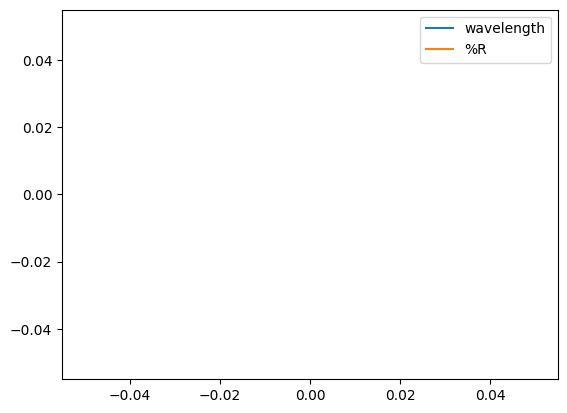

spectrum=<spectraltools.Spectrum object at 0x0000024F728B0170>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


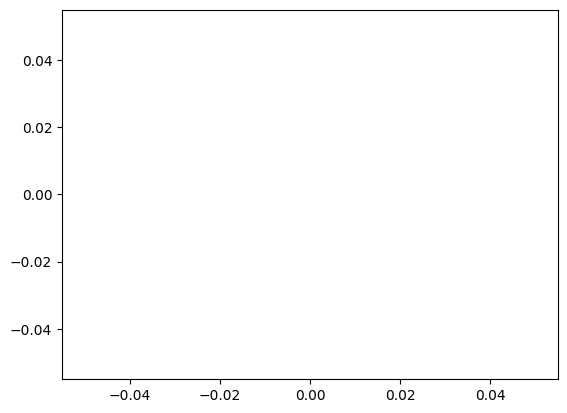

<Figure size 640x480 with 0 Axes>

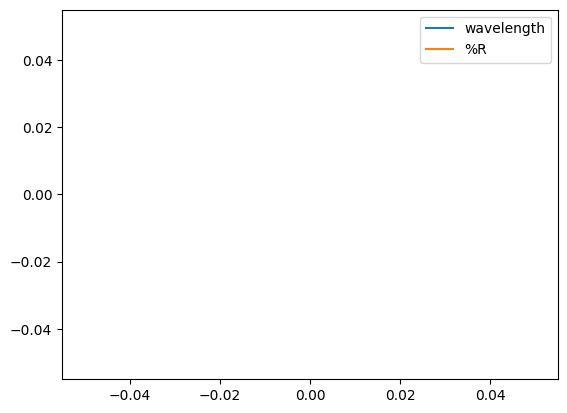

spectrum=<spectraltools.Spectrum object at 0x0000024F70713C50>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=32    Chrysina
Name: genus, dtype: object


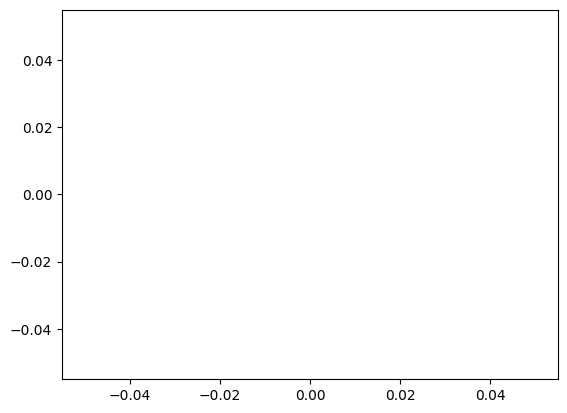

<Figure size 640x480 with 0 Axes>

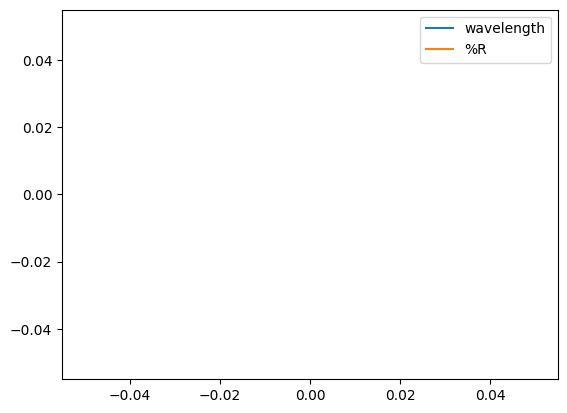

spectrum=<spectraltools.Spectrum object at 0x0000024F72E88950>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=32    Chrysina
Name: genus, dtype: object


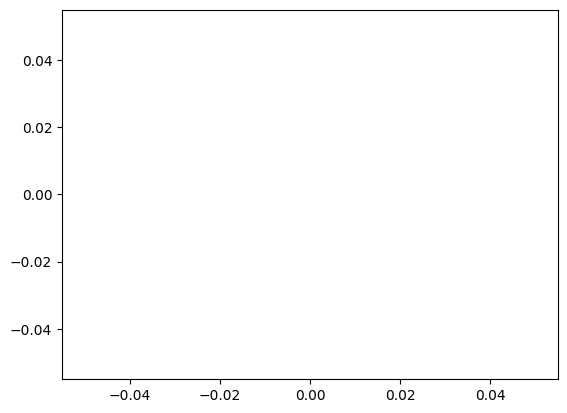

<Figure size 640x480 with 0 Axes>

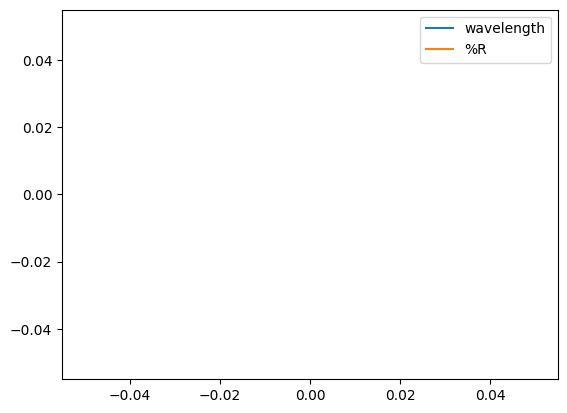

spectrum=<spectraltools.Spectrum object at 0x0000024F729A06E0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


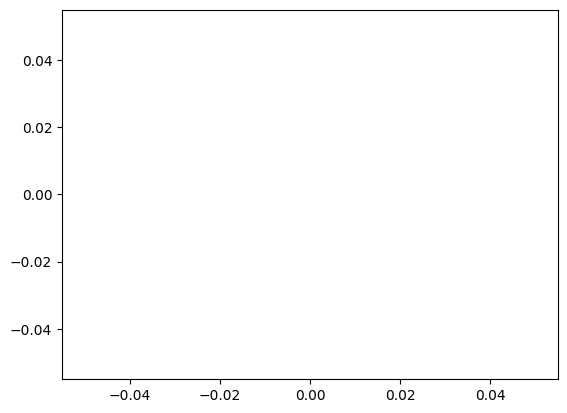

<Figure size 640x480 with 0 Axes>

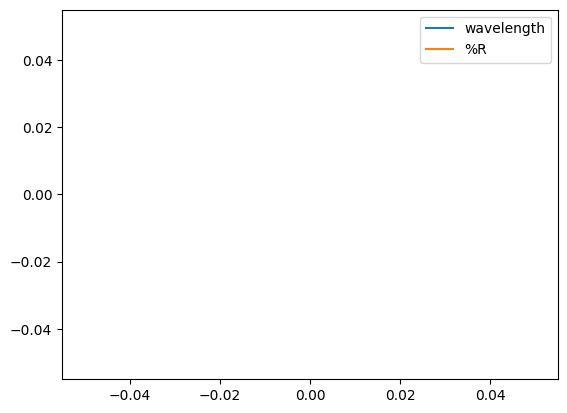

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72CE7B00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


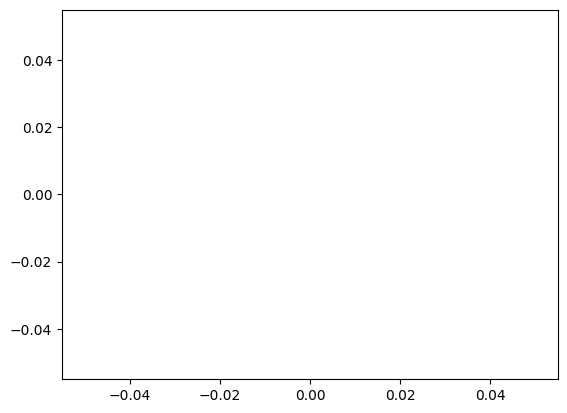

<Figure size 640x480 with 0 Axes>

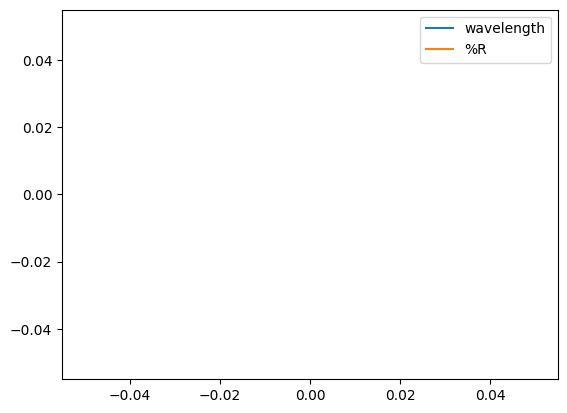

spectrum=<spectraltools.Spectrum object at 0x0000024F72F8F800>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


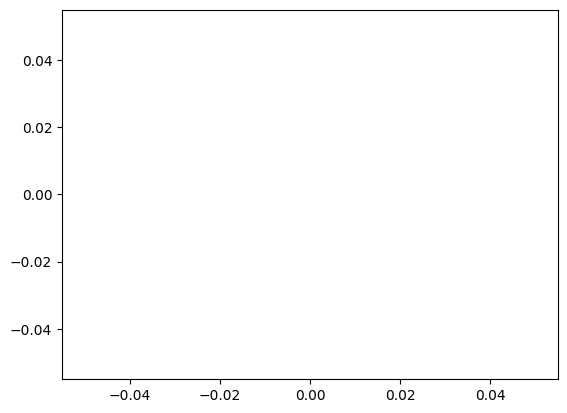

<Figure size 640x480 with 0 Axes>

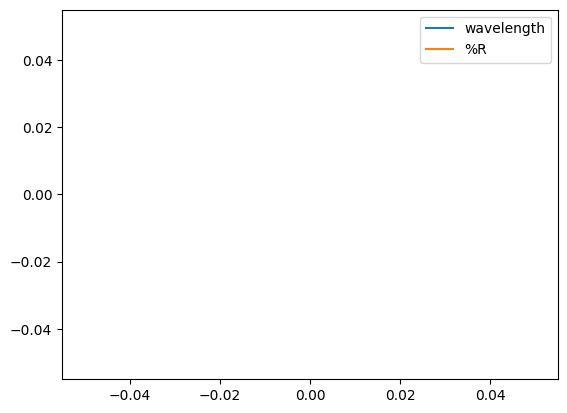

spectrum=<spectraltools.Spectrum object at 0x0000024F730E45F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


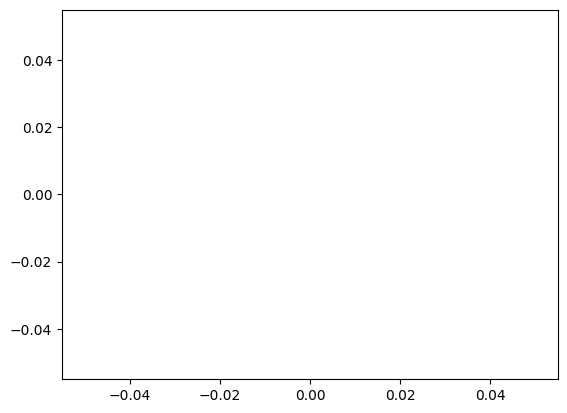

<Figure size 640x480 with 0 Axes>

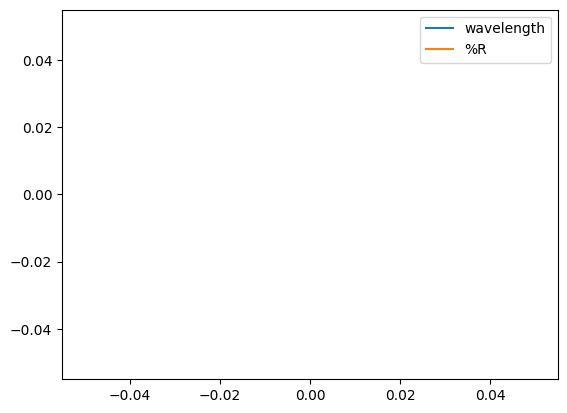

spectrum=<spectraltools.Spectrum object at 0x0000024F72F710A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


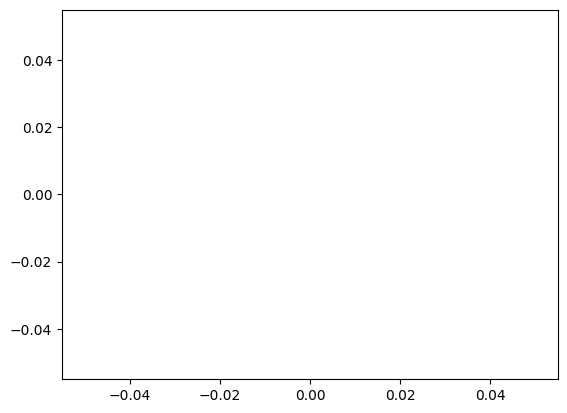

<Figure size 640x480 with 0 Axes>

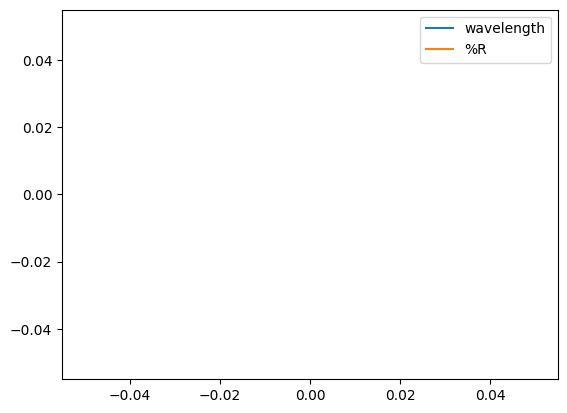

spectrum=<spectraltools.Spectrum object at 0x0000024F72EEACC0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


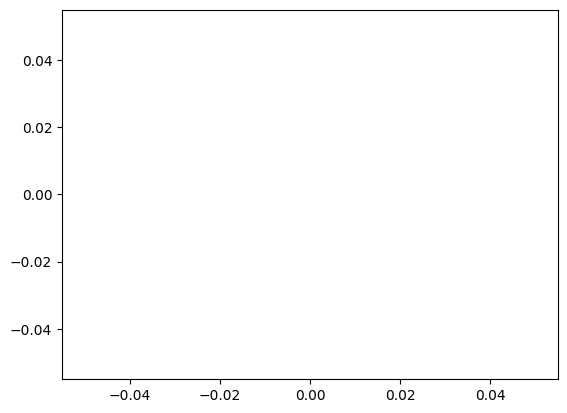

<Figure size 640x480 with 0 Axes>

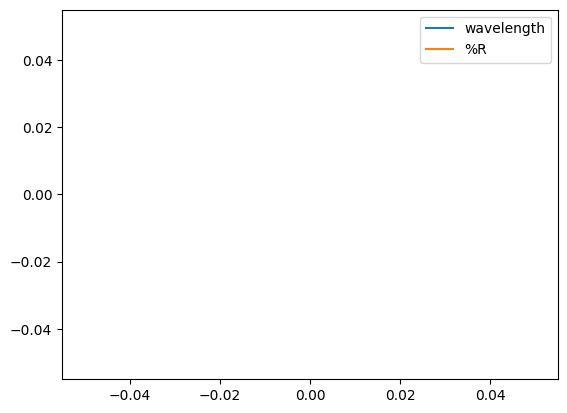

spectrum=<spectraltools.Spectrum object at 0x0000024F72F28B60>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=32    Chrysina
Name: genus, dtype: object


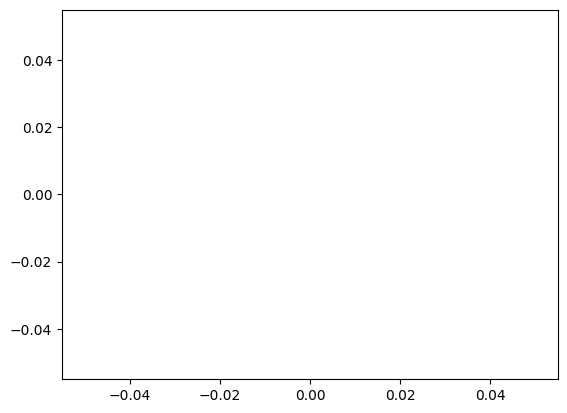

<Figure size 640x480 with 0 Axes>

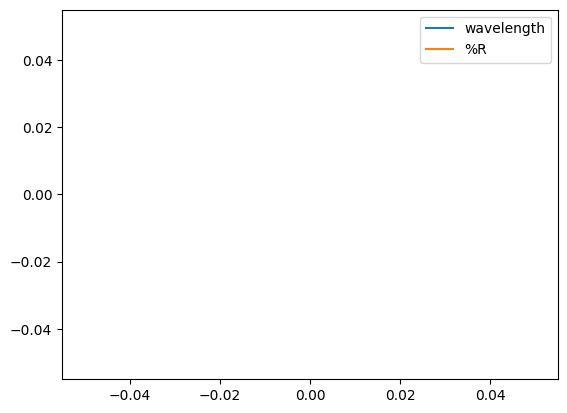

spectrum=<spectraltools.Spectrum object at 0x0000024F744812B0>
right_pol=['..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R4.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R5.csv']
left_pol=['..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L4.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L5.csv']
no_polarization=[]
Average Craic
Create spectrum from file
Collection lookup
INBIO
Gen

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

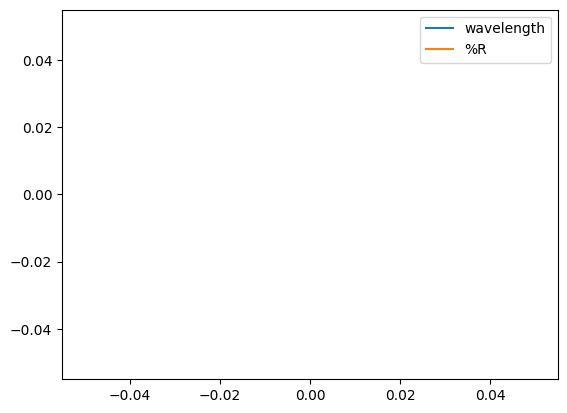

spectrum=<spectraltools.Spectrum object at 0x0000024F7459F2C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=49    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

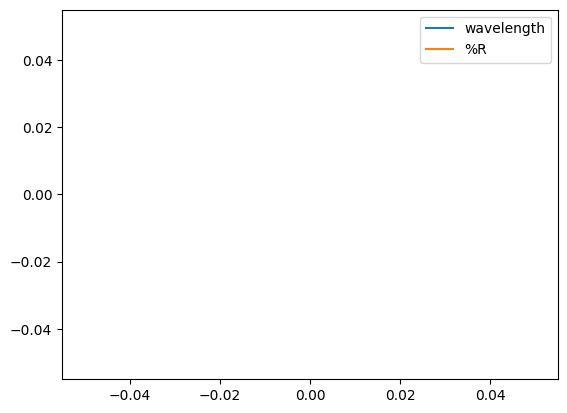

spectrum=<spectraltools.Spectrum object at 0x0000024F755F71A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=50    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736458L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

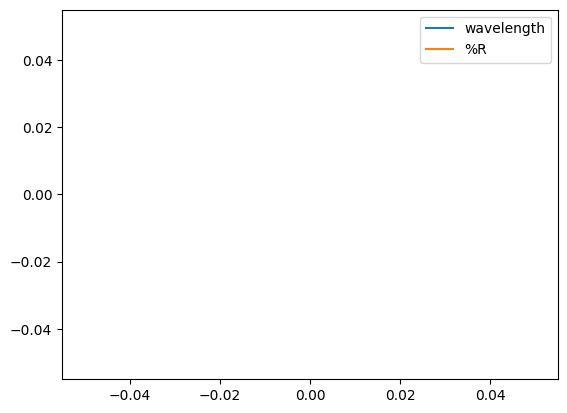

spectrum=<spectraltools.Spectrum object at 0x0000024F7427CEC0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=51    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736459L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

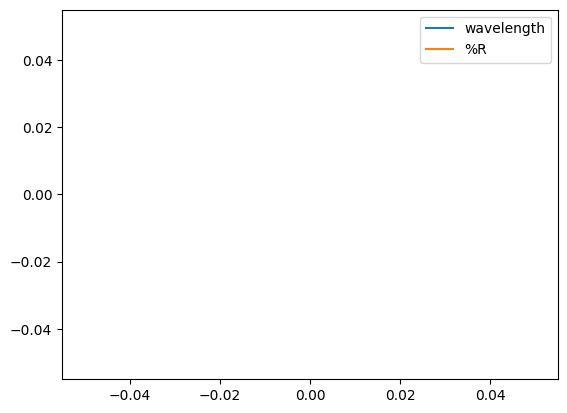

spectrum=<spectraltools.Spectrum object at 0x0000024F7427D1F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=72    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

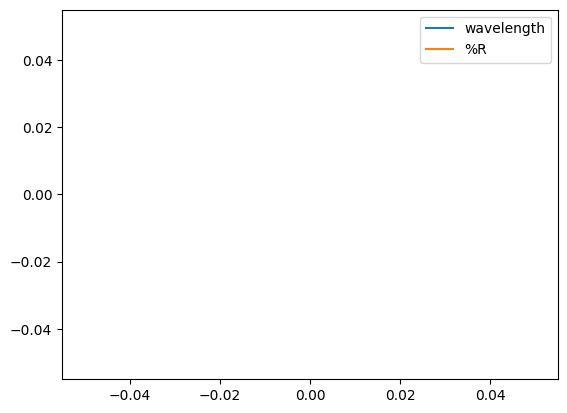

spectrum=<spectraltools.Spectrum object at 0x0000024F74262120>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=52    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195354L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

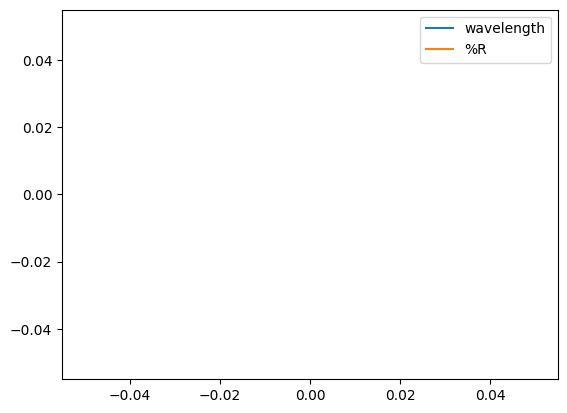

spectrum=<spectraltools.Spectrum object at 0x0000024F745F4BC0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=53    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

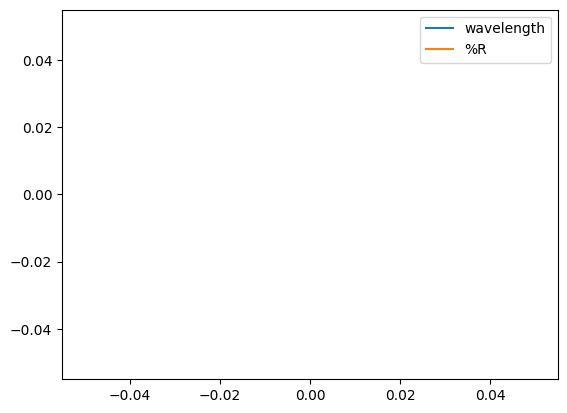

spectrum=<spectraltools.Spectrum object at 0x0000024F74481760>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=54    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195357L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

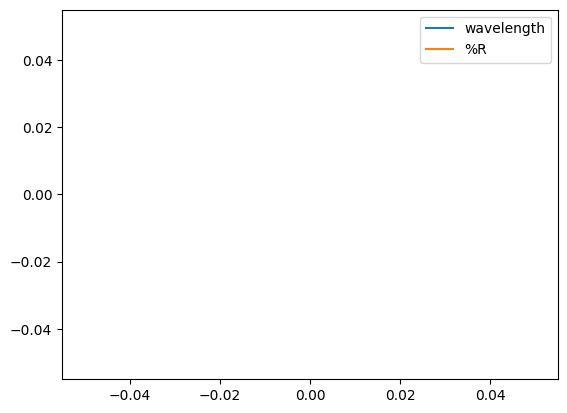

spectrum=<spectraltools.Spectrum object at 0x0000024F74568DD0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=55    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195358L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

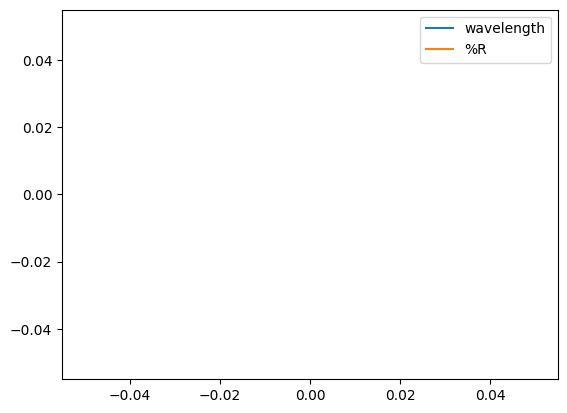

spectrum=<spectraltools.Spectrum object at 0x0000024F755F4D40>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=56    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

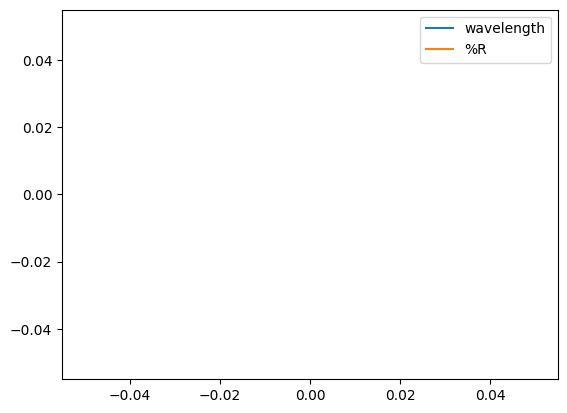

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2248544L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F742A4560>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=26    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

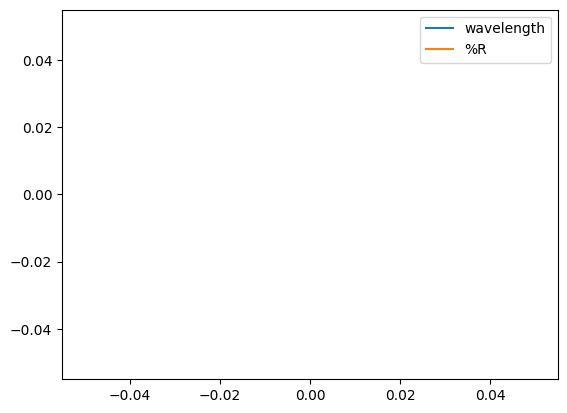

spectrum=<spectraltools.Spectrum object at 0x0000024F742A65A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=27    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249504L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

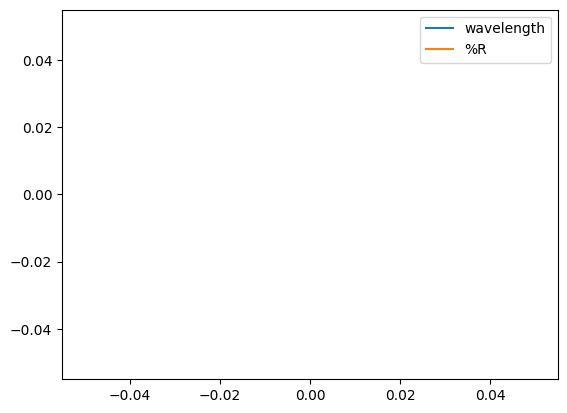

spectrum=<spectraltools.Spectrum object at 0x0000024F74481E80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=28    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

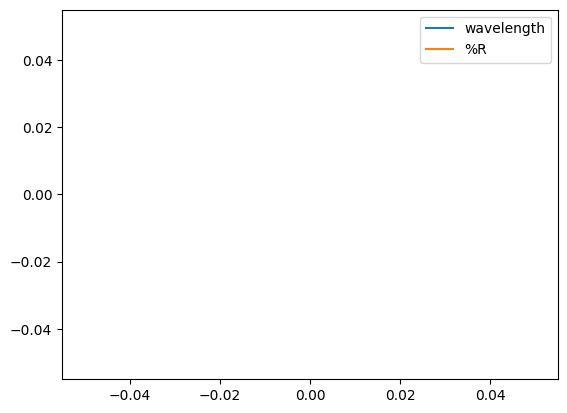

spectrum=<spectraltools.Spectrum object at 0x0000024F74543890>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=29    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

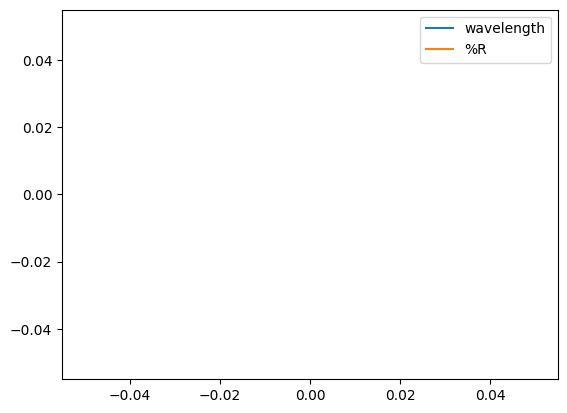

spectrum=<spectraltools.Spectrum object at 0x0000024F74543A40>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=30    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2361339L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

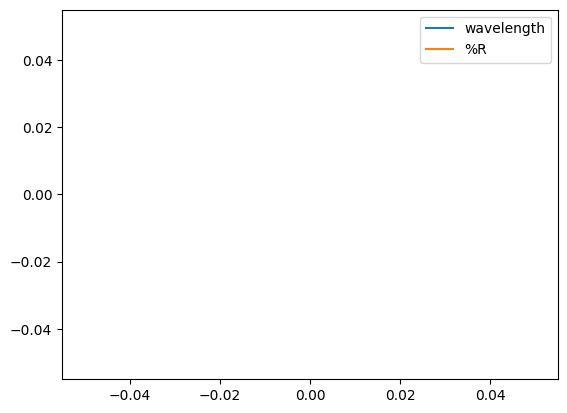

spectrum=<spectraltools.Spectrum object at 0x0000024F730E7140>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=31    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

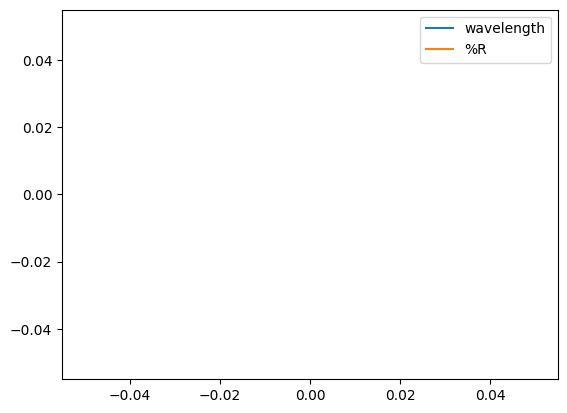

spectrum=<spectraltools.Spectrum object at 0x0000024F74569B50>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

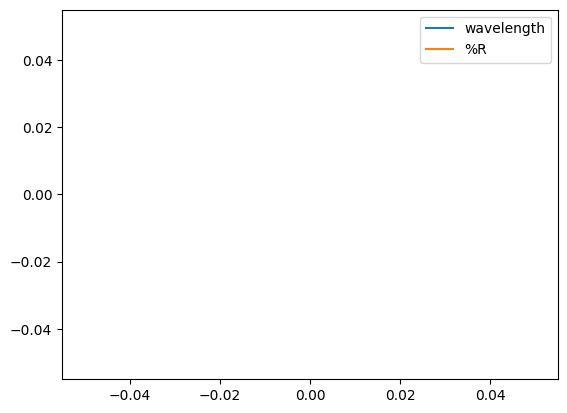

spectrum=<spectraltools.Spectrum object at 0x0000024F7316D070>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

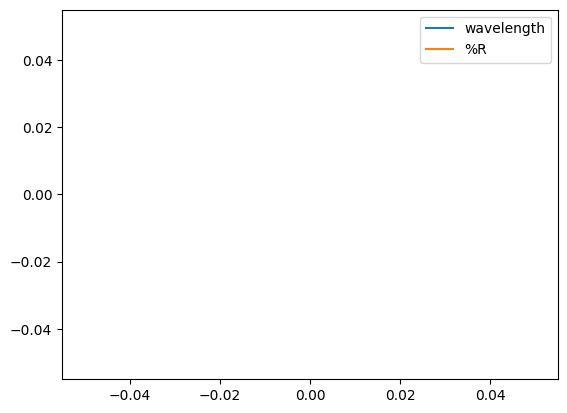

spectrum=<spectraltools.Spectrum object at 0x0000024F74310A70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=34    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388550L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

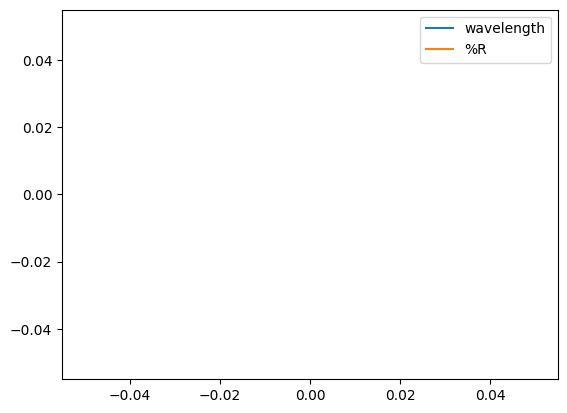

spectrum=<spectraltools.Spectrum object at 0x0000024F74540F80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=35    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388554L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

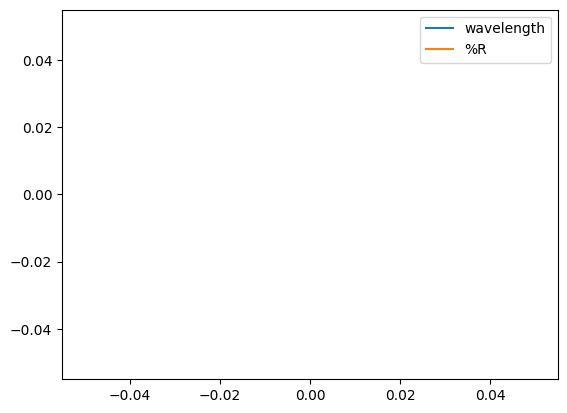

spectrum=<spectraltools.Spectrum object at 0x0000024F74569C40>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=36    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

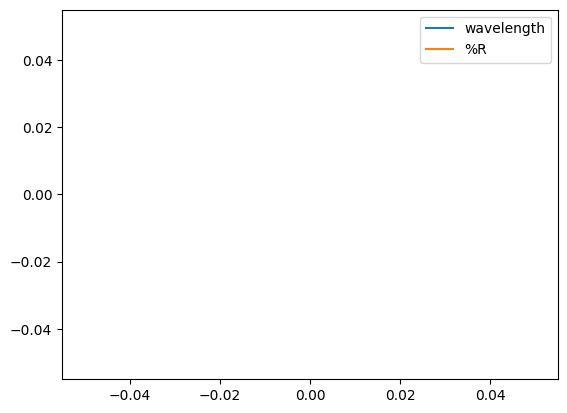

spectrum=<spectraltools.Spectrum object at 0x0000024F743123C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=37    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

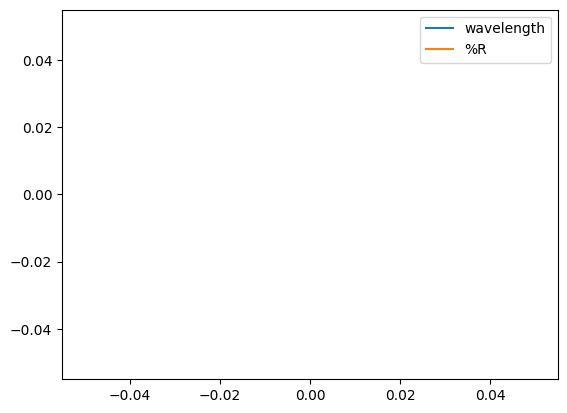

spectrum=<spectraltools.Spectrum object at 0x0000024F730E4740>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=38    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2452030L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

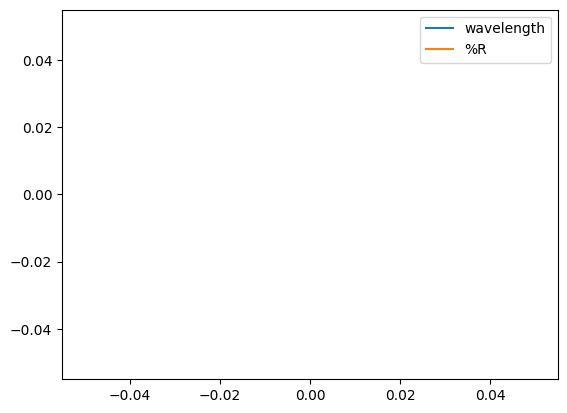

spectrum=<spectraltools.Spectrum object at 0x0000024F74420440>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=39    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2453057L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

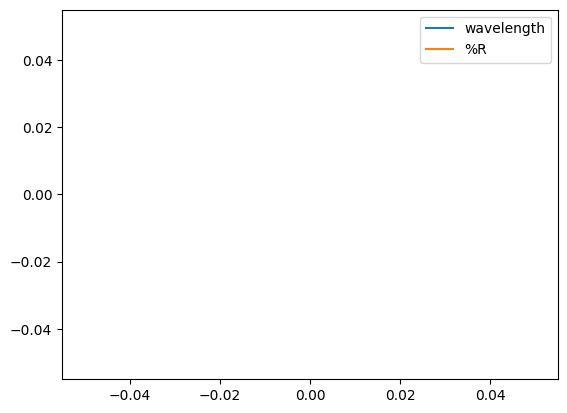

spectrum=<spectraltools.Spectrum object at 0x0000024F744E71A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=57    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2456006L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

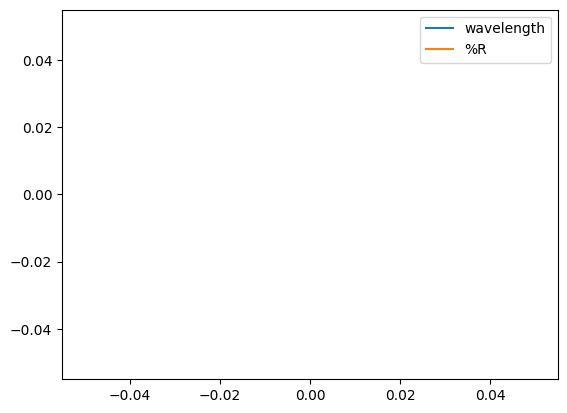

spectrum=<spectraltools.Spectrum object at 0x0000024F74477A40>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=40    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2467329L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

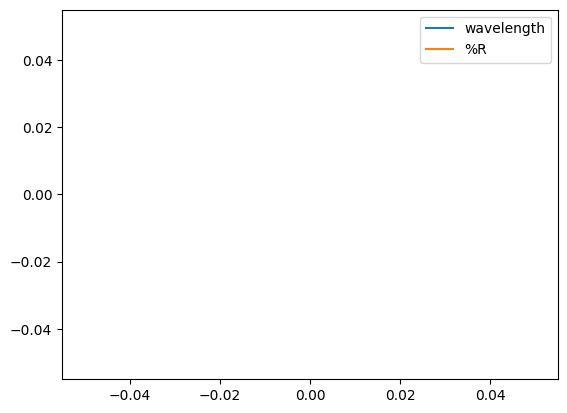

spectrum=<spectraltools.Spectrum object at 0x0000024F7311BB00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=58    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2548659L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

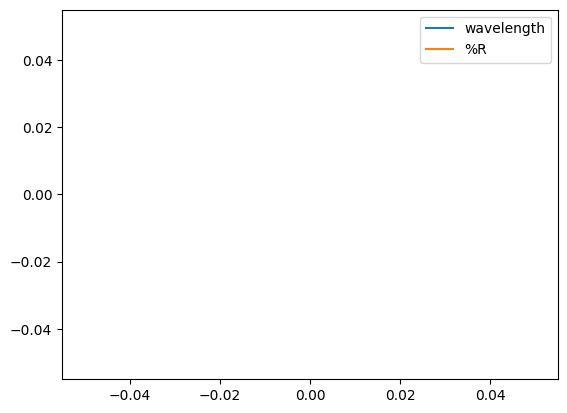

spectrum=<spectraltools.Spectrum object at 0x0000024F73027B00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=59    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\3036568L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

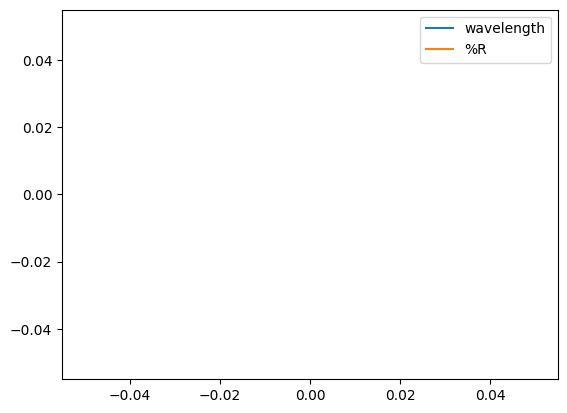

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72EA02F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

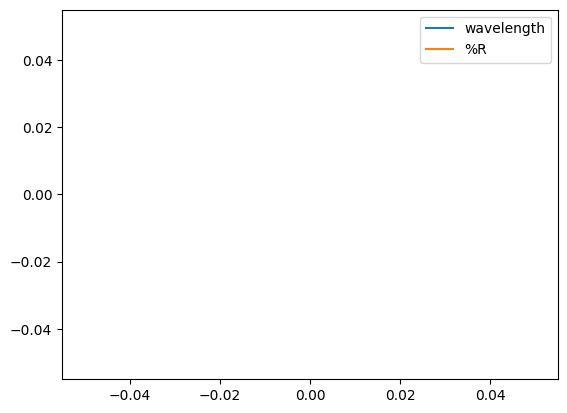

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72EA1070>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

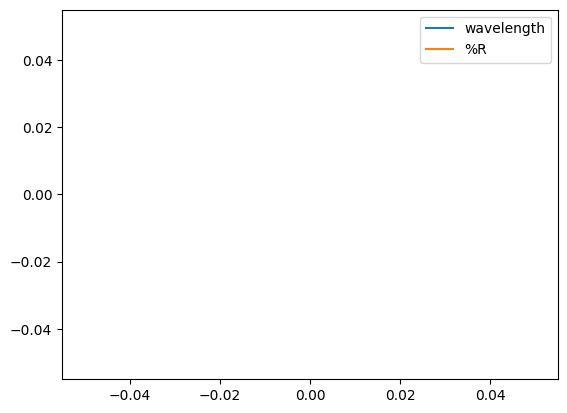

spectrum=<spectraltools.Spectrum object at 0x0000024F72F10A70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

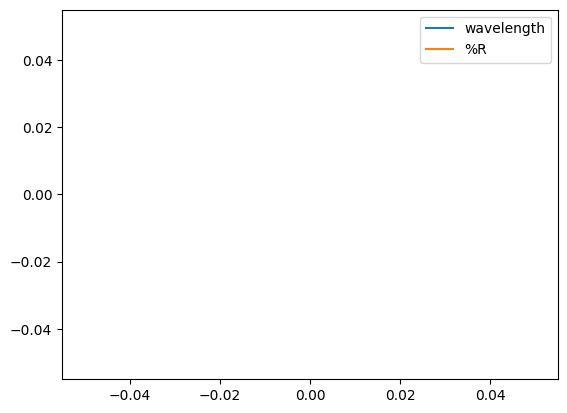

spectrum=<spectraltools.Spectrum object at 0x0000024F743EA240>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

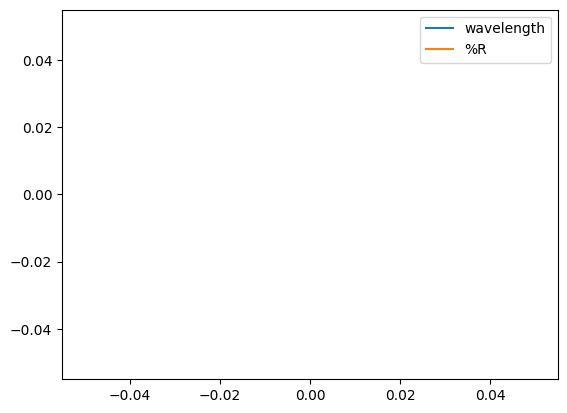

spectrum=<spectraltools.Spectrum object at 0x0000024F72C7F980>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

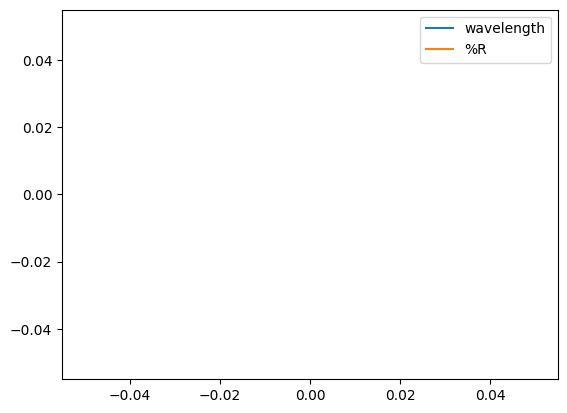

spectrum=<spectraltools.Spectrum object at 0x0000024F72C4D850>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

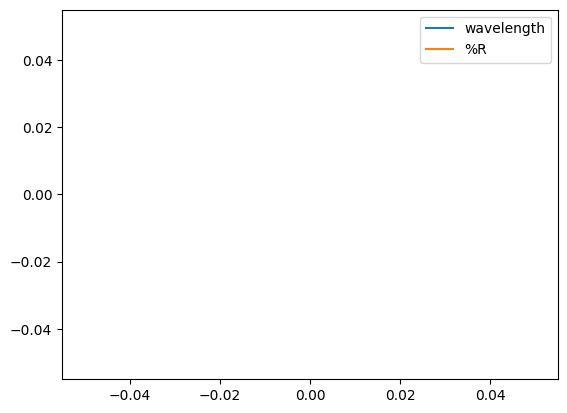

spectrum=<spectraltools.Spectrum object at 0x0000024F74387950>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

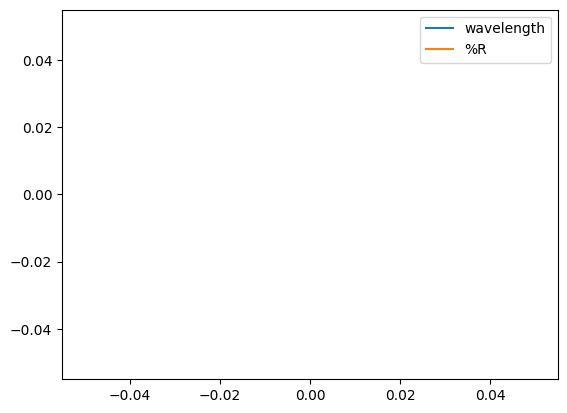

spectrum=<spectraltools.Spectrum object at 0x0000024F74386600>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

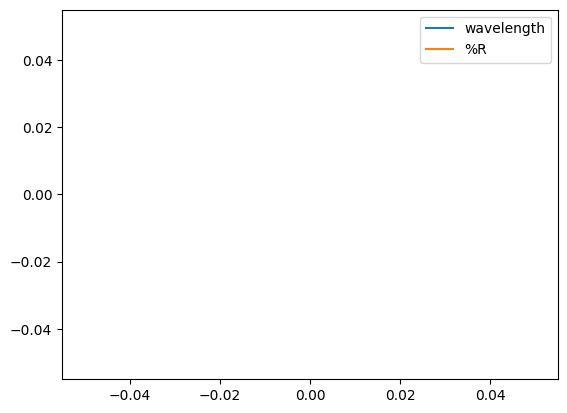

spectrum=<spectraltools.Spectrum object at 0x0000024F72EC3050>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

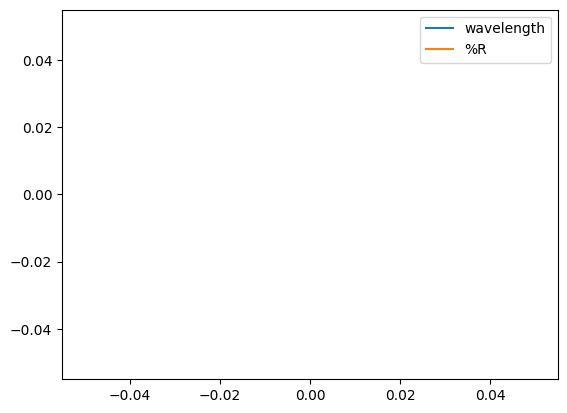

spectrum=<spectraltools.Spectrum object at 0x0000024F73051D90>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

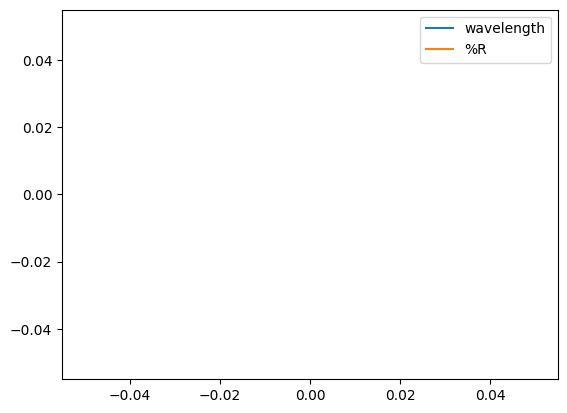

spectrum=<spectraltools.Spectrum object at 0x0000024F74346D20>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

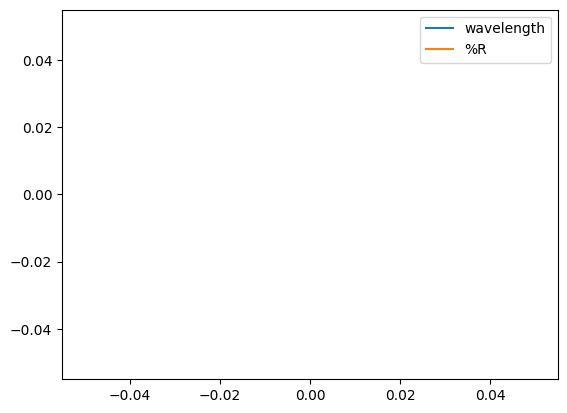

spectrum=<spectraltools.Spectrum object at 0x0000024F74346E70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

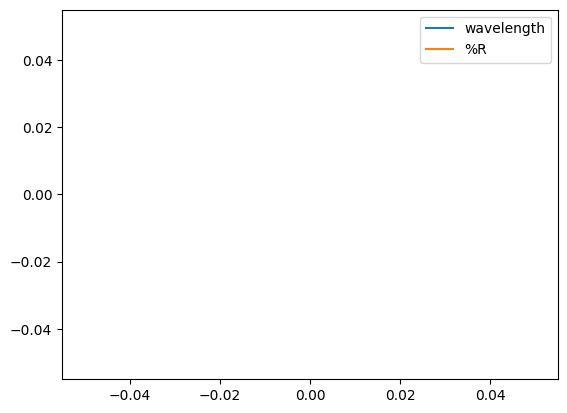

spectrum=<spectraltools.Spectrum object at 0x0000024F755F4B00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

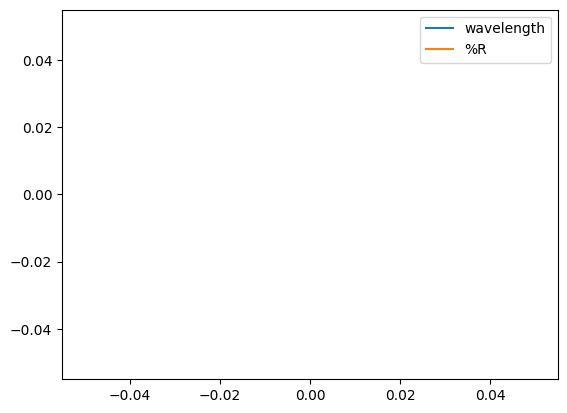

spectrum=<spectraltools.Spectrum object at 0x0000024F744C7D70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

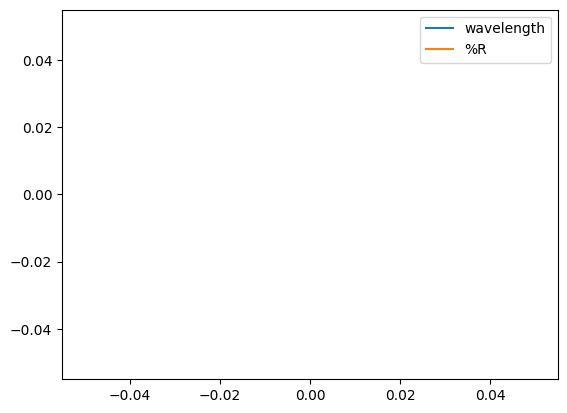

spectrum=<spectraltools.Spectrum object at 0x0000024F73027320>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

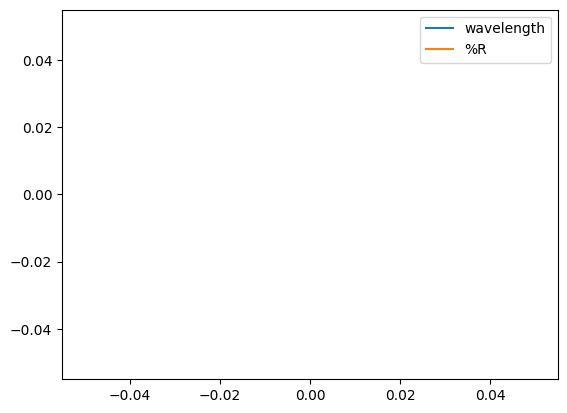

spectrum=<spectraltools.Spectrum object at 0x0000024F73051790>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

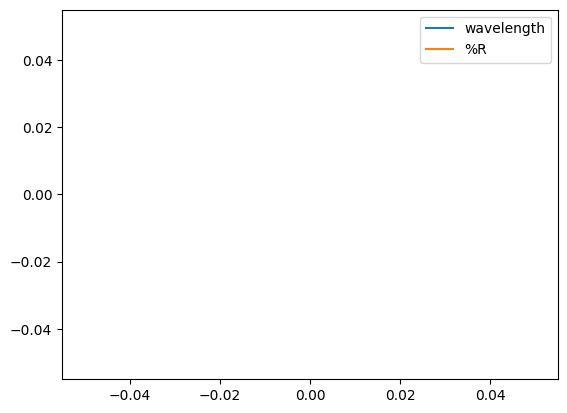

spectrum=<spectraltools.Spectrum object at 0x0000024F730E4080>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

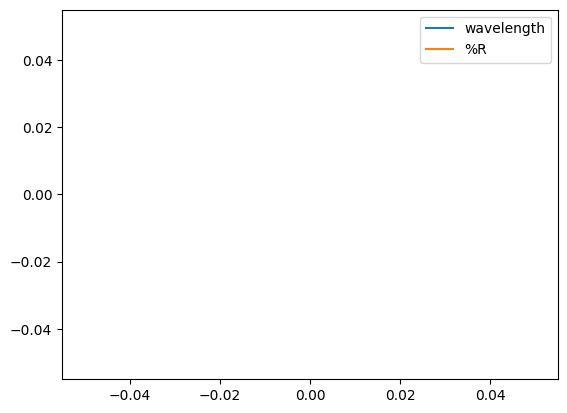

spectrum=<spectraltools.Spectrum object at 0x0000024F743EA9C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

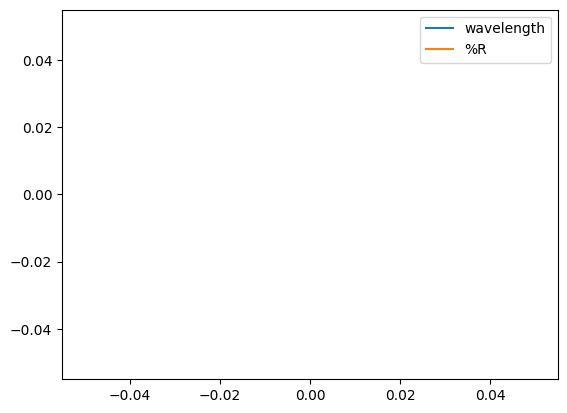

spectrum=<spectraltools.Spectrum object at 0x0000024F74310200>
Average Craic
Create spectrum from file
Collection lookup
INBIO
Genus specimen=71    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

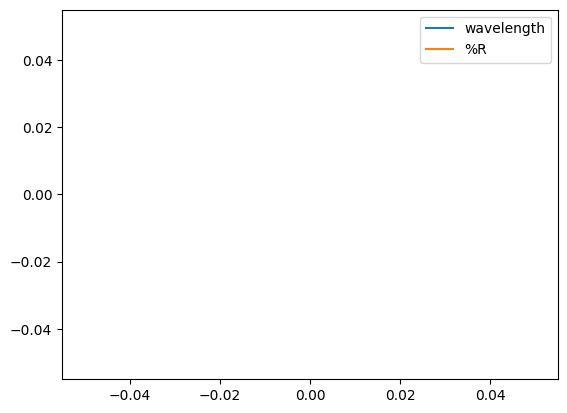

spectrum=<spectraltools.Spectrum object at 0x0000024F72FDFB00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=49    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

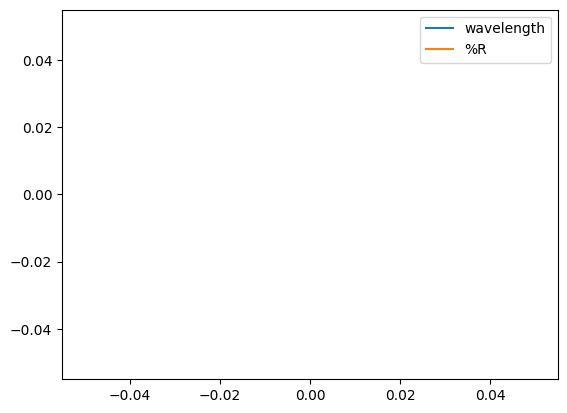

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736458L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72EA1070>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=50    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

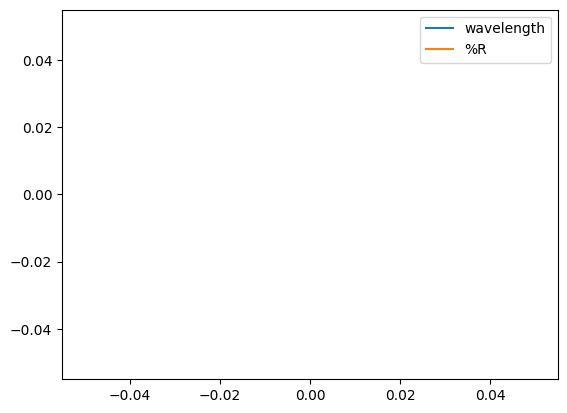

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736459L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F745F4BC0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=51    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

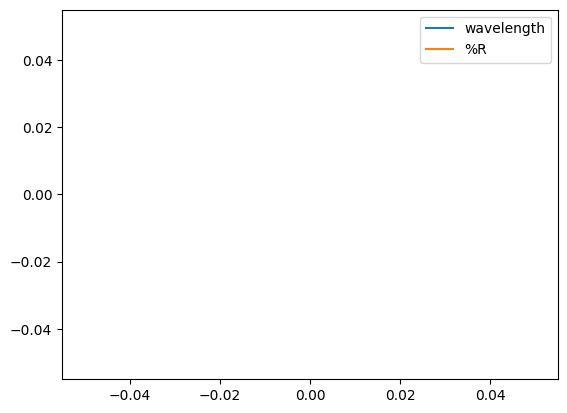

spectrum=<spectraltools.Spectrum object at 0x0000024F743EA9C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=72    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

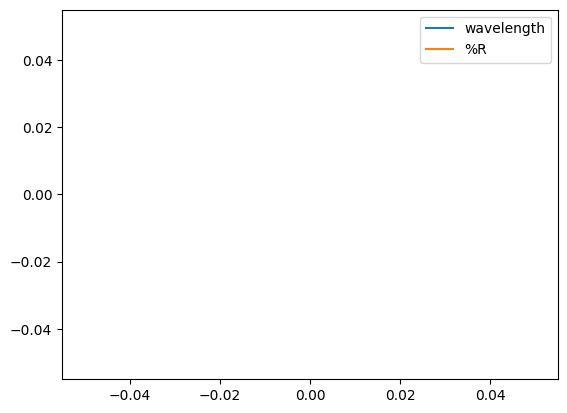

spectrum=<spectraltools.Spectrum object at 0x0000024F72C99670>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=52    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195354L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

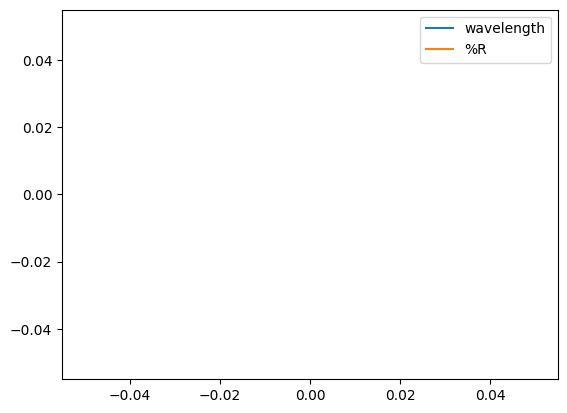

spectrum=<spectraltools.Spectrum object at 0x0000024F731B23F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=53    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

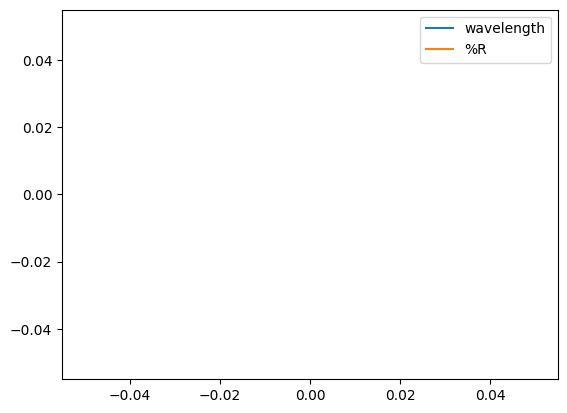

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195357L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72E19730>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=54    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

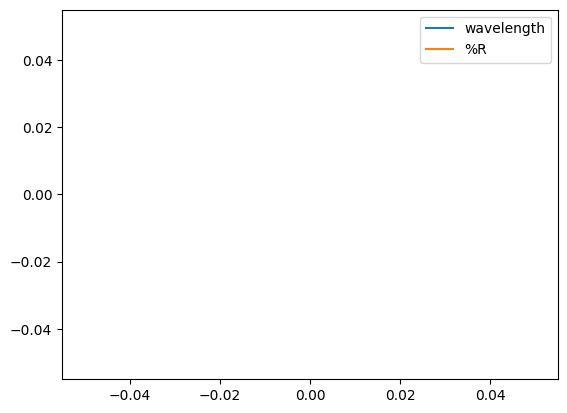

spectrum=<spectraltools.Spectrum object at 0x0000024F7432FDD0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=55    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195358L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

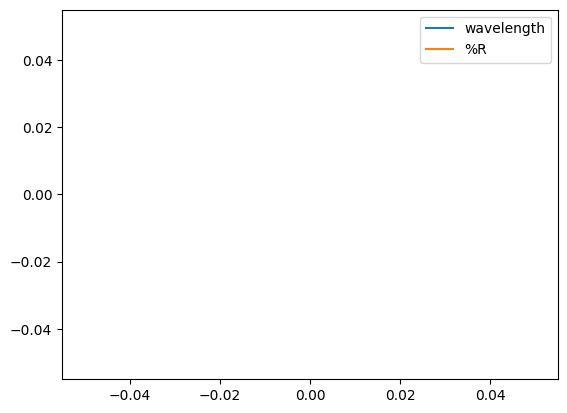

spectrum=<spectraltools.Spectrum object at 0x0000024F7459DF40>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=56    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

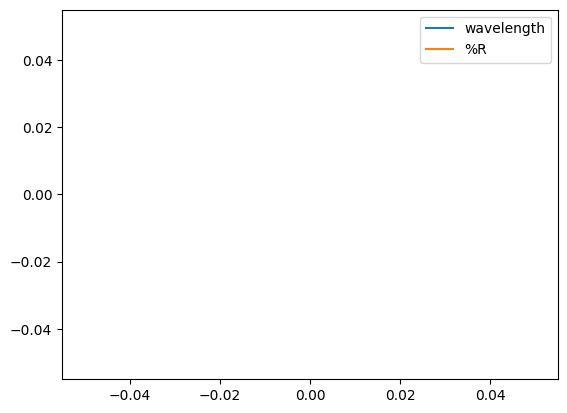

spectrum=<spectraltools.Spectrum object at 0x0000024F74587830>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=26    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2248544L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

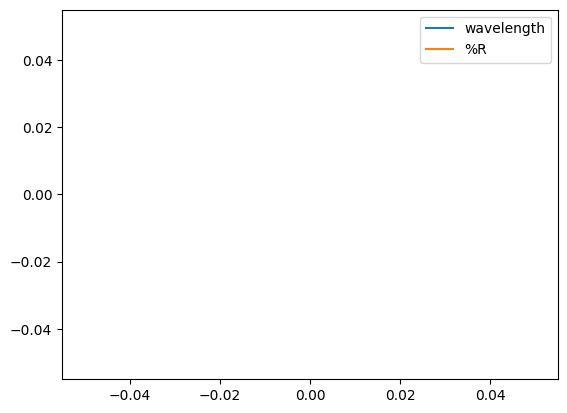

spectrum=<spectraltools.Spectrum object at 0x0000024F72C9BB90>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=27    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249504L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

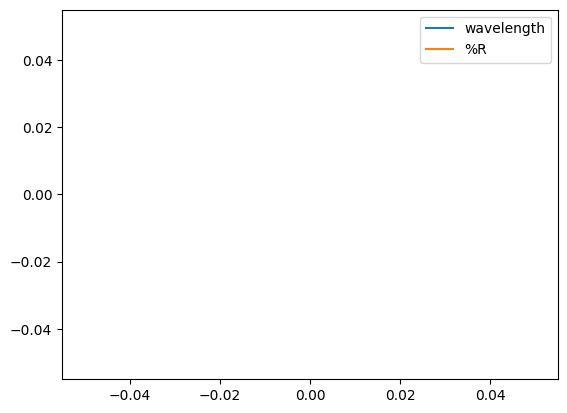

spectrum=<spectraltools.Spectrum object at 0x0000024F72E58200>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=28    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

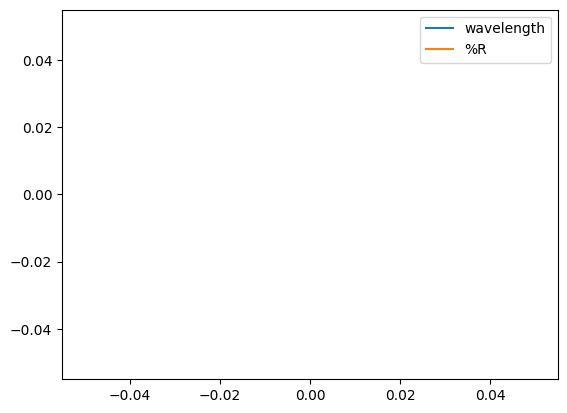

spectrum=<spectraltools.Spectrum object at 0x0000024F74501AC0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=29    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

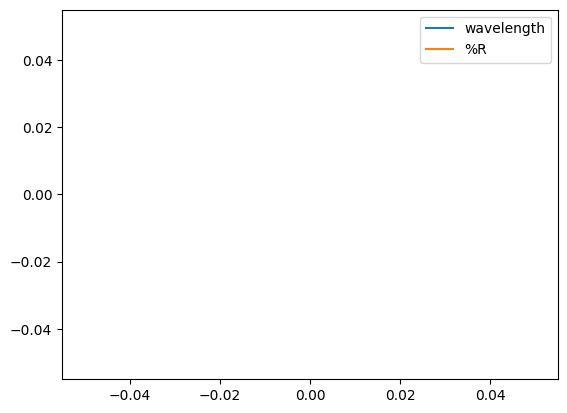

spectrum=<spectraltools.Spectrum object at 0x0000024F72EE8950>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=30    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2361339L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

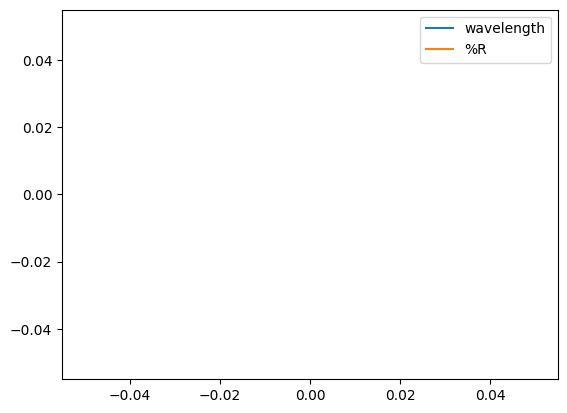

spectrum=<spectraltools.Spectrum object at 0x0000024F74482FF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=31    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

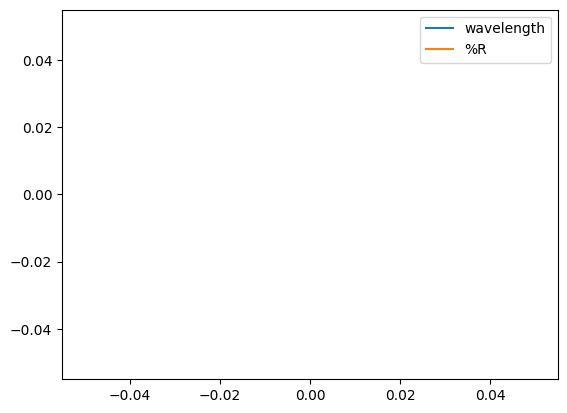

spectrum=<spectraltools.Spectrum object at 0x0000024F7311A630>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

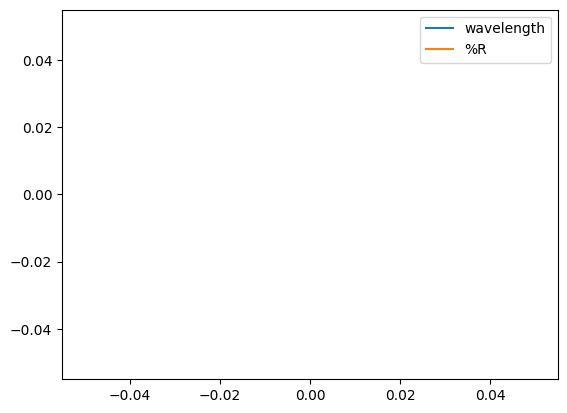

spectrum=<spectraltools.Spectrum object at 0x0000024F73051400>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

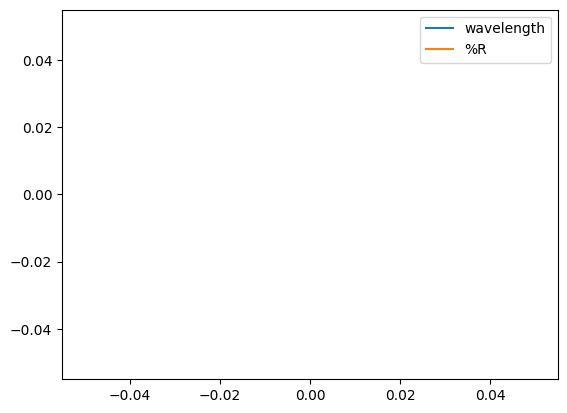

spectrum=<spectraltools.Spectrum object at 0x0000024F7316C890>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=34    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388550L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

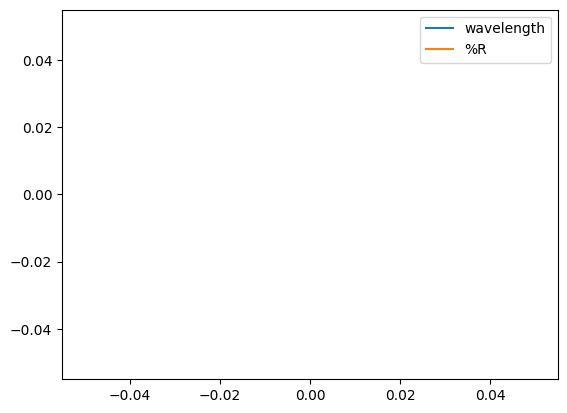

spectrum=<spectraltools.Spectrum object at 0x0000024F72F280B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=35    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388554L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

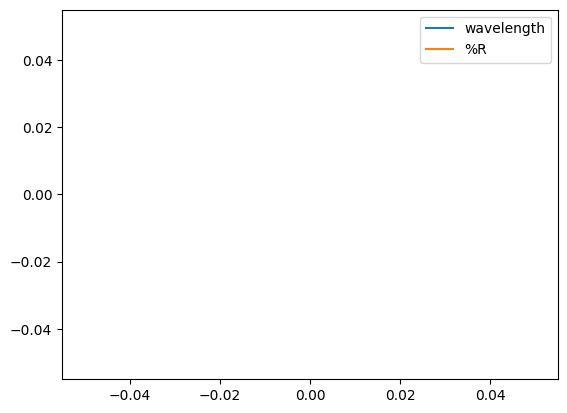

spectrum=<spectraltools.Spectrum object at 0x0000024F72CE50D0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=36    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

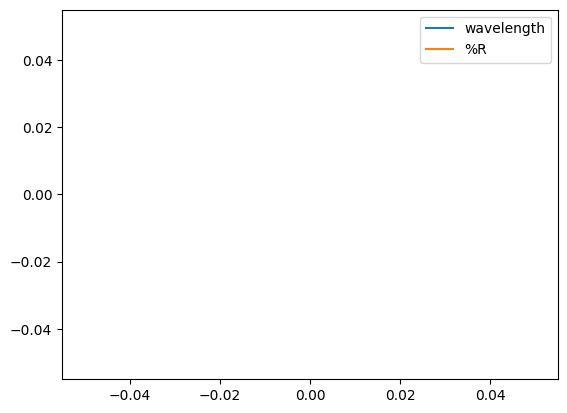

spectrum=<spectraltools.Spectrum object at 0x0000024F72D72240>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=37    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

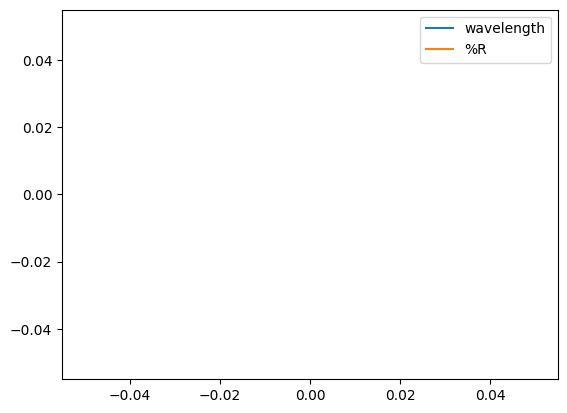

spectrum=<spectraltools.Spectrum object at 0x0000024F72F8D2E0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=38    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2452030L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

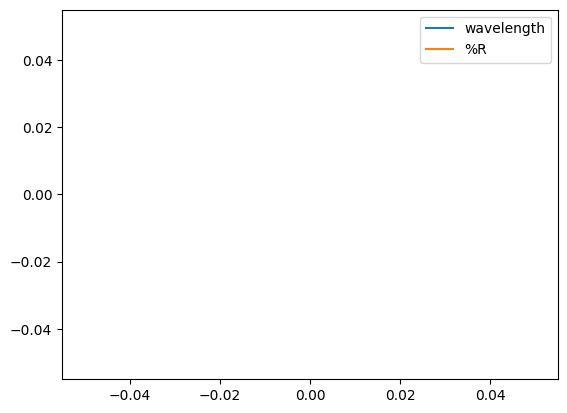

spectrum=<spectraltools.Spectrum object at 0x0000024F72CE6D20>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=39    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2453057L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

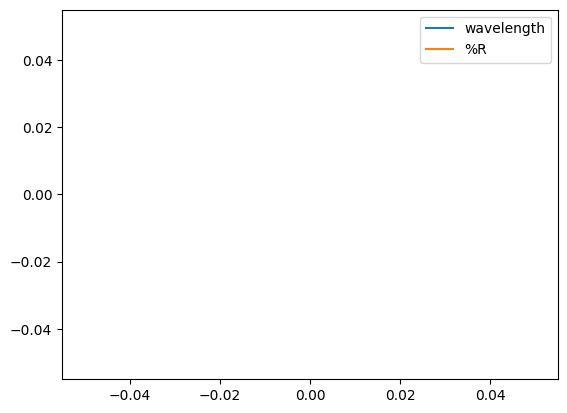

spectrum=<spectraltools.Spectrum object at 0x0000024F72E1B110>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=57    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2456006L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

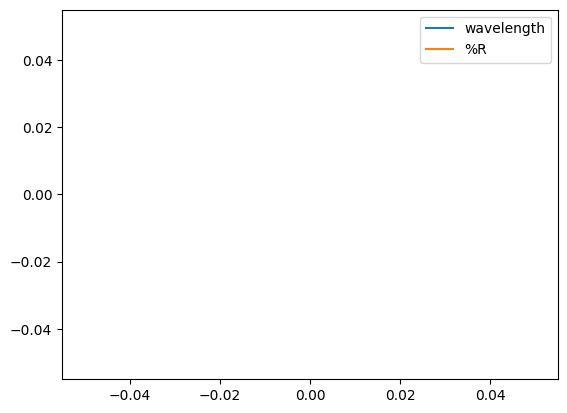

spectrum=<spectraltools.Spectrum object at 0x0000024F72E8BE00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=40    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2467329L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

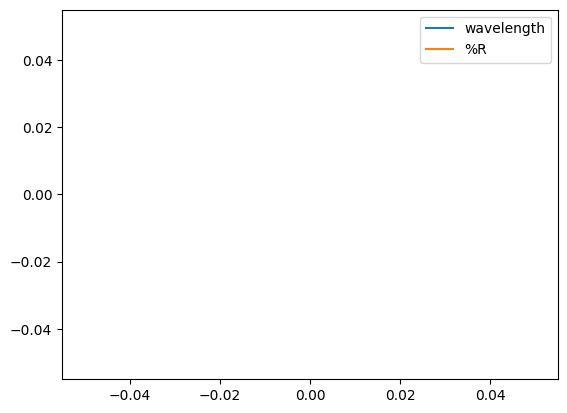

spectrum=<spectraltools.Spectrum object at 0x0000024F7314D4F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=58    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2548659L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

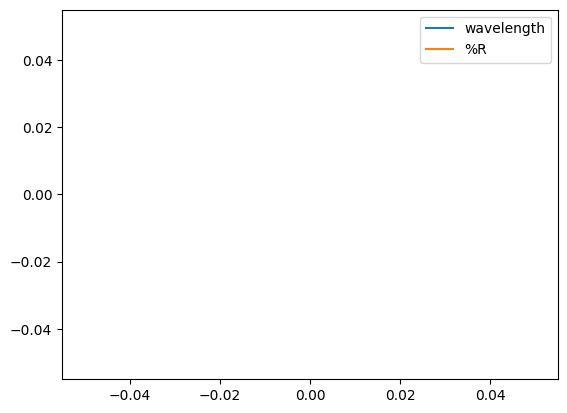

spectrum=<spectraltools.Spectrum object at 0x0000024F7314D910>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=59    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\3036568L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

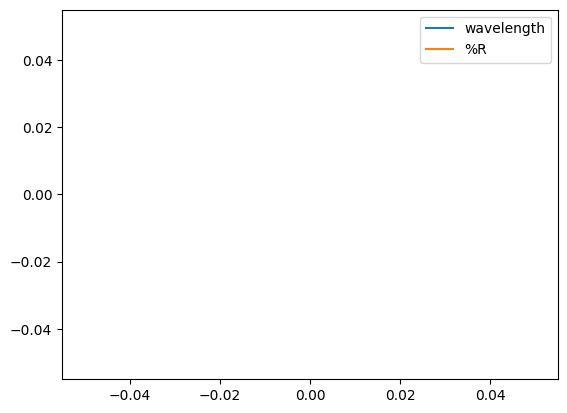

spectrum=<spectraltools.Spectrum object at 0x0000024F7316D070>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

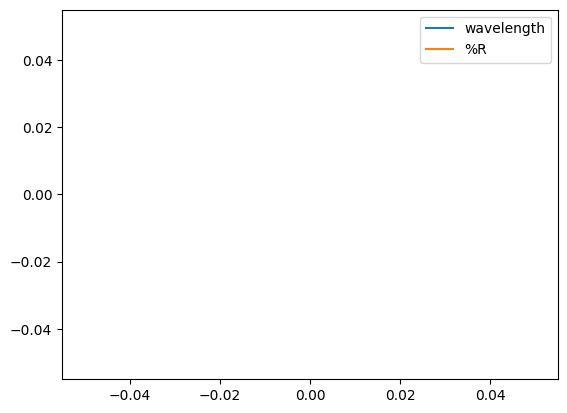

spectrum=<spectraltools.Spectrum object at 0x0000024F73053DD0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

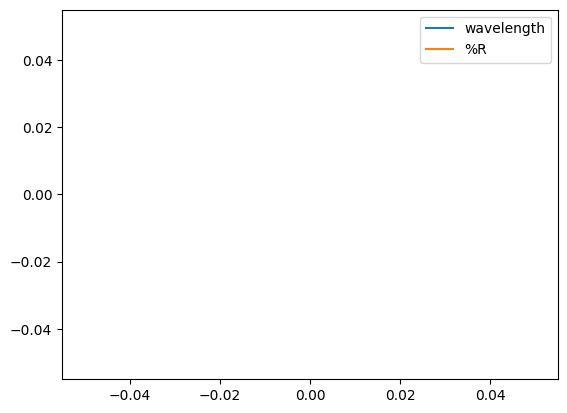

spectrum=<spectraltools.Spectrum object at 0x0000024F743871A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

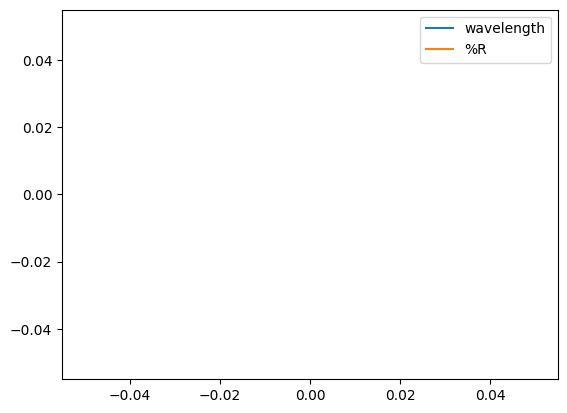

spectrum=<spectraltools.Spectrum object at 0x0000024F7422D460>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

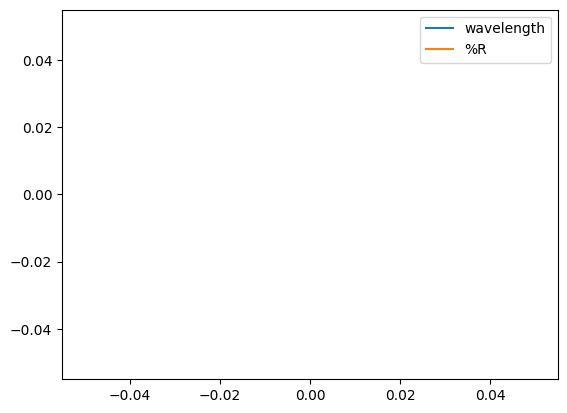

spectrum=<spectraltools.Spectrum object at 0x0000024F74205E80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

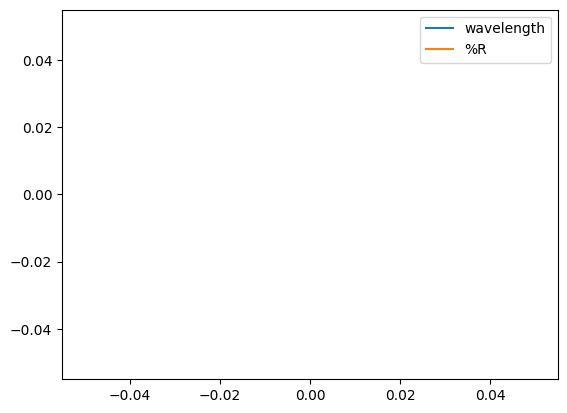

spectrum=<spectraltools.Spectrum object at 0x0000024F7427E270>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

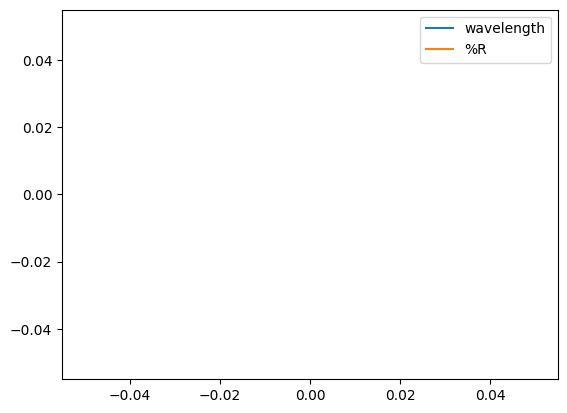

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72D726F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

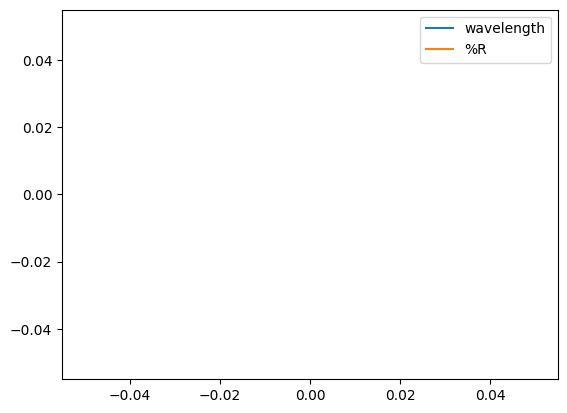

spectrum=<spectraltools.Spectrum object at 0x0000024F73005A30>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

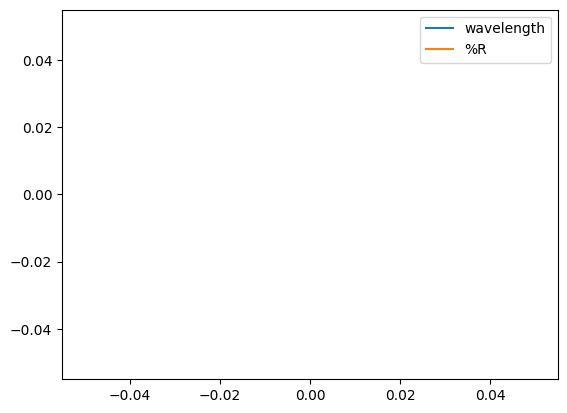

spectrum=<spectraltools.Spectrum object at 0x0000024F72E8B140>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

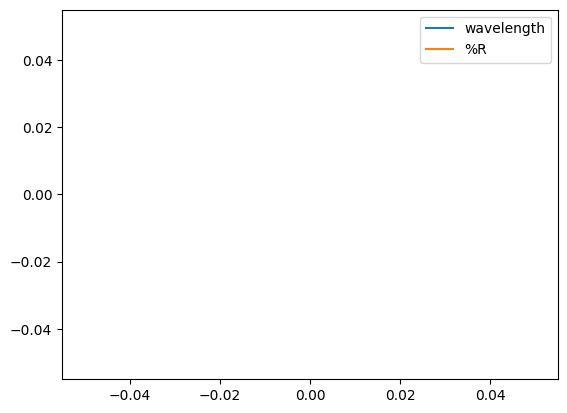

spectrum=<spectraltools.Spectrum object at 0x0000024F745854C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

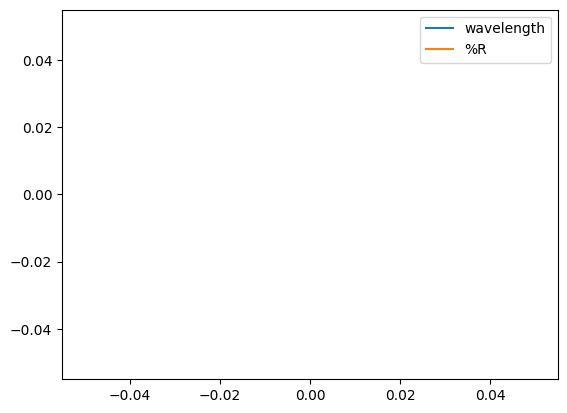

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F7427EB70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

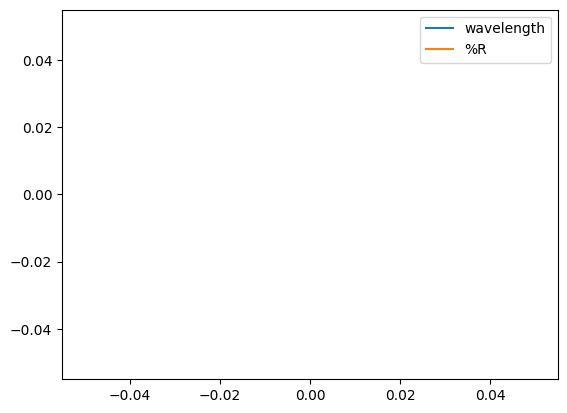

spectrum=<spectraltools.Spectrum object at 0x0000024F743E90D0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

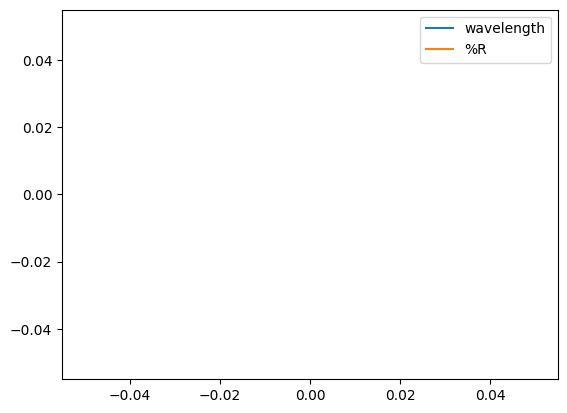

spectrum=<spectraltools.Spectrum object at 0x0000024F744B0620>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

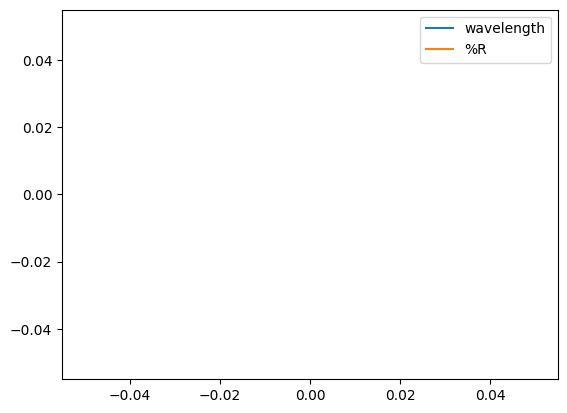

spectrum=<spectraltools.Spectrum object at 0x0000024F744E7B00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

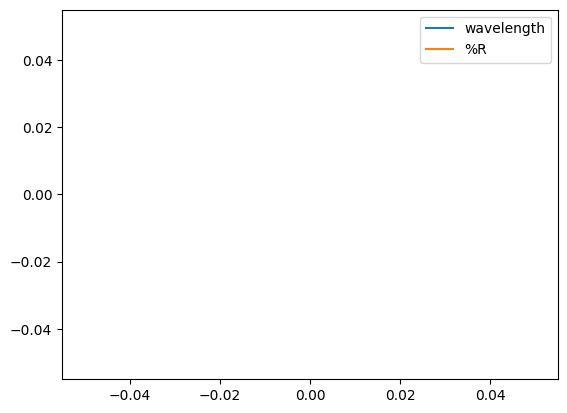

spectrum=<spectraltools.Spectrum object at 0x0000024F74500B30>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

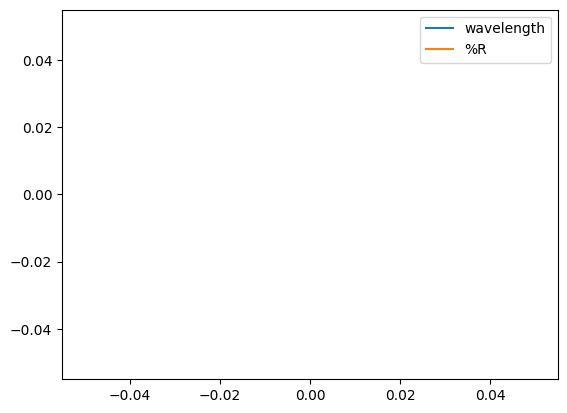

spectrum=<spectraltools.Spectrum object at 0x0000024F731B1280>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

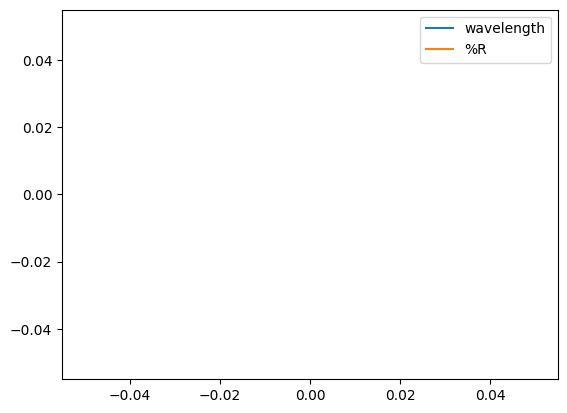

spectrum=<spectraltools.Spectrum object at 0x0000024F72E5AEA0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

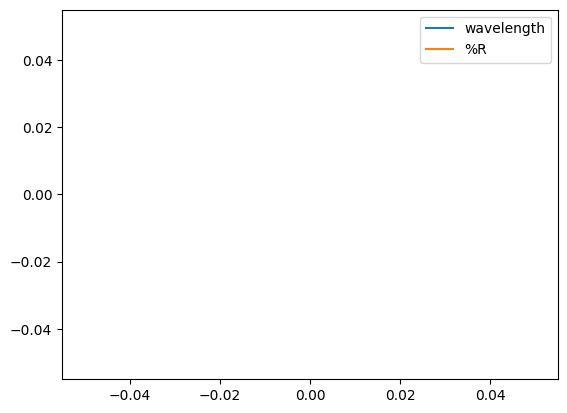

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72D518B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

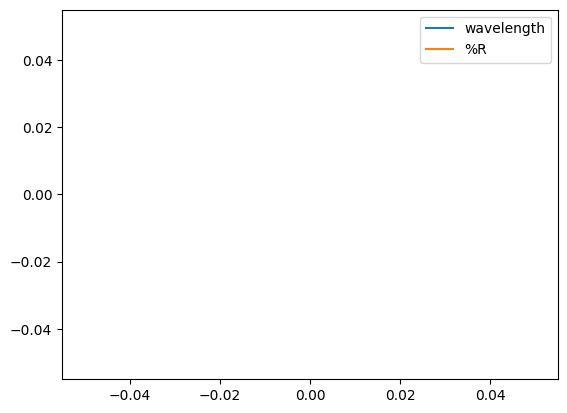

spectrum=<spectraltools.Spectrum object at 0x0000024F74503E00>
right_average_df=Empty DataFrame
Columns: [wavelength, %R]
Index: []
left_average_df=Empty DataFrame
Columns: [wavelength, %R]
Index: []
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

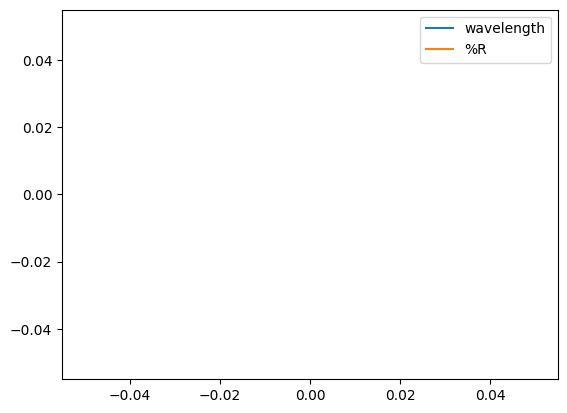

spectrum=<spectraltools.Spectrum object at 0x0000024F74500440>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

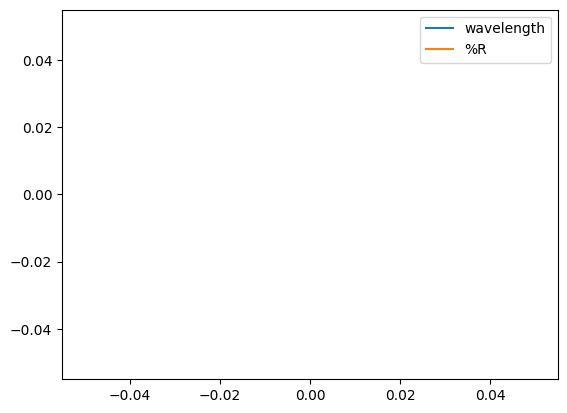

spectrum=<spectraltools.Spectrum object at 0x0000024F72F121B0>
right_pol=['..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R4.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R5.csv']
left_pol=['..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L4.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L5.csv']
no_polarization=[]
Average Craic
Create spectrum from file
Collection lookup
INBIO
Gen

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

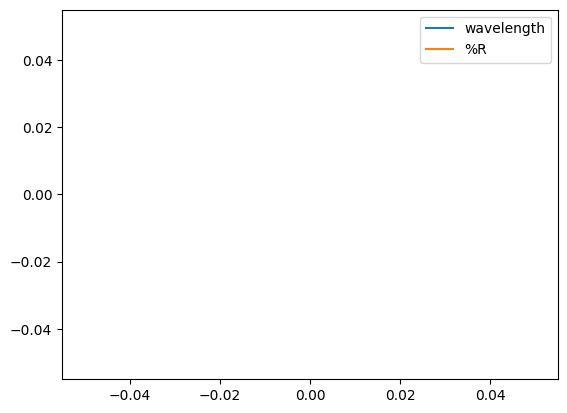

spectrum=<spectraltools.Spectrum object at 0x0000024F742A64B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=49    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

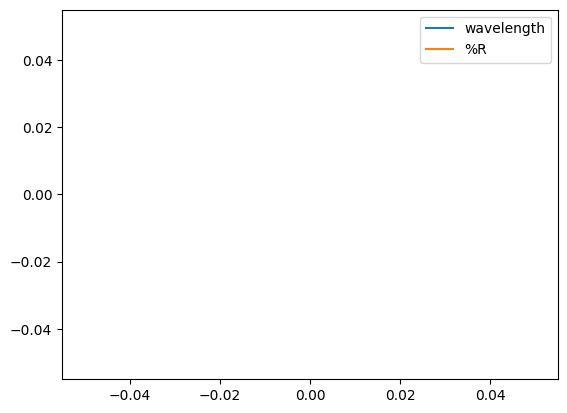

spectrum=<spectraltools.Spectrum object at 0x0000024F74263FE0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=50    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736458L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

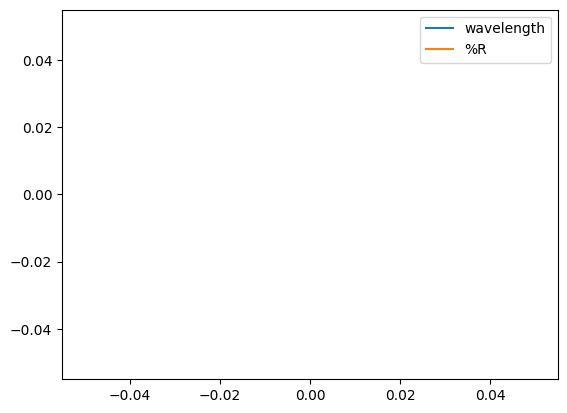

spectrum=<spectraltools.Spectrum object at 0x0000024F74541400>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=51    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736459L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

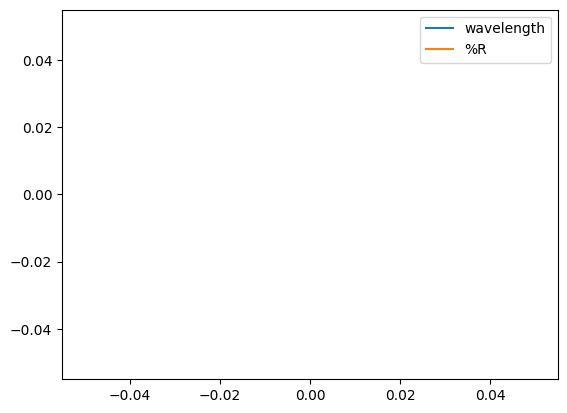

spectrum=<spectraltools.Spectrum object at 0x0000024F745C1F70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=72    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

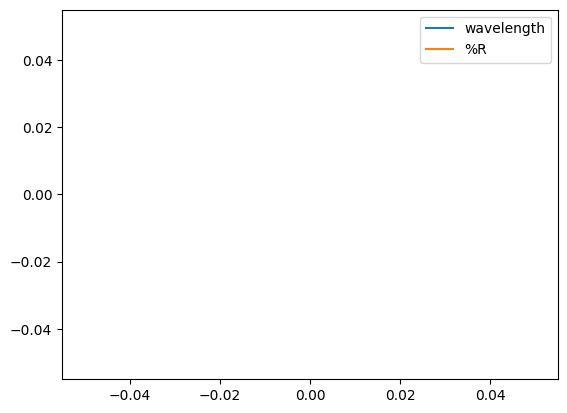

spectrum=<spectraltools.Spectrum object at 0x0000024F74474950>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=52    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195354L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

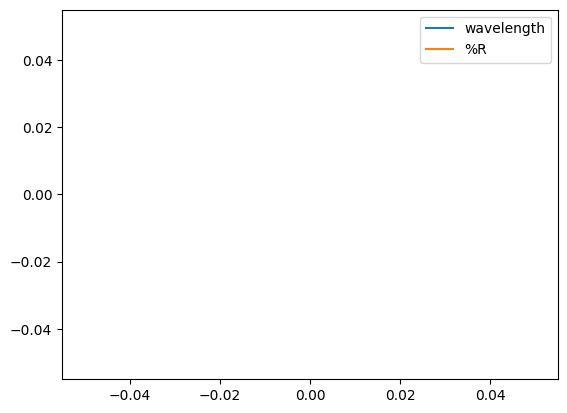

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F74542C60>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=53    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

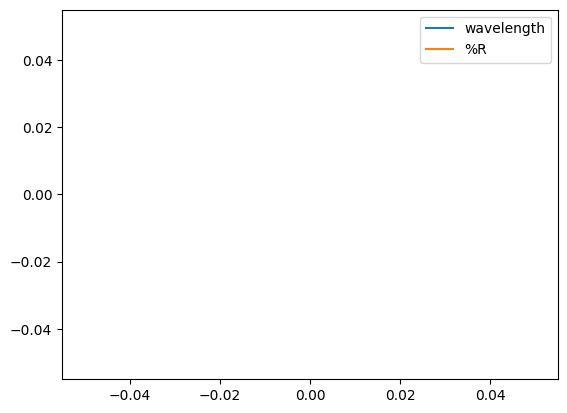

spectrum=<spectraltools.Spectrum object at 0x0000024F7314F380>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=54    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195357L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

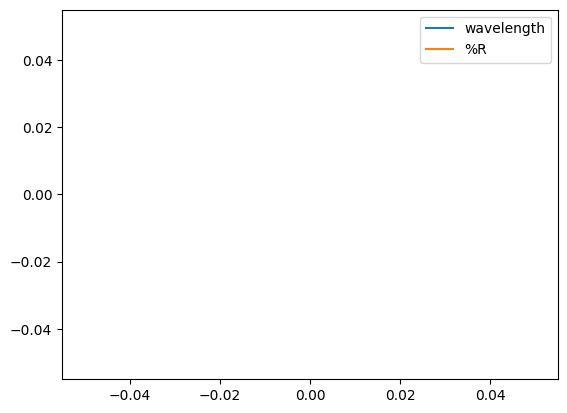

spectrum=<spectraltools.Spectrum object at 0x0000024F745422A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=55    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195358L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

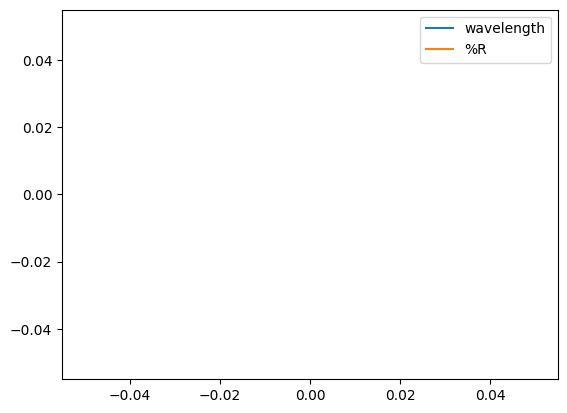

spectrum=<spectraltools.Spectrum object at 0x0000024F72EC3C20>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=56    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

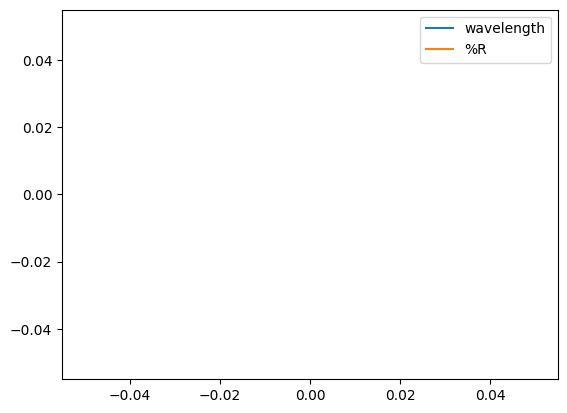

spectrum=<spectraltools.Spectrum object at 0x0000024F72EC3E00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=26    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2248544L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

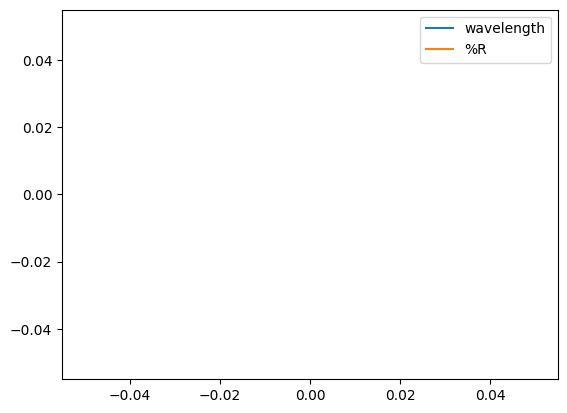

spectrum=<spectraltools.Spectrum object at 0x0000024F7432FCB0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=27    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249504L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

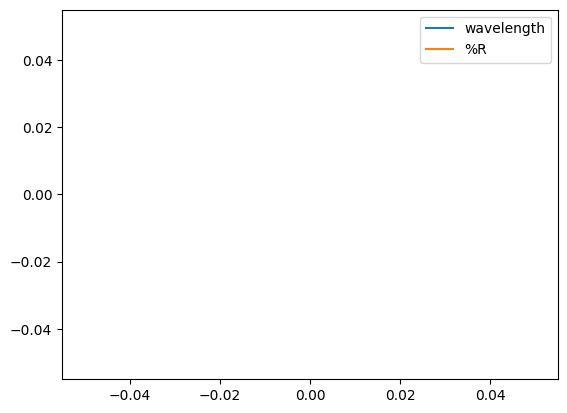

spectrum=<spectraltools.Spectrum object at 0x0000024F74346DB0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=28    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

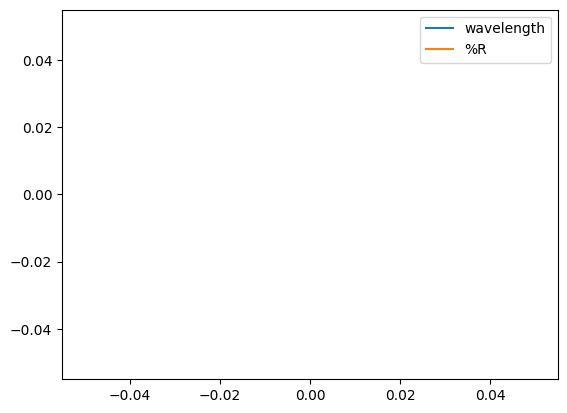

spectrum=<spectraltools.Spectrum object at 0x0000024F72F73320>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=29    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

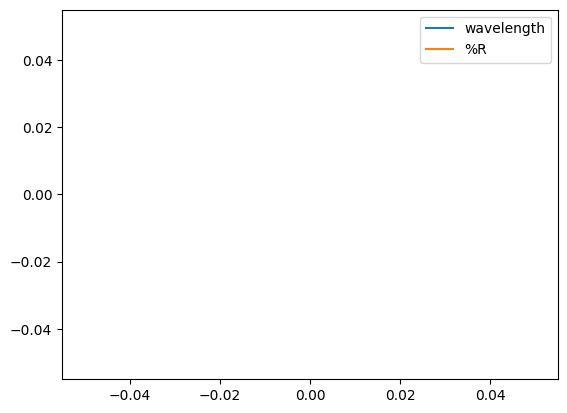

spectrum=<spectraltools.Spectrum object at 0x0000024F72EA3DD0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=30    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2361339L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

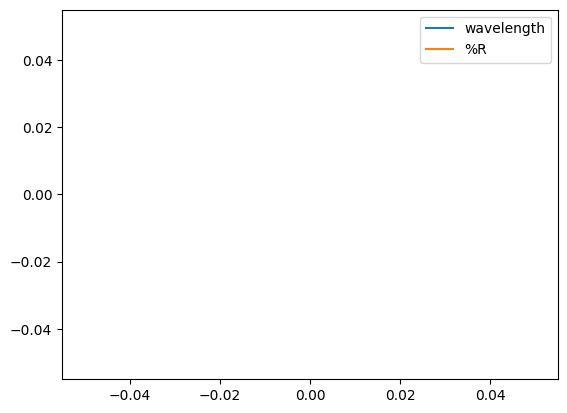

spectrum=<spectraltools.Spectrum object at 0x0000024F74346E70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=31    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

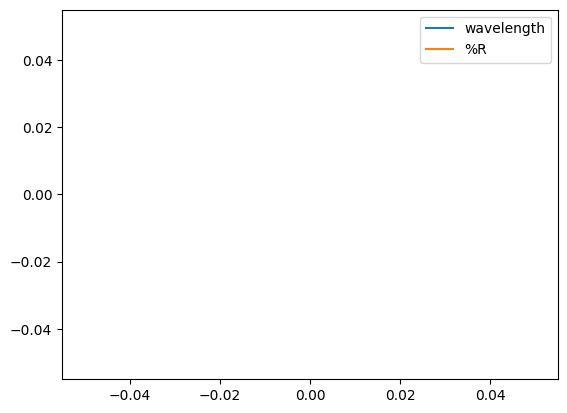

spectrum=<spectraltools.Spectrum object at 0x0000024F72C4E5A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

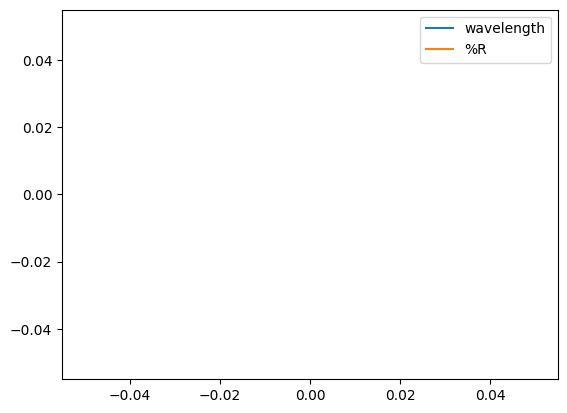

spectrum=<spectraltools.Spectrum object at 0x0000024F72F3DE20>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

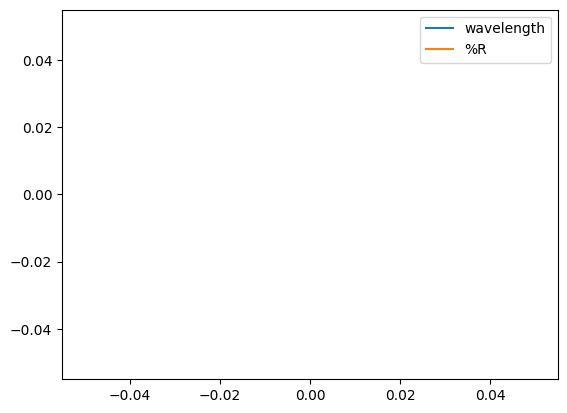

spectrum=<spectraltools.Spectrum object at 0x0000024F74346D20>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=34    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388550L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

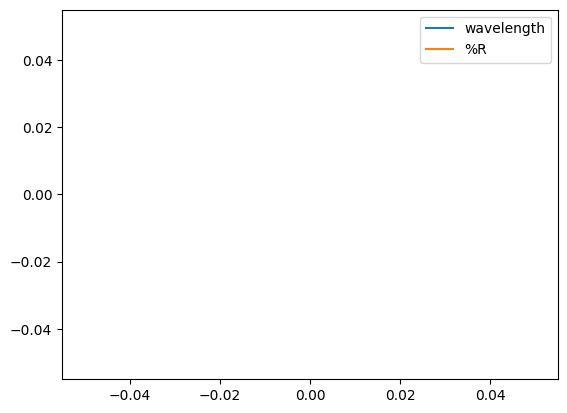

spectrum=<spectraltools.Spectrum object at 0x0000024F72FDE120>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=35    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388554L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

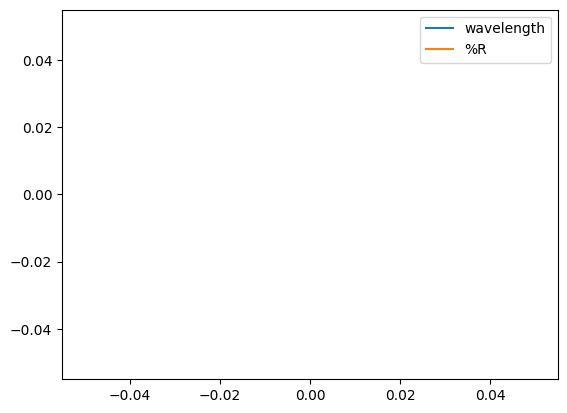

spectrum=<spectraltools.Spectrum object at 0x0000024F731B37D0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=36    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

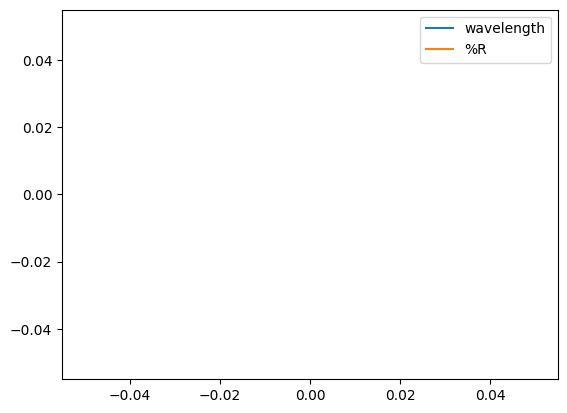

spectrum=<spectraltools.Spectrum object at 0x0000024F7316FC80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=37    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

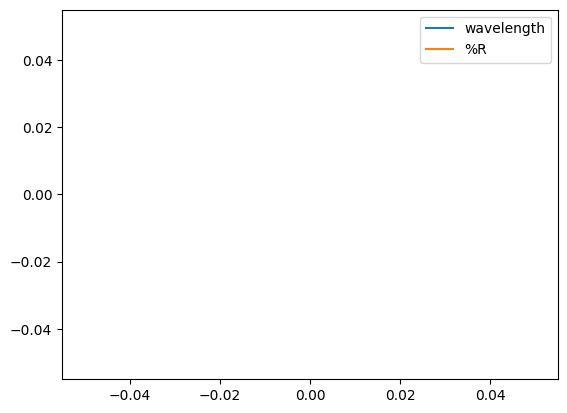

spectrum=<spectraltools.Spectrum object at 0x0000024F7314E000>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=38    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2452030L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

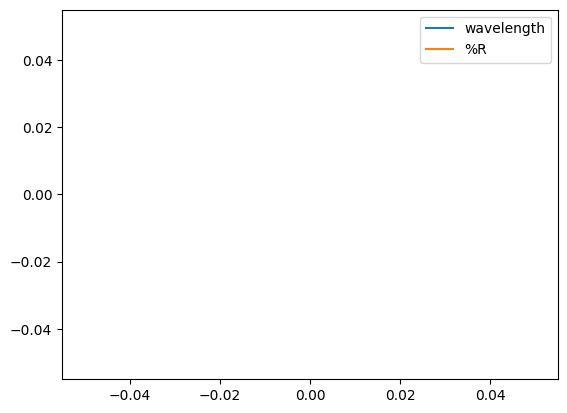

spectrum=<spectraltools.Spectrum object at 0x0000024F743D16D0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=39    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2453057L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

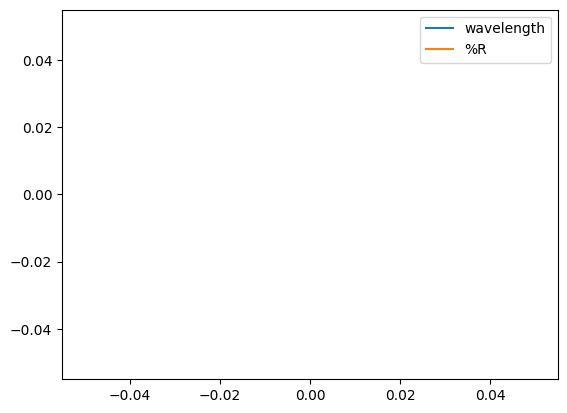

spectrum=<spectraltools.Spectrum object at 0x0000024F73007EF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=57    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2456006L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

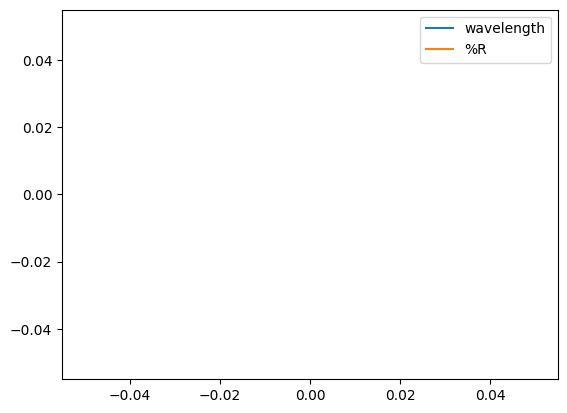

spectrum=<spectraltools.Spectrum object at 0x0000024F72D52BD0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=40    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2467329L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

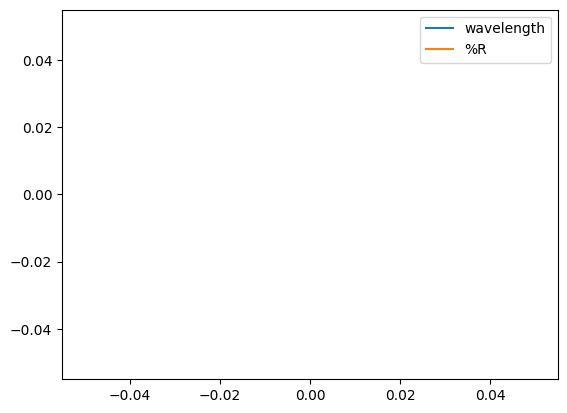

spectrum=<spectraltools.Spectrum object at 0x0000024F72D9D070>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=58    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2548659L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

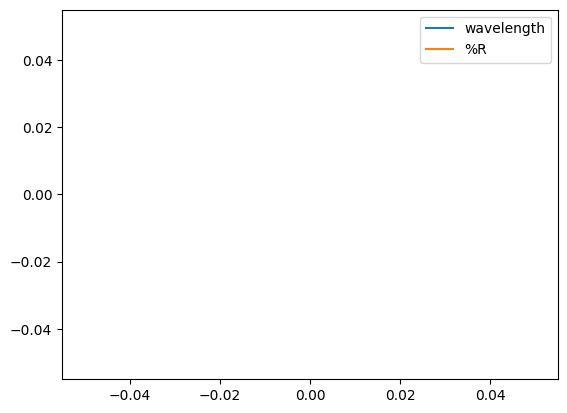

spectrum=<spectraltools.Spectrum object at 0x0000024F742A4B00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=59    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\3036568L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

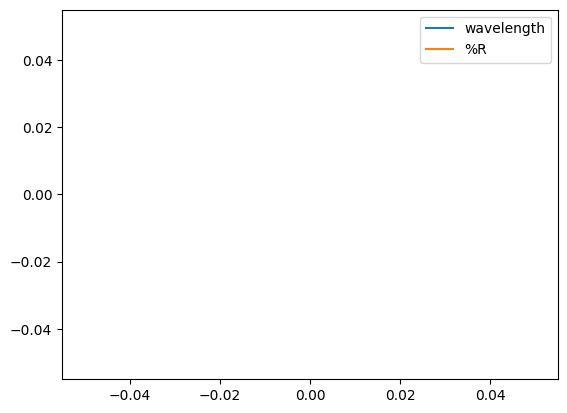

spectrum=<spectraltools.Spectrum object at 0x0000024F72F10C50>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

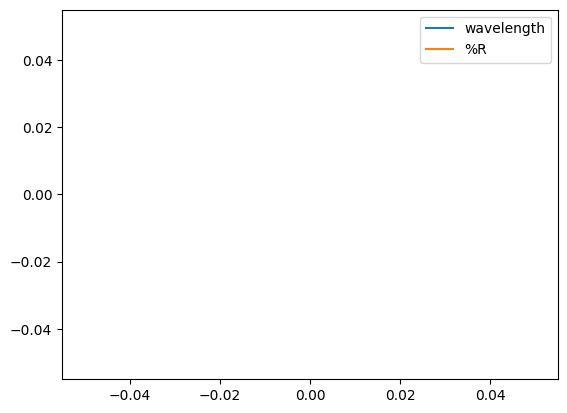

spectrum=<spectraltools.Spectrum object at 0x0000024F72C2E9F0>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

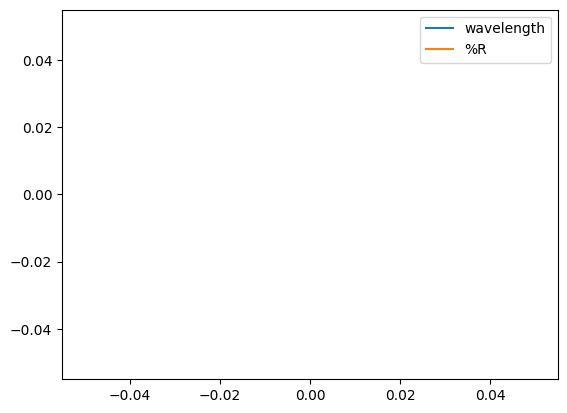

spectrum=<spectraltools.Spectrum object at 0x0000024F72C7C890>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

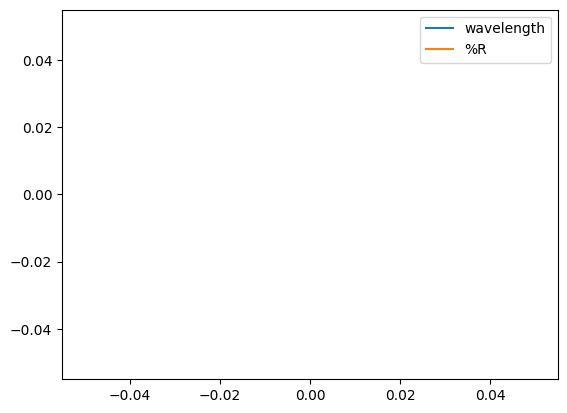

spectrum=<spectraltools.Spectrum object at 0x0000024F72F2BDD0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

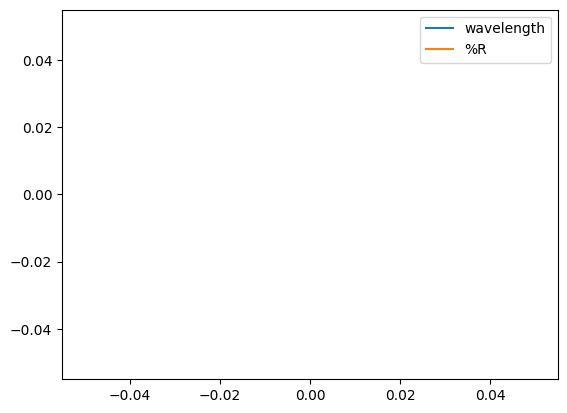

spectrum=<spectraltools.Spectrum object at 0x0000024F72CE4F50>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

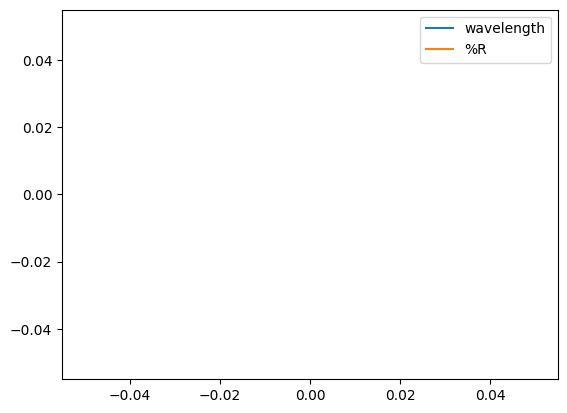

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72E5A750>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

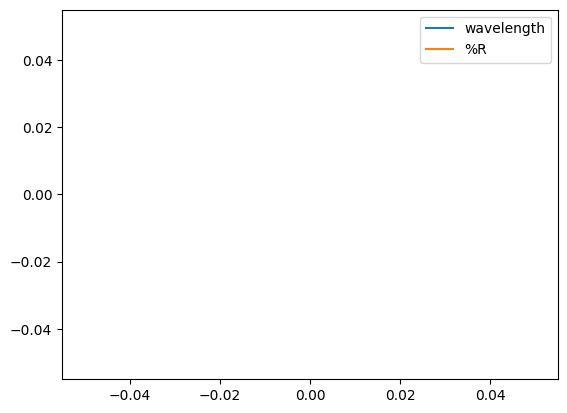

spectrum=<spectraltools.Spectrum object at 0x0000024F743D2E10>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

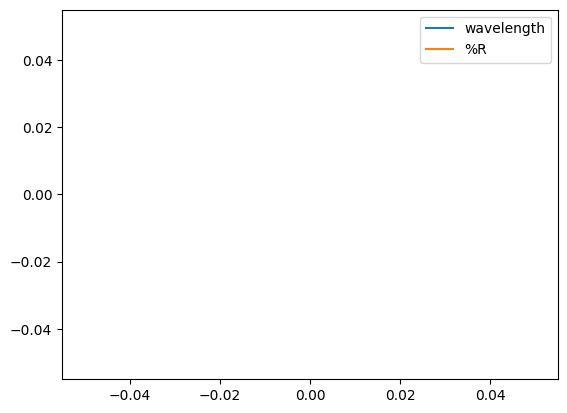

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72F3E180>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

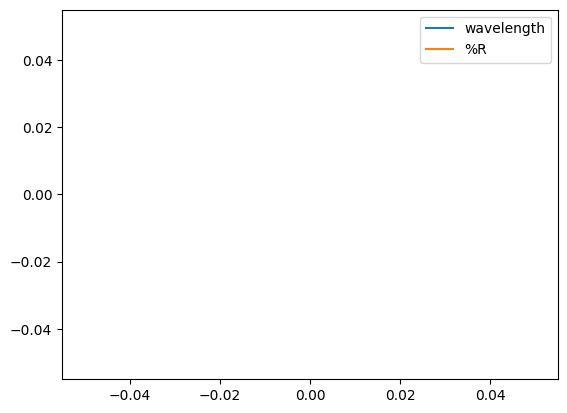

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F730E5460>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

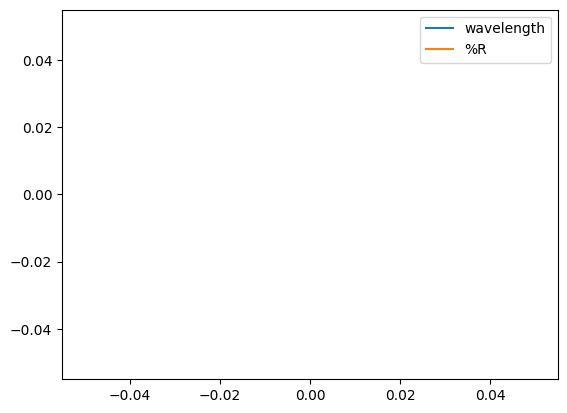

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72F8E210>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

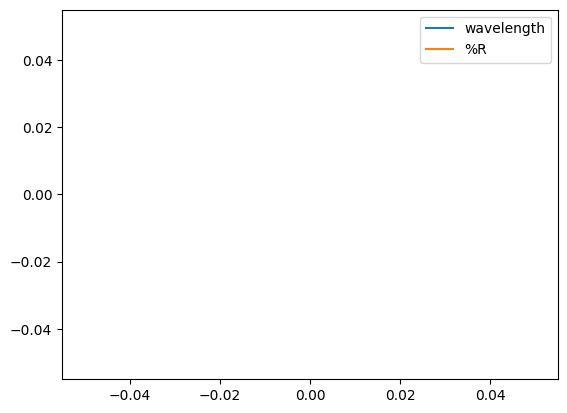

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F7432E5A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

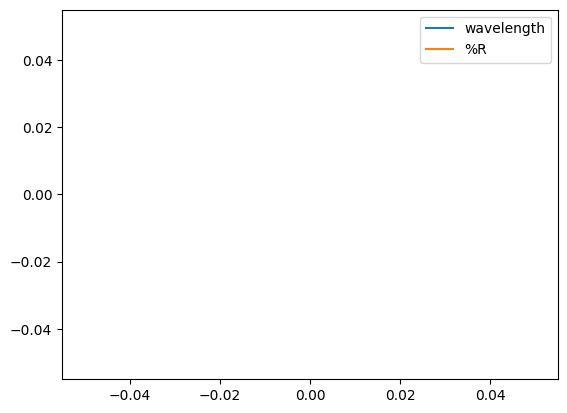

spectrum=<spectraltools.Spectrum object at 0x0000024F72F73620>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

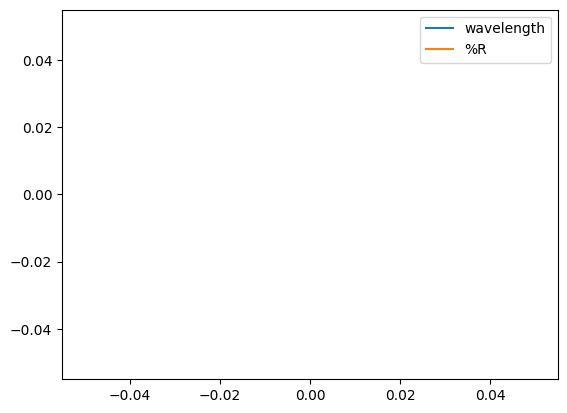

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72D71400>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

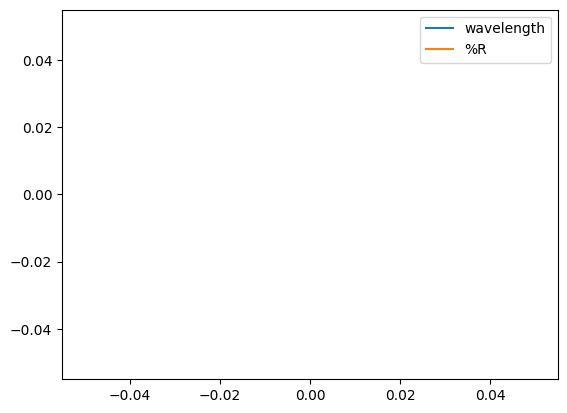

spectrum=<spectraltools.Spectrum object at 0x0000024F730FE7E0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

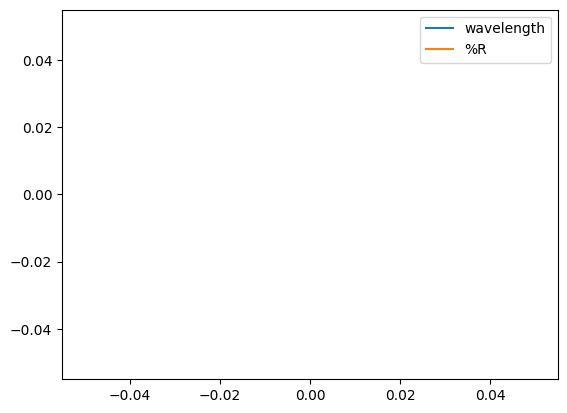

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72C7D760>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

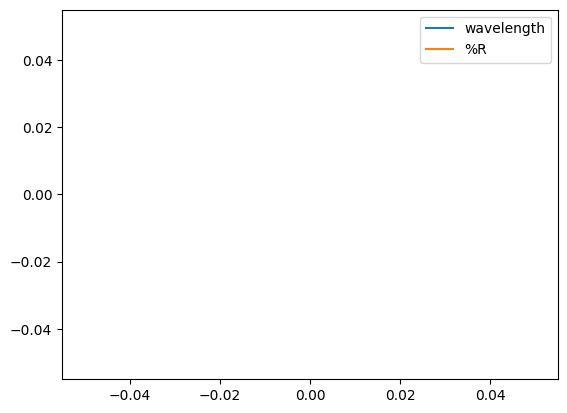

spectrum=<spectraltools.Spectrum object at 0x0000024F72E59700>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

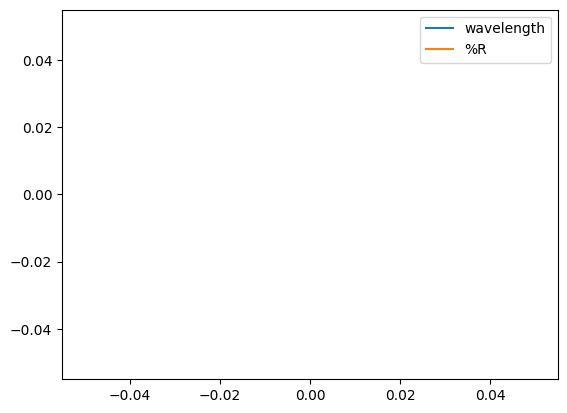

spectrum=<spectraltools.Spectrum object at 0x0000024F72C2D5B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

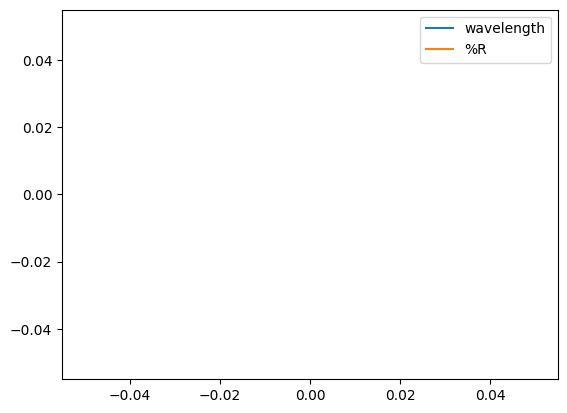

spectrum=<spectraltools.Spectrum object at 0x0000024F745F60C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

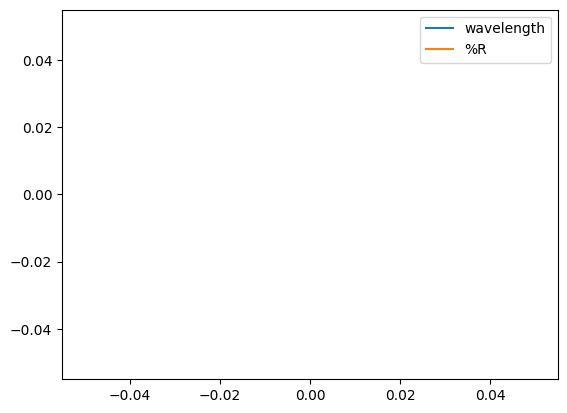

spectrum=<spectraltools.Spectrum object at 0x0000024F72F8D940>
Average Craic
Create spectrum from file
Collection lookup
INBIO
Genus specimen=71    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

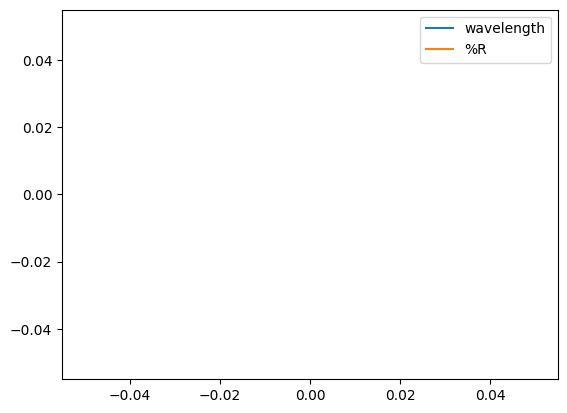

spectrum=<spectraltools.Spectrum object at 0x0000024F72C99940>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=49    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

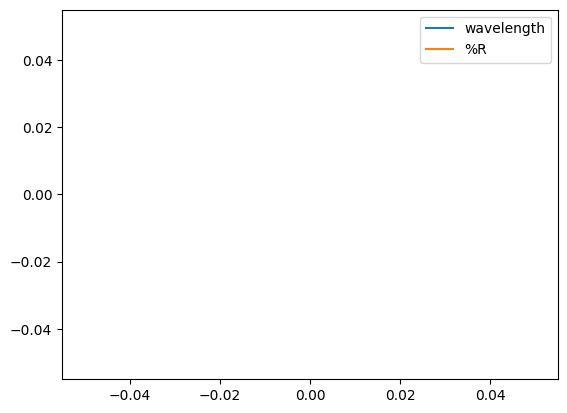

spectrum=<spectraltools.Spectrum object at 0x0000024F72EA06B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=50    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736458L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

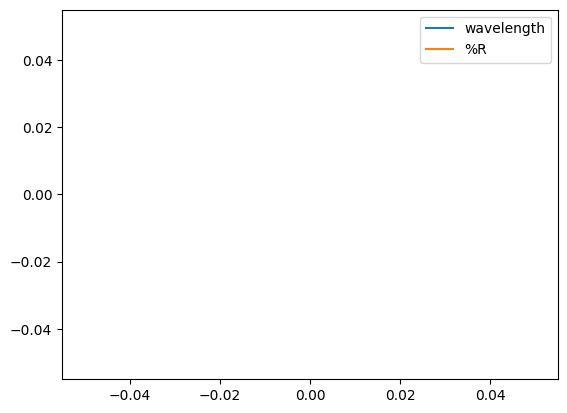

spectrum=<spectraltools.Spectrum object at 0x0000024F743E8B30>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=51    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736459L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

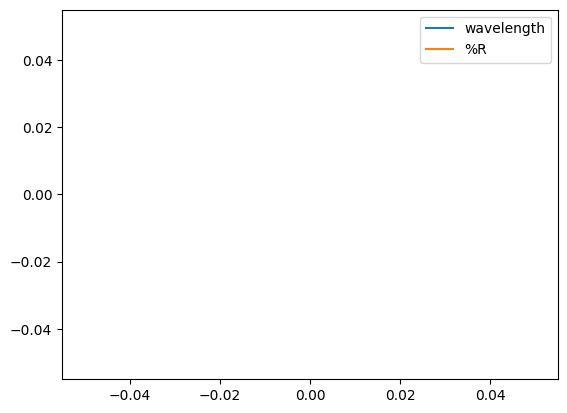

spectrum=<spectraltools.Spectrum object at 0x0000024F72F13500>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=72    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

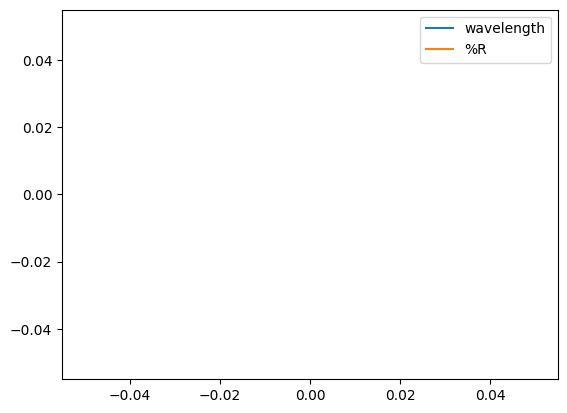

spectrum=<spectraltools.Spectrum object at 0x0000024F74482480>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=52    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195354L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

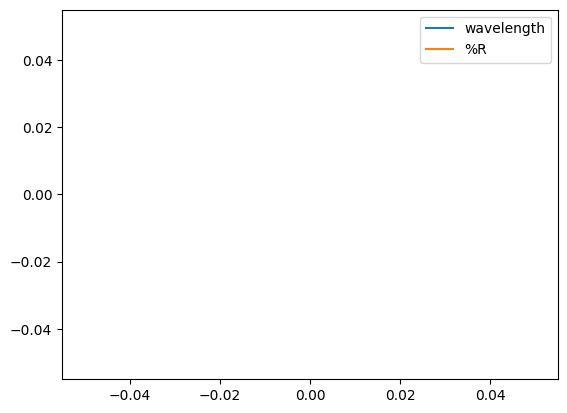

spectrum=<spectraltools.Spectrum object at 0x0000024F72FA65D0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=53    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

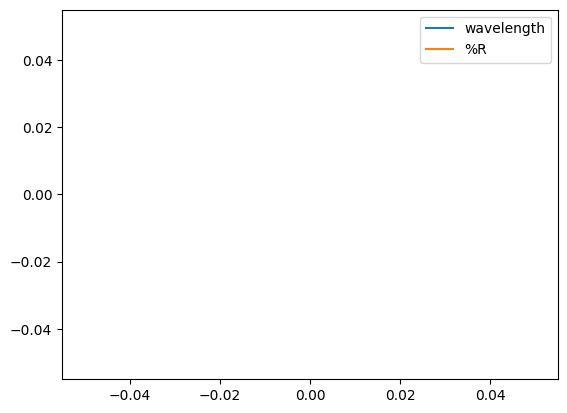

spectrum=<spectraltools.Spectrum object at 0x0000024F7456AB10>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195357L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=54    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

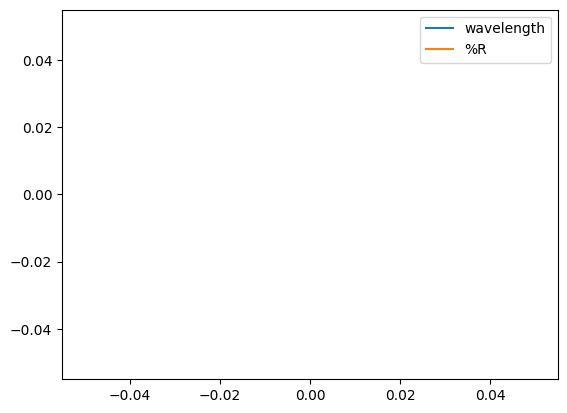

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195358L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72F3CB00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=55    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

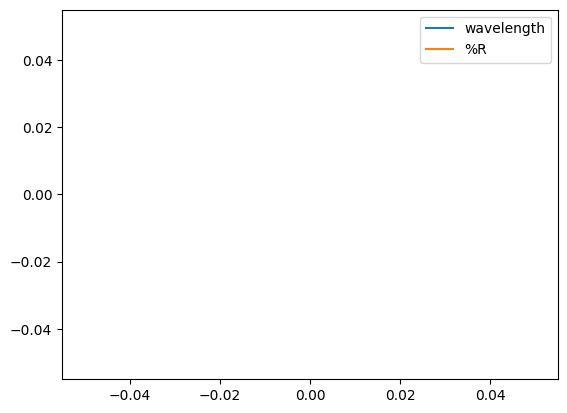

spectrum=<spectraltools.Spectrum object at 0x0000024F73006480>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=56    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

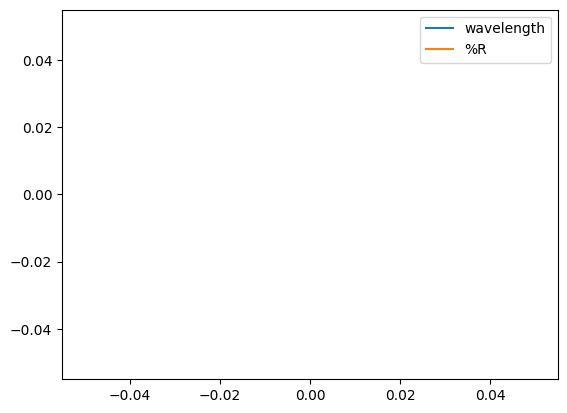

spectrum=<spectraltools.Spectrum object at 0x0000024F72FA5880>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=26    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2248544L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

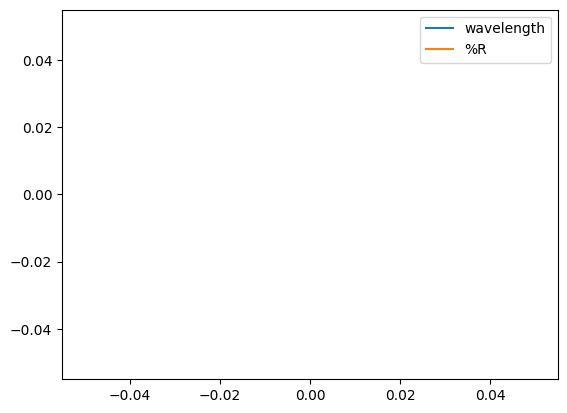

spectrum=<spectraltools.Spectrum object at 0x0000024F72B7B2F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=27    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249504L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

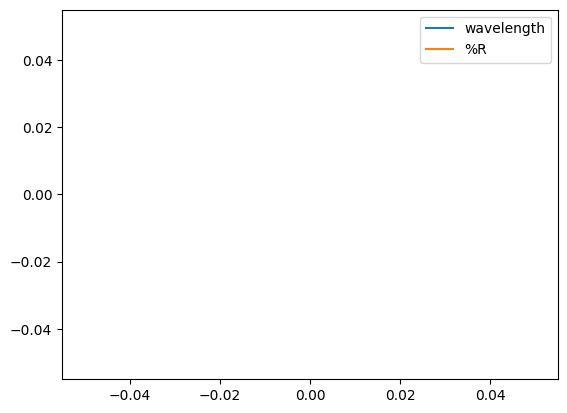

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72BA2A80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=28    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

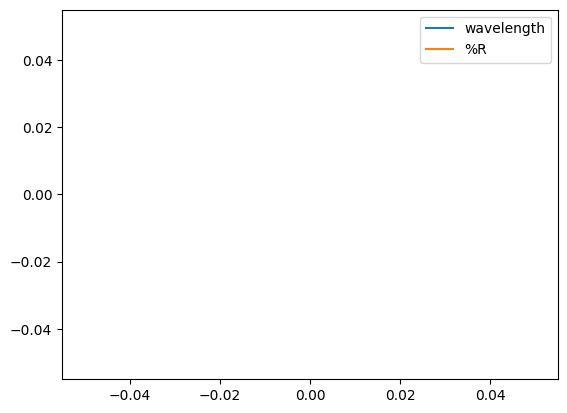

spectrum=<spectraltools.Spectrum object at 0x0000024F72BE0EF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=29    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

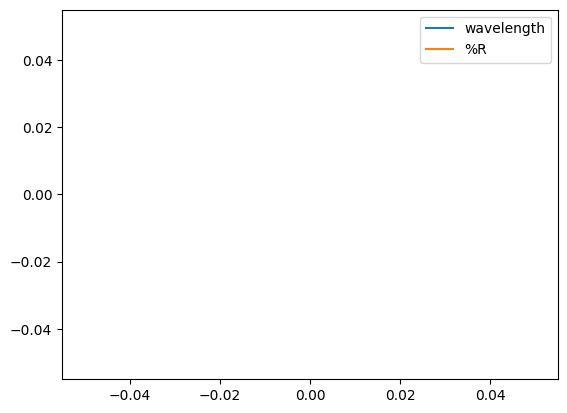

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2361339L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F731186E0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=30    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

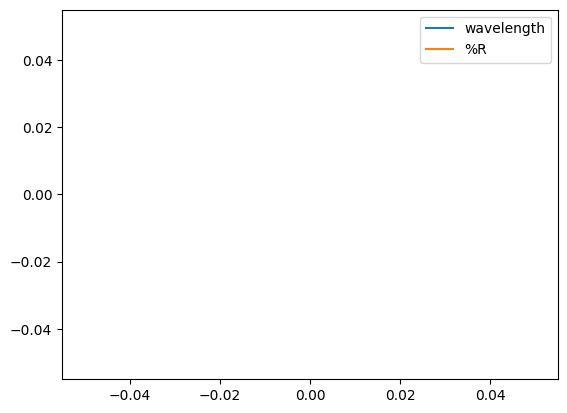

spectrum=<spectraltools.Spectrum object at 0x0000024F72BA0FB0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=31    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

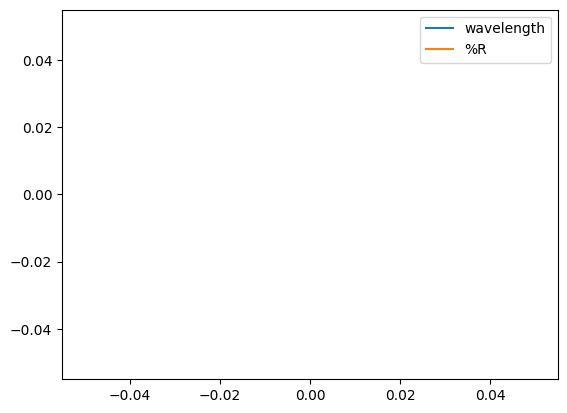

spectrum=<spectraltools.Spectrum object at 0x0000024F72BE2900>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

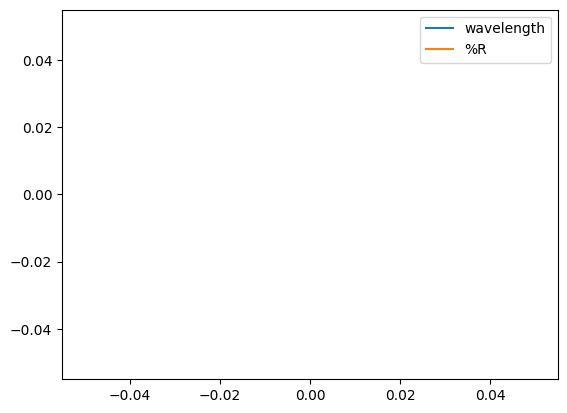

spectrum=<spectraltools.Spectrum object at 0x0000024F7312D340>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

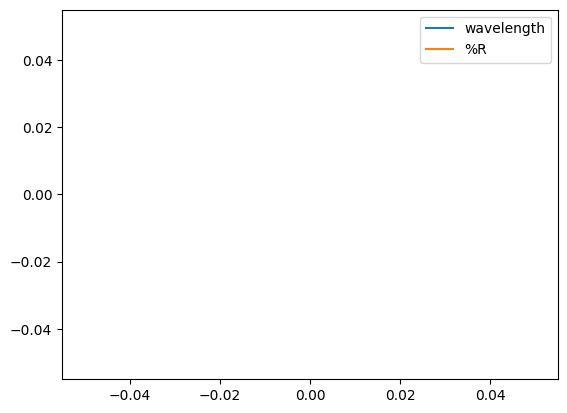

spectrum=<spectraltools.Spectrum object at 0x0000024F72F3E450>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=34    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388550L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

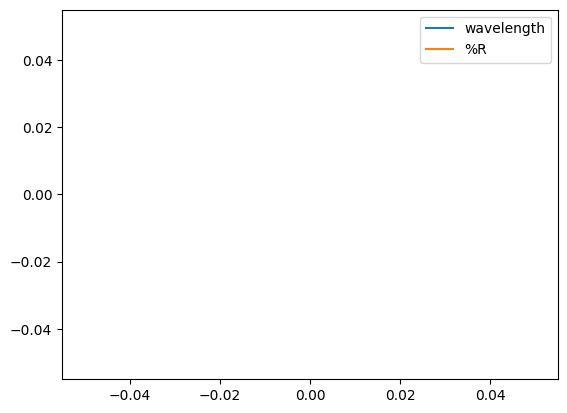

spectrum=<spectraltools.Spectrum object at 0x0000024F74569310>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=35    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388554L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

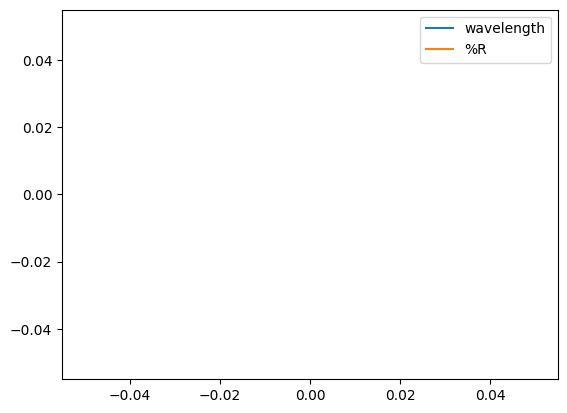

spectrum=<spectraltools.Spectrum object at 0x0000024F7427F500>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=36    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

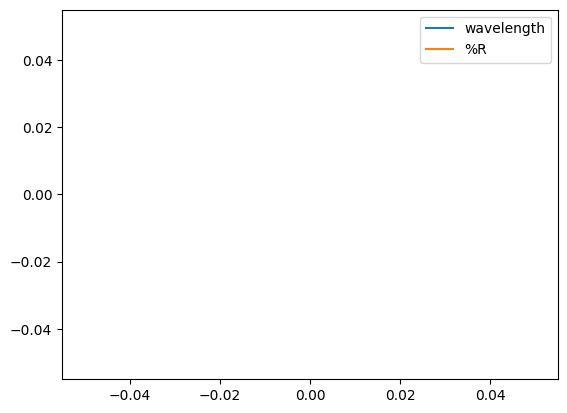

spectrum=<spectraltools.Spectrum object at 0x0000024F72F3E8A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=37    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

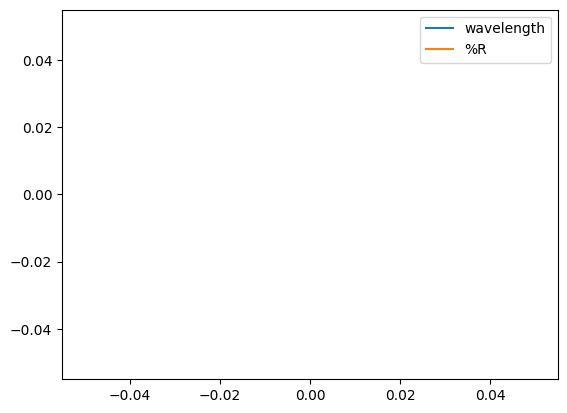

spectrum=<spectraltools.Spectrum object at 0x0000024F72F71670>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=38    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2452030L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

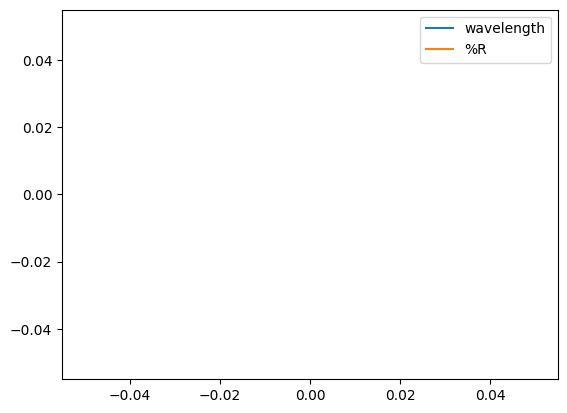

spectrum=<spectraltools.Spectrum object at 0x0000024F72F28DD0>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2453057L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=39    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

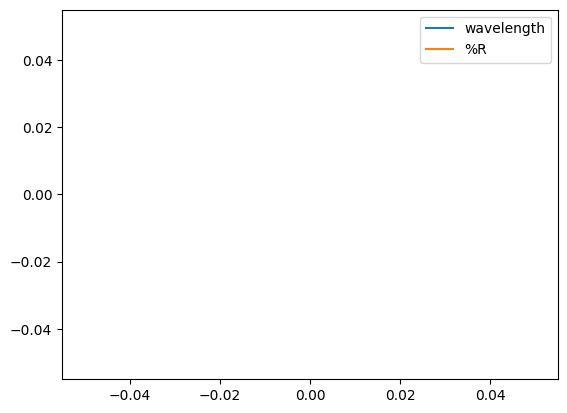

spectrum=<spectraltools.Spectrum object at 0x0000024F72C98560>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=57    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2456006L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

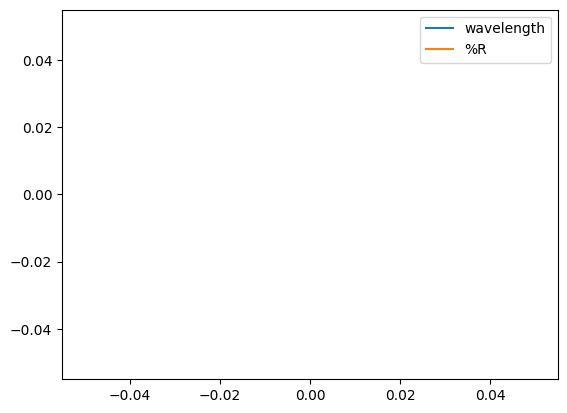

spectrum=<spectraltools.Spectrum object at 0x0000024F72DB5850>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=40    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2467329L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

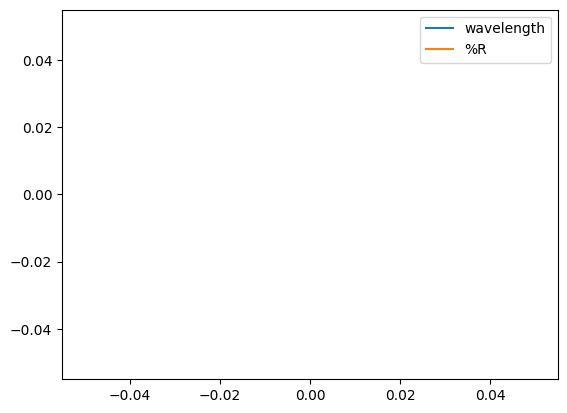

spectrum=<spectraltools.Spectrum object at 0x0000024F72D9E5A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=58    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2548659L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

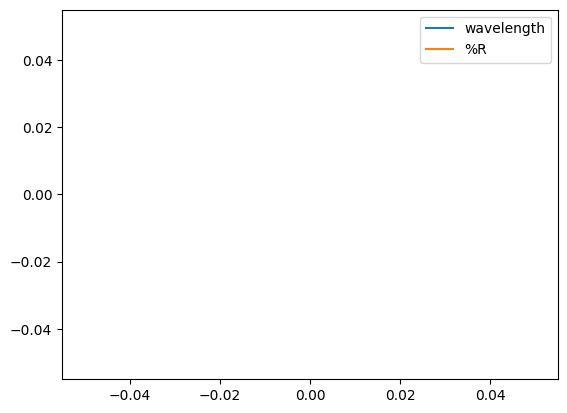

spectrum=<spectraltools.Spectrum object at 0x0000024F72C4CA70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=59    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\3036568L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

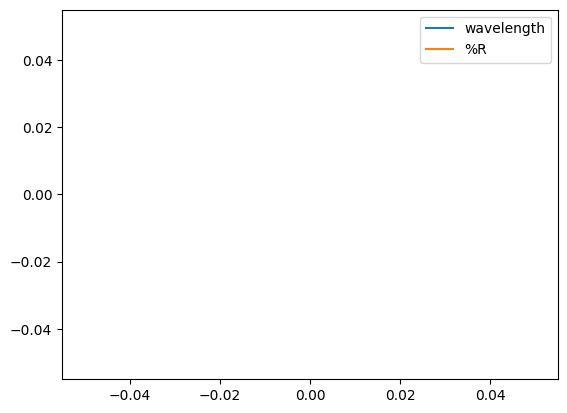

spectrum=<spectraltools.Spectrum object at 0x0000024F74345760>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

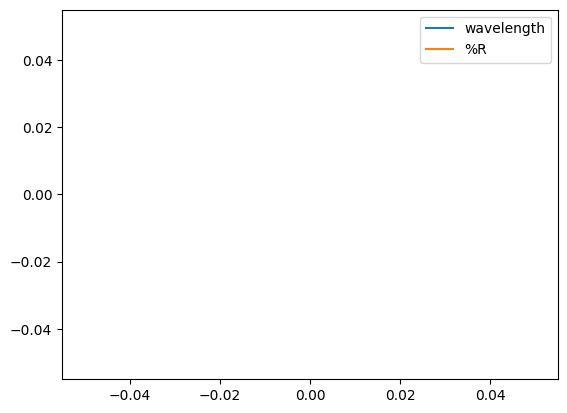

spectrum=<spectraltools.Spectrum object at 0x0000024F7316E780>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

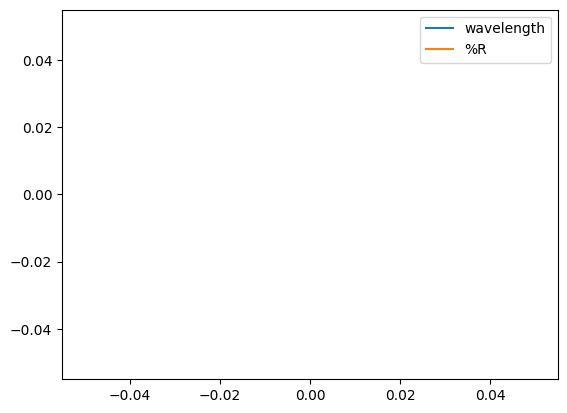

spectrum=<spectraltools.Spectrum object at 0x0000024F72F3D460>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

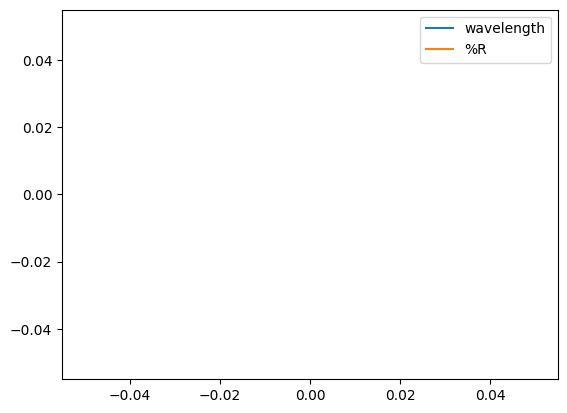

spectrum=<spectraltools.Spectrum object at 0x0000024F73119DC0>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

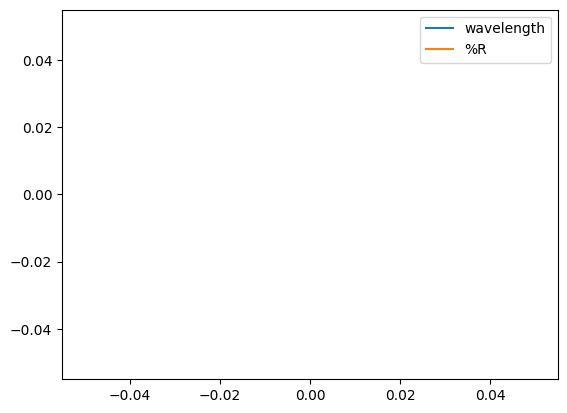

spectrum=<spectraltools.Spectrum object at 0x0000024F72E1B3B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

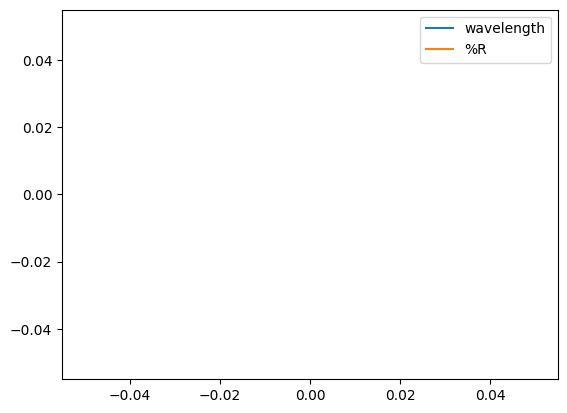

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F745C1DC0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

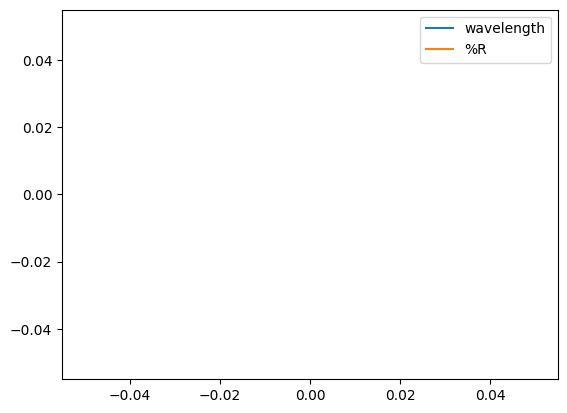

spectrum=<spectraltools.Spectrum object at 0x0000024F74522A20>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

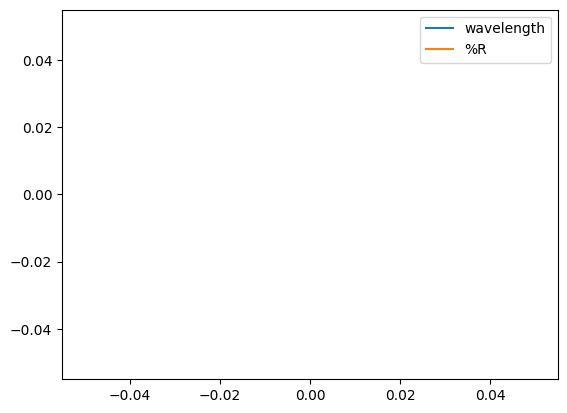

spectrum=<spectraltools.Spectrum object at 0x0000024F730FC470>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

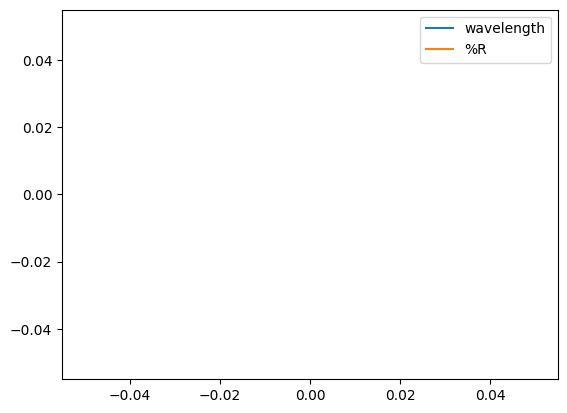

spectrum=<spectraltools.Spectrum object at 0x0000024F72F131A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

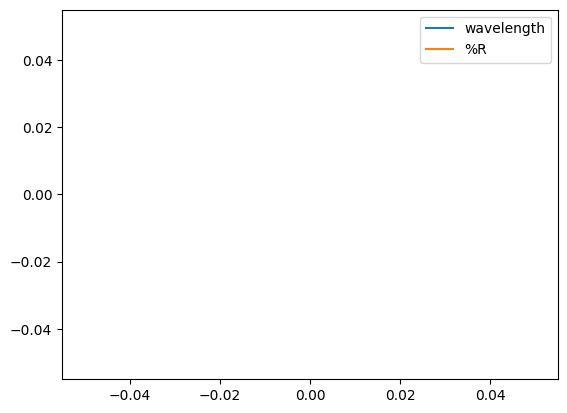

spectrum=<spectraltools.Spectrum object at 0x0000024F72D52DE0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

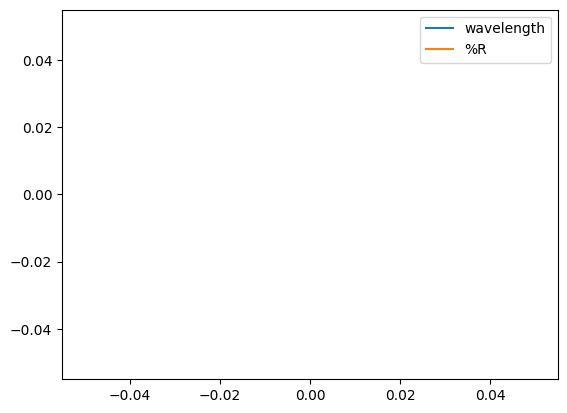

spectrum=<spectraltools.Spectrum object at 0x0000024F7314F410>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

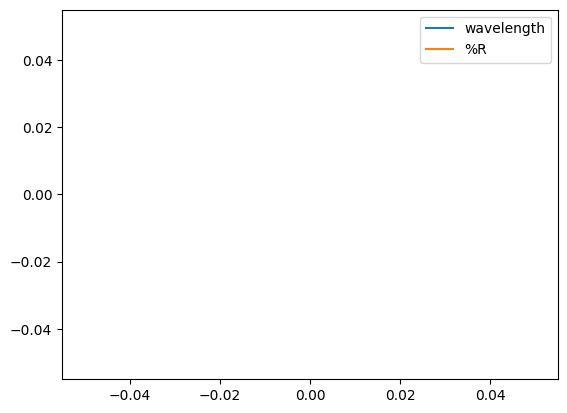

spectrum=<spectraltools.Spectrum object at 0x0000024F72F8E000>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

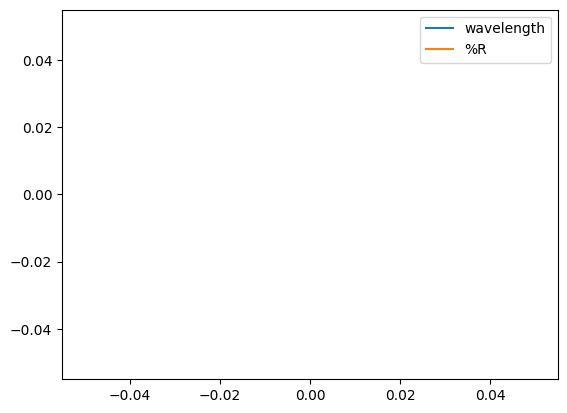

spectrum=<spectraltools.Spectrum object at 0x0000024F74262F00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

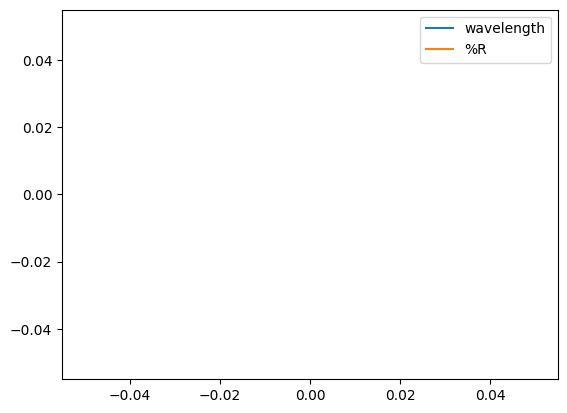

spectrum=<spectraltools.Spectrum object at 0x0000024F755F5E20>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=33    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

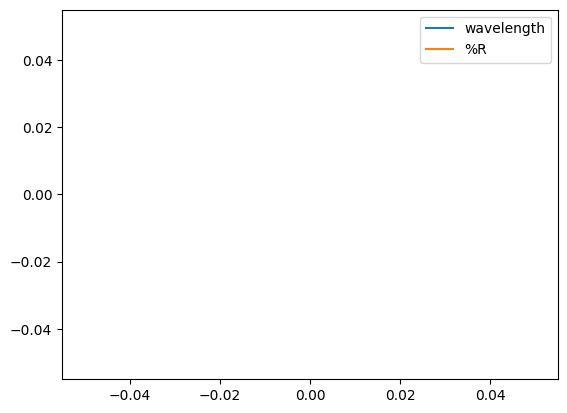

spectrum=<spectraltools.Spectrum object at 0x0000024F74480E00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

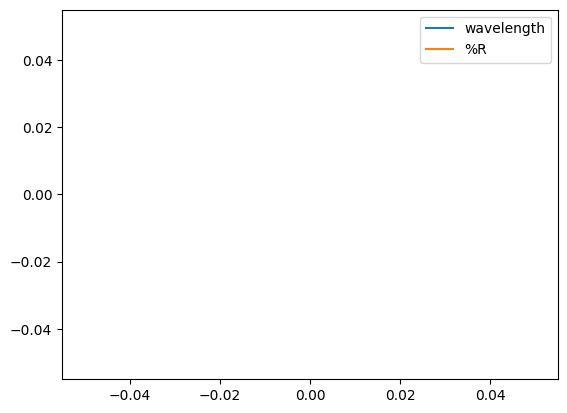

spectrum=<spectraltools.Spectrum object at 0x0000024F755F43B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

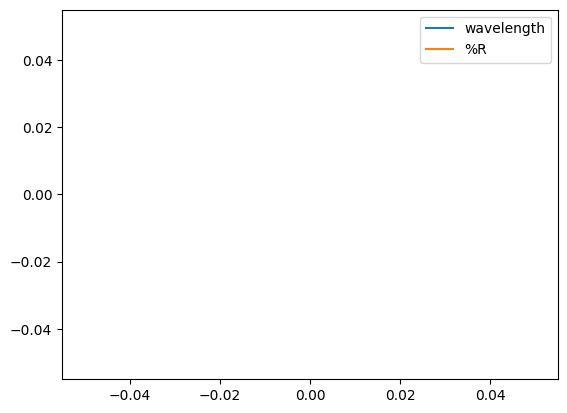

spectrum=<spectraltools.Spectrum object at 0x0000024F74313BF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

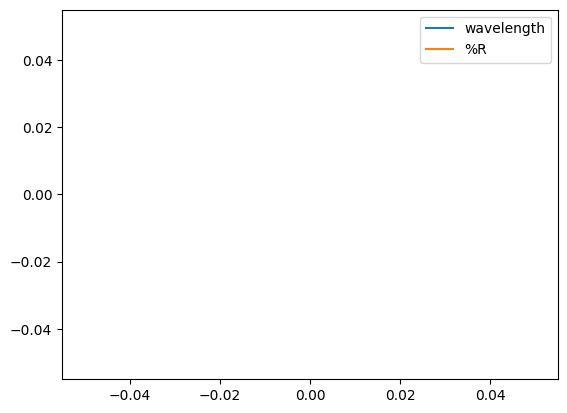

spectrum=<spectraltools.Spectrum object at 0x0000024F744760F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

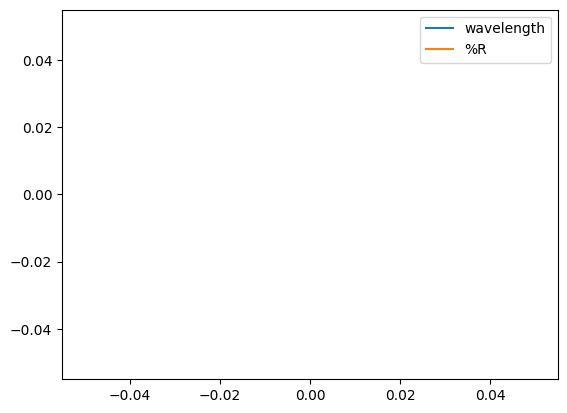

spectrum=<spectraltools.Spectrum object at 0x0000024F72D9FCB0>
right_average_df=Empty DataFrame
Columns: [wavelength, %R]
Index: []
left_average_df=Empty DataFrame
Columns: [wavelength, %R]
Index: []
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

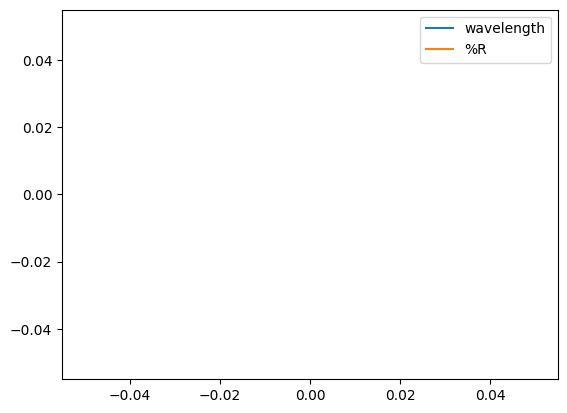

spectrum=<spectraltools.Spectrum object at 0x0000024F72DB43B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

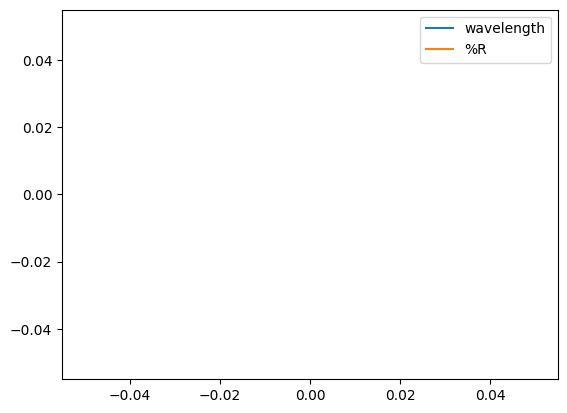

spectrum=<spectraltools.Spectrum object at 0x0000024F755F5E80>
right_pol=['..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R4.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R5.csv']
left_pol=['..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L4.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L5.csv']
no_polarization=[]
Average Craic
Create spectrum from file
Collection lookup
INBIO
Gen

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

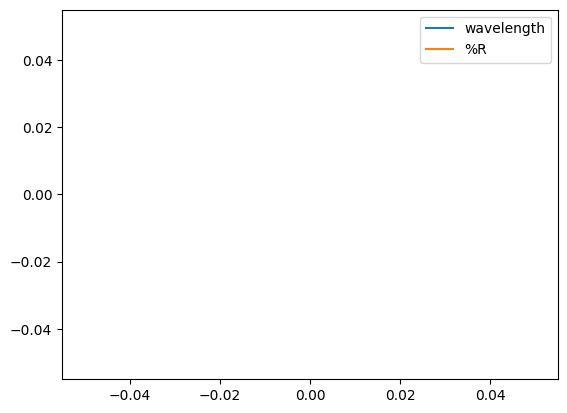

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F745238C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=49    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

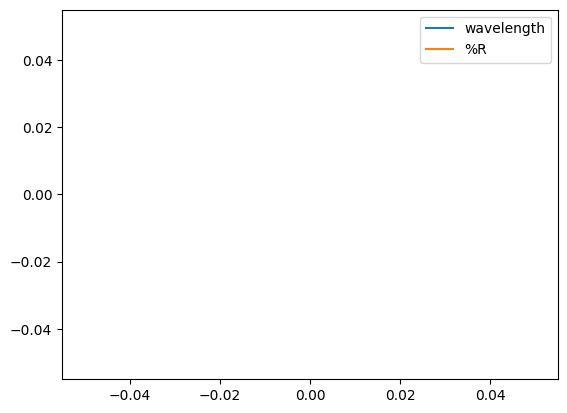

spectrum=<spectraltools.Spectrum object at 0x0000024F72EC3620>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=50    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736458L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

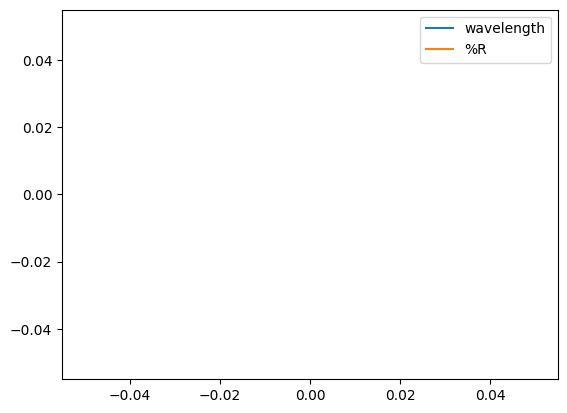

spectrum=<spectraltools.Spectrum object at 0x0000024F7427F5F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=51    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736459L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

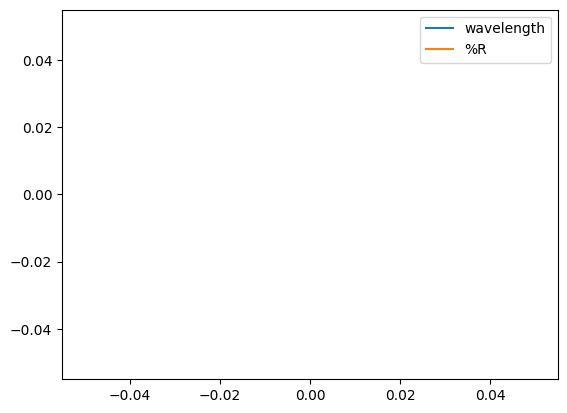

spectrum=<spectraltools.Spectrum object at 0x0000024F72EEB2C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=72    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

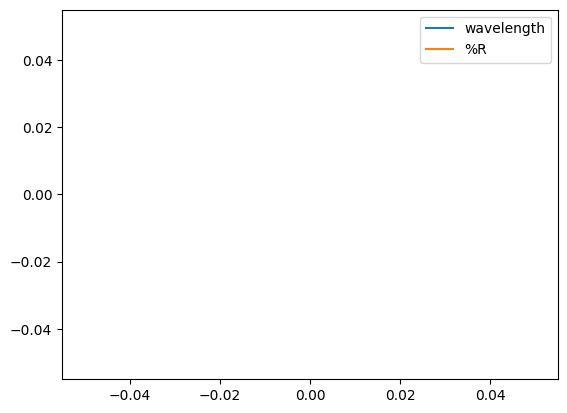

spectrum=<spectraltools.Spectrum object at 0x0000024F72C7DAC0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=52    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195354L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

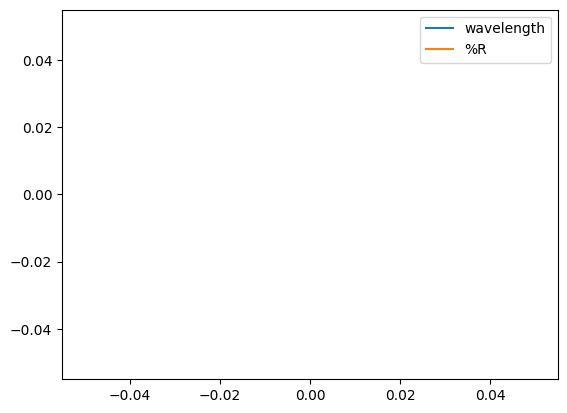

spectrum=<spectraltools.Spectrum object at 0x0000024F75619880>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=53    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

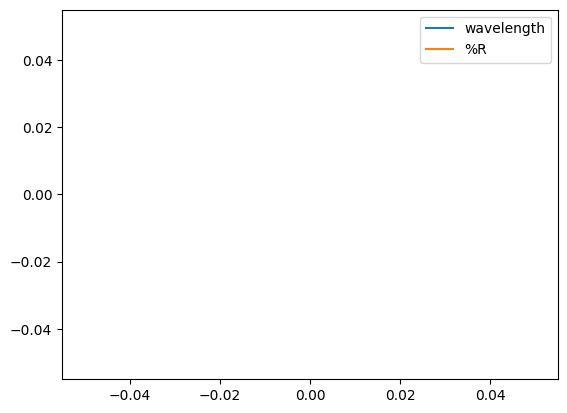

spectrum=<spectraltools.Spectrum object at 0x0000024F72B785F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=54    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195357L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

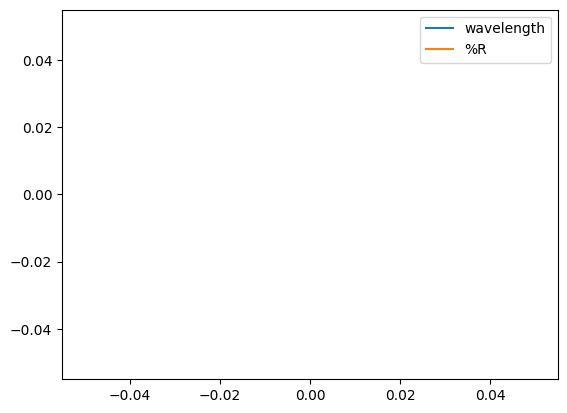

spectrum=<spectraltools.Spectrum object at 0x0000024F72EA0140>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=55    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195358L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

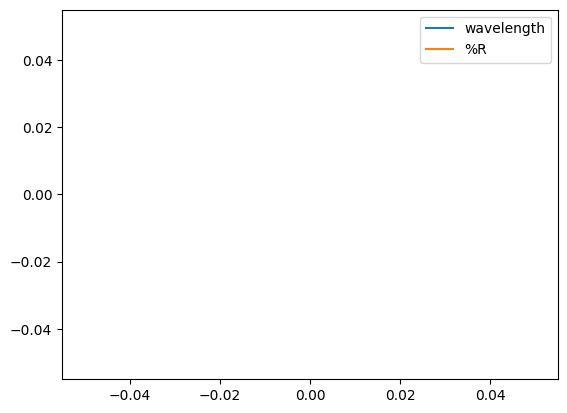

spectrum=<spectraltools.Spectrum object at 0x0000024F730E64B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=56    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

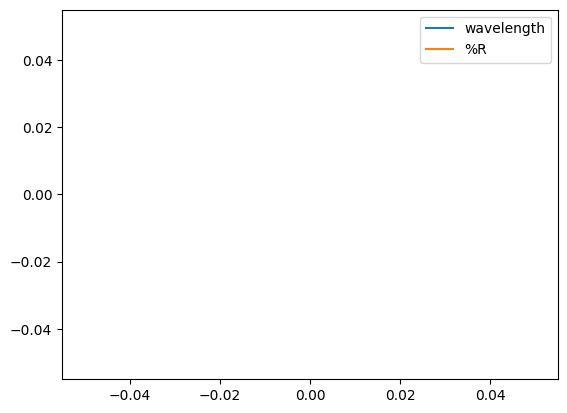

spectrum=<spectraltools.Spectrum object at 0x0000024F7561A930>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=26    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2248544L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

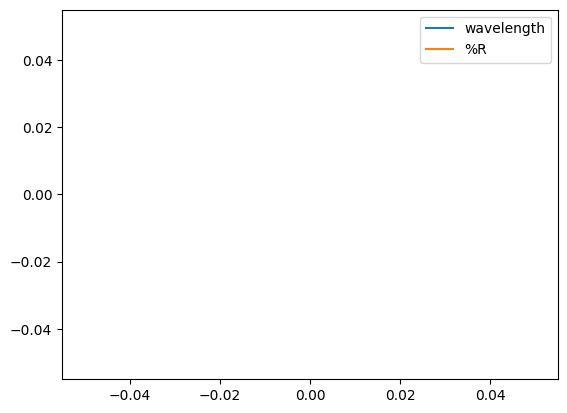

spectrum=<spectraltools.Spectrum object at 0x0000024F72C2FFE0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=27    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249504L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

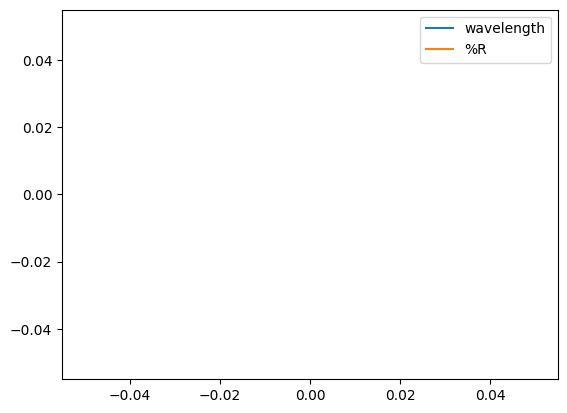

spectrum=<spectraltools.Spectrum object at 0x0000024F72F12A80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=28    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

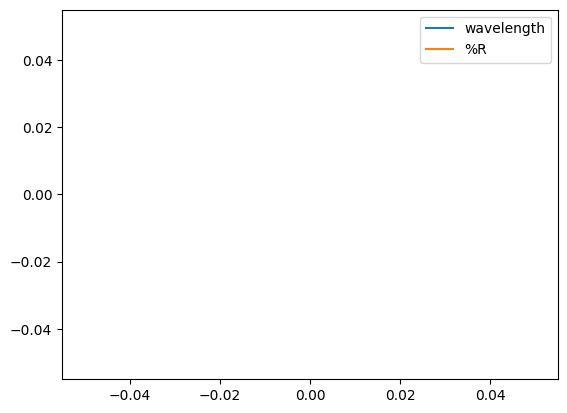

spectrum=<spectraltools.Spectrum object at 0x0000024F72BA1700>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=29    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

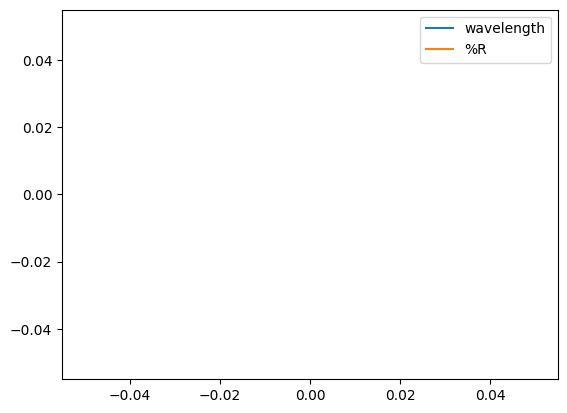

spectrum=<spectraltools.Spectrum object at 0x0000024F7427F1A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=30    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2361339L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

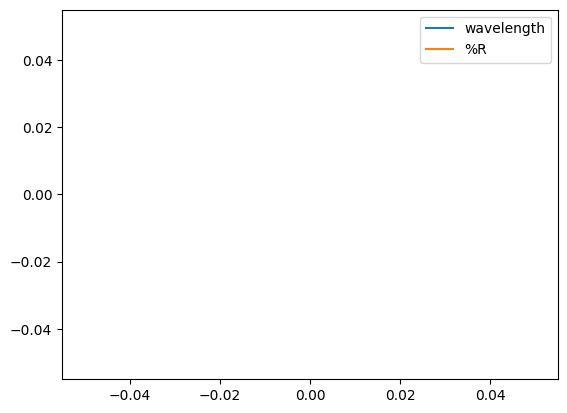

spectrum=<spectraltools.Spectrum object at 0x0000024F74500F20>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=31    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

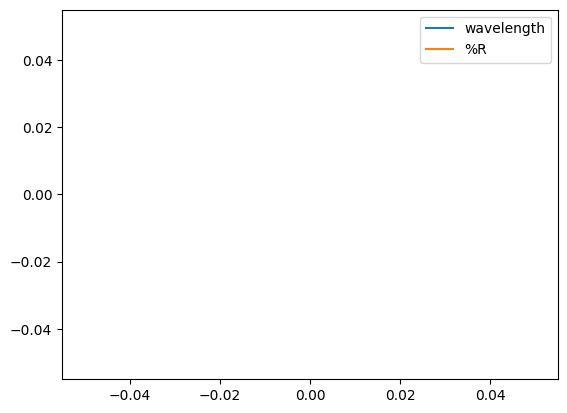

spectrum=<spectraltools.Spectrum object at 0x0000024F72CBDE20>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

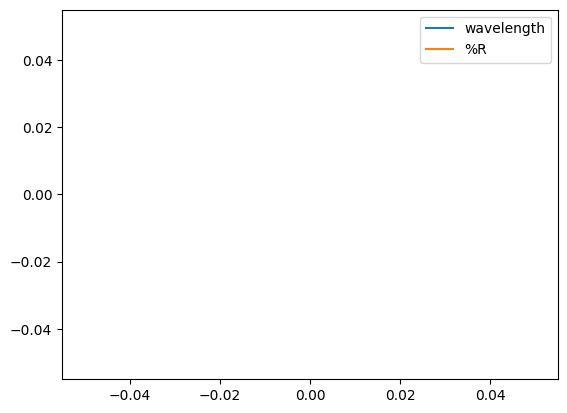

spectrum=<spectraltools.Spectrum object at 0x0000024F741EC080>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

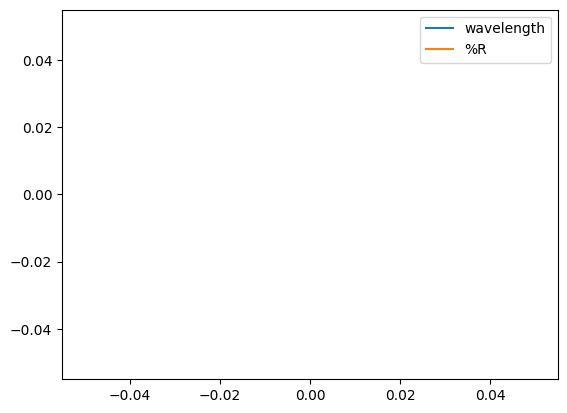

spectrum=<spectraltools.Spectrum object at 0x0000024F74587920>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=34    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388550L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

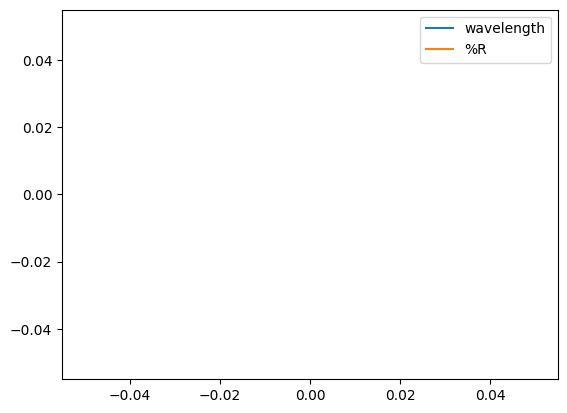

spectrum=<spectraltools.Spectrum object at 0x0000024F72F3F830>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=35    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388554L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

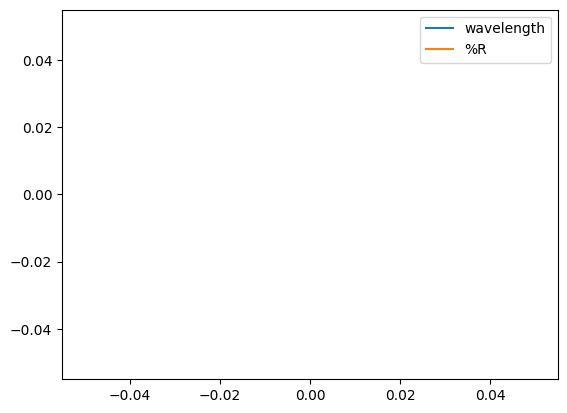

spectrum=<spectraltools.Spectrum object at 0x0000024F72B78740>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=36    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

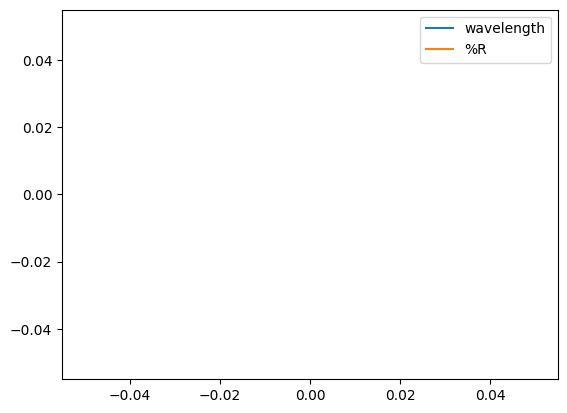

spectrum=<spectraltools.Spectrum object at 0x0000024F72B0EDE0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=37    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

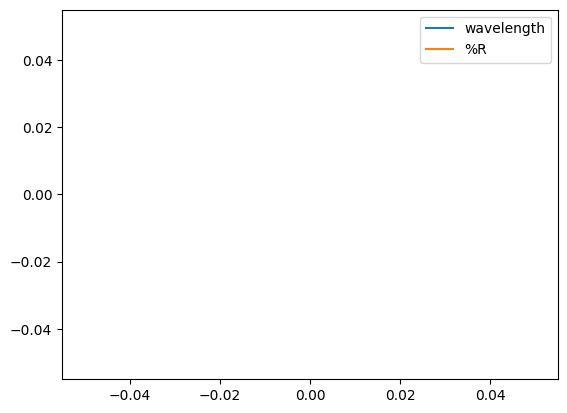

spectrum=<spectraltools.Spectrum object at 0x0000024F730FC9E0>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2452030L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=38    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

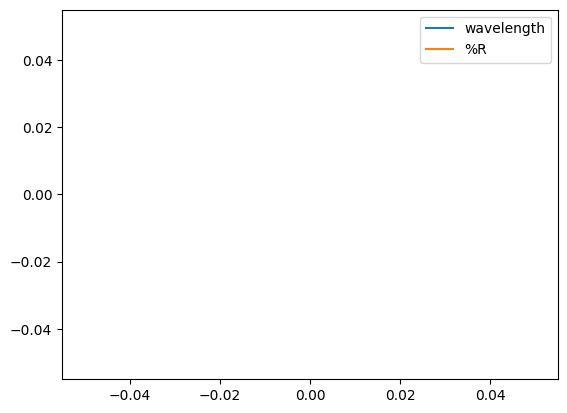

spectrum=<spectraltools.Spectrum object at 0x0000024F72EA1700>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2453057L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=39    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

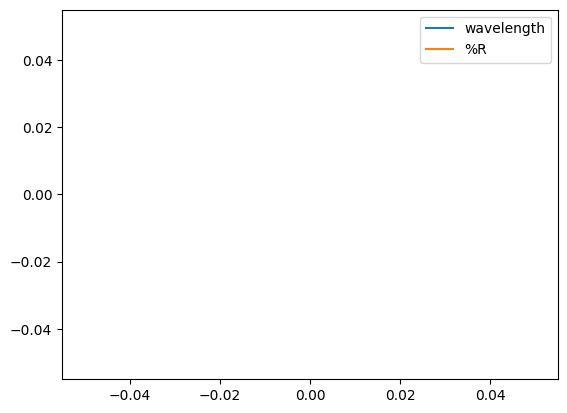

spectrum=<spectraltools.Spectrum object at 0x0000024F72BA3DA0>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2456006L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=57    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

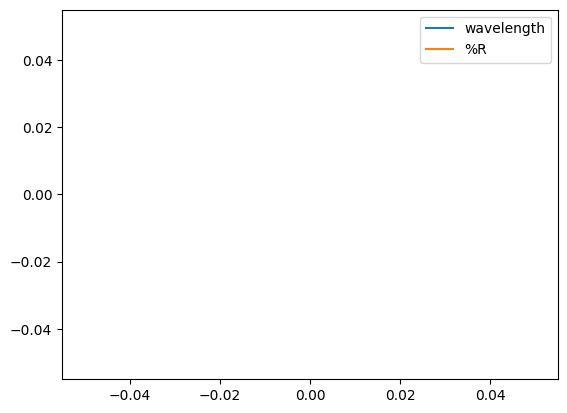

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2467329L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72BA3050>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=40    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

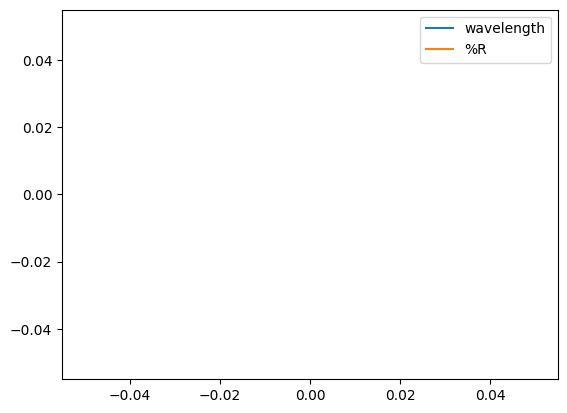

spectrum=<spectraltools.Spectrum object at 0x0000024F74311D90>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=58    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2548659L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

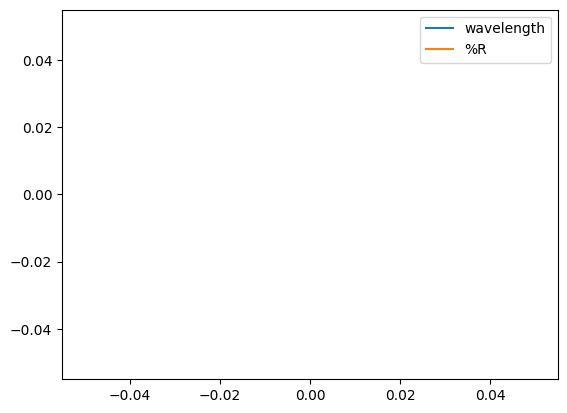

spectrum=<spectraltools.Spectrum object at 0x0000024F74374EF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=59    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\3036568L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

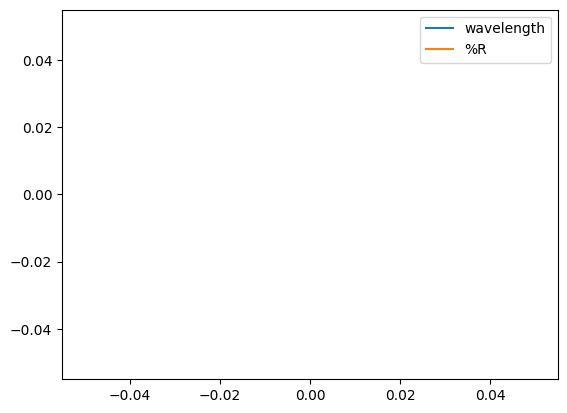

spectrum=<spectraltools.Spectrum object at 0x0000024F72CBD520>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

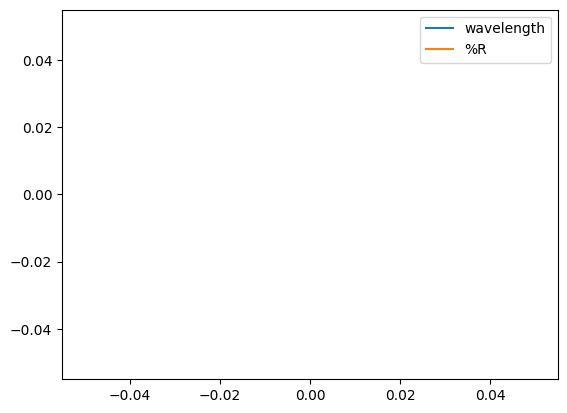

spectrum=<spectraltools.Spectrum object at 0x0000024F743E8A70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

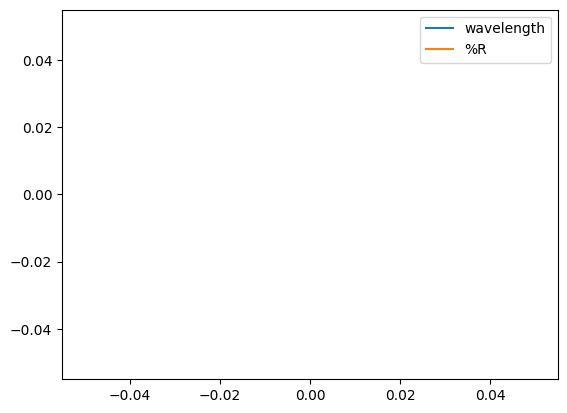

spectrum=<spectraltools.Spectrum object at 0x0000024F731B1B50>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

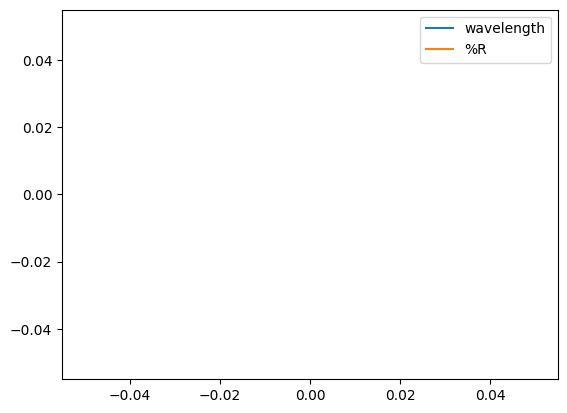

spectrum=<spectraltools.Spectrum object at 0x0000024F72F13890>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

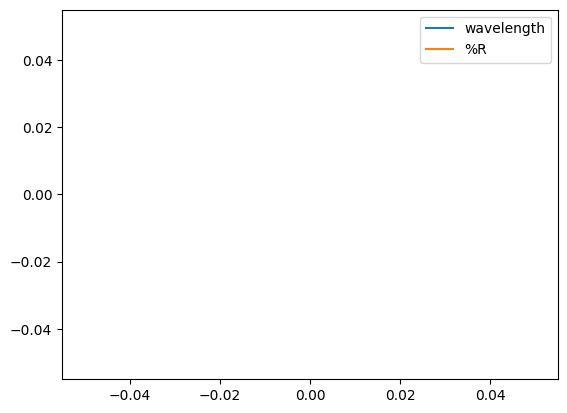

spectrum=<spectraltools.Spectrum object at 0x0000024F72F2AF00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

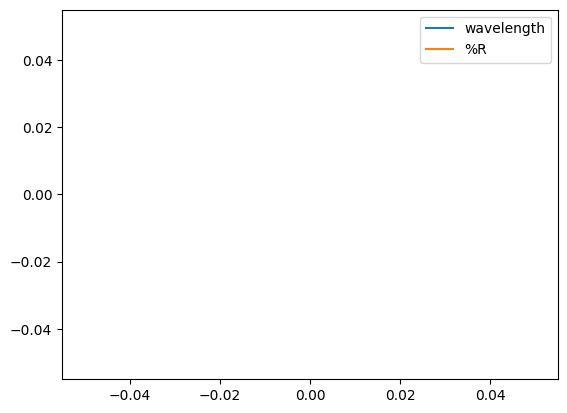

spectrum=<spectraltools.Spectrum object at 0x0000024F72C7ED50>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

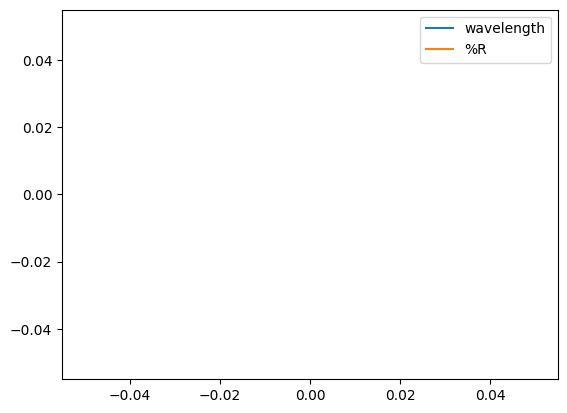

spectrum=<spectraltools.Spectrum object at 0x0000024F741EEA50>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

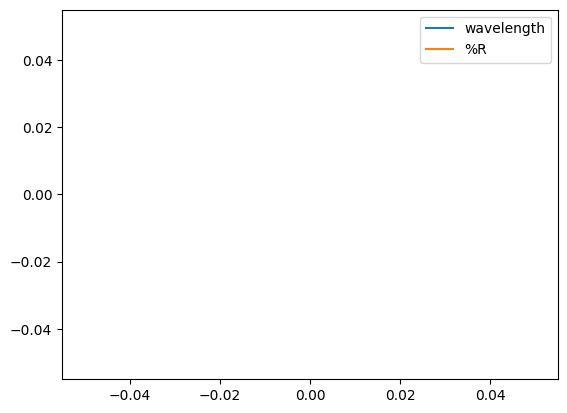

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72AC0F80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

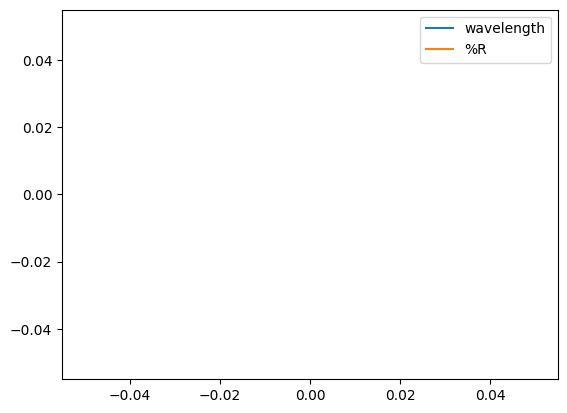

spectrum=<spectraltools.Spectrum object at 0x0000024F73050620>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

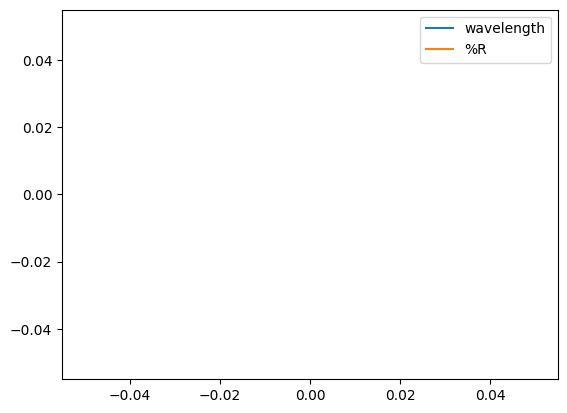

spectrum=<spectraltools.Spectrum object at 0x0000024F7314FE60>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

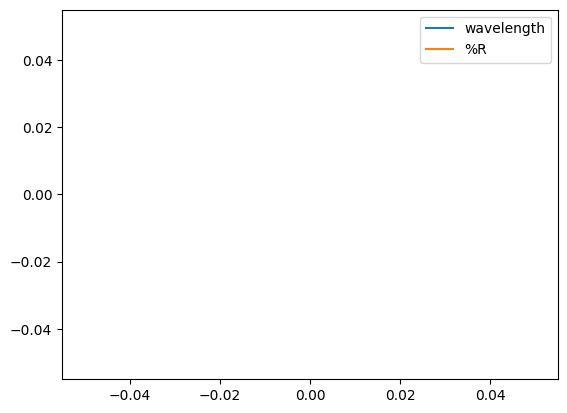

spectrum=<spectraltools.Spectrum object at 0x0000024F745F43B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

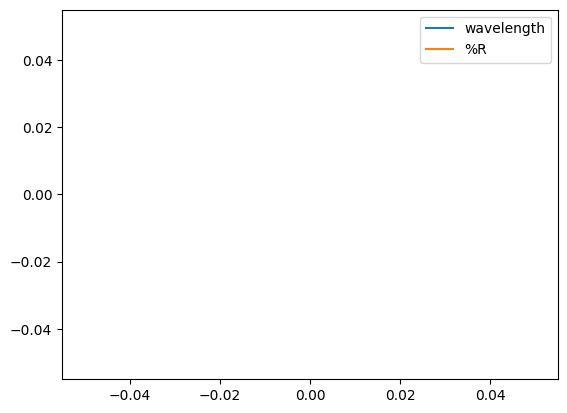

spectrum=<spectraltools.Spectrum object at 0x0000024F72BCA9F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

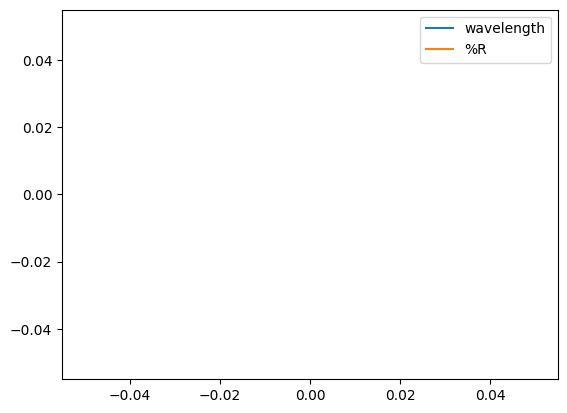

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F7312E6F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

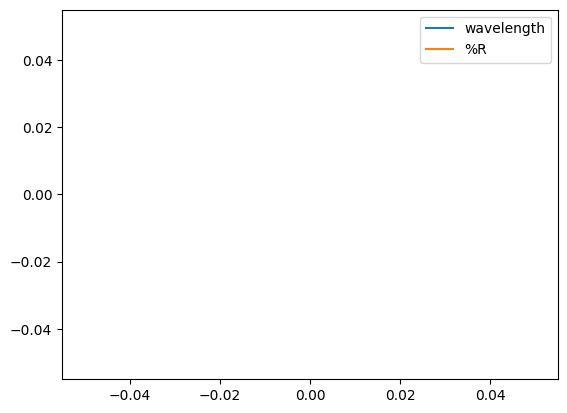

spectrum=<spectraltools.Spectrum object at 0x0000024F72F2B8C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

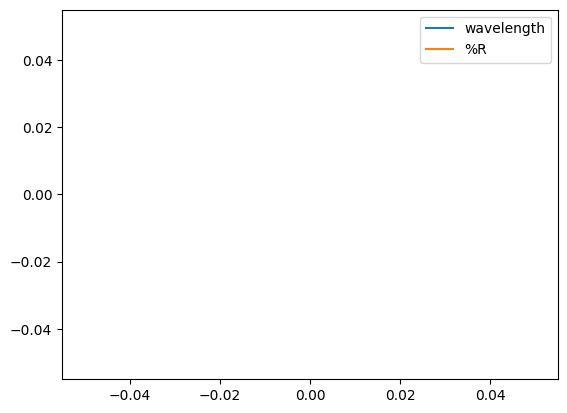

spectrum=<spectraltools.Spectrum object at 0x0000024F74387B30>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

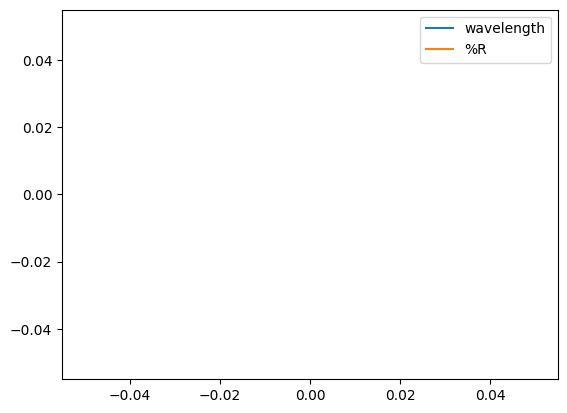

spectrum=<spectraltools.Spectrum object at 0x0000024F7456AC00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

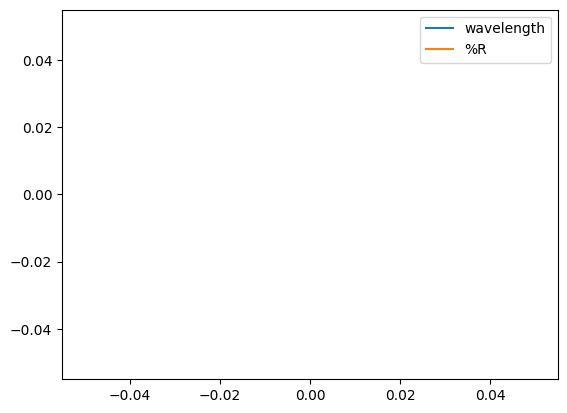

spectrum=<spectraltools.Spectrum object at 0x0000024F74522240>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

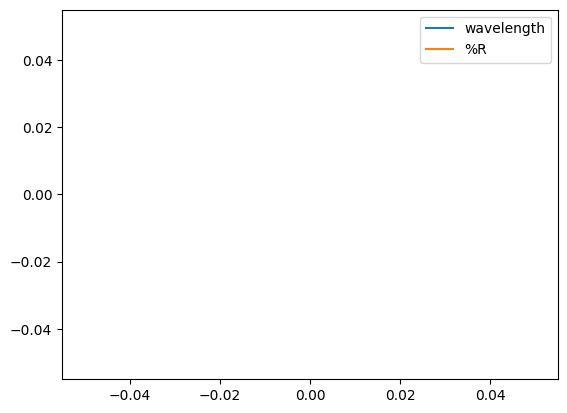

spectrum=<spectraltools.Spectrum object at 0x0000024F72E1A240>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

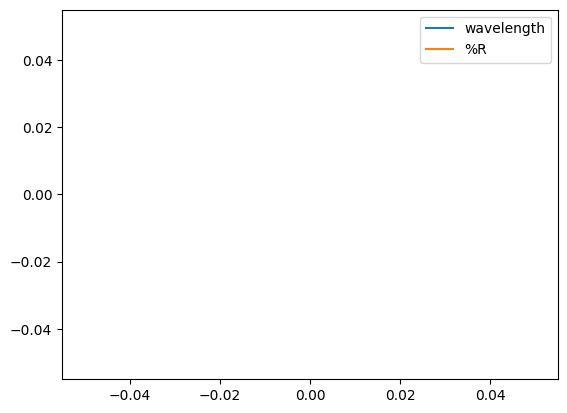

spectrum=<spectraltools.Spectrum object at 0x0000024F72C4F080>
Average Craic
Create spectrum from file
Collection lookup
INBIO
Genus specimen=71    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

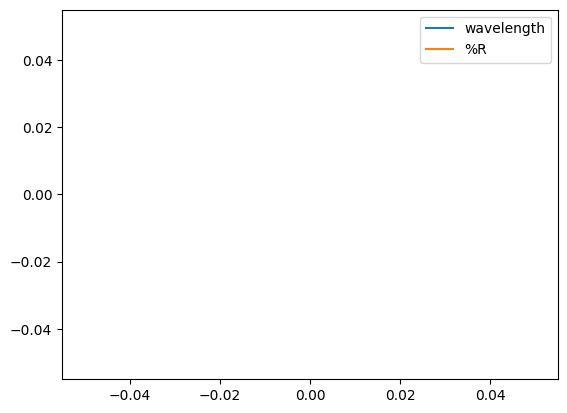

spectrum=<spectraltools.Spectrum object at 0x0000024F7432F800>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=49    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

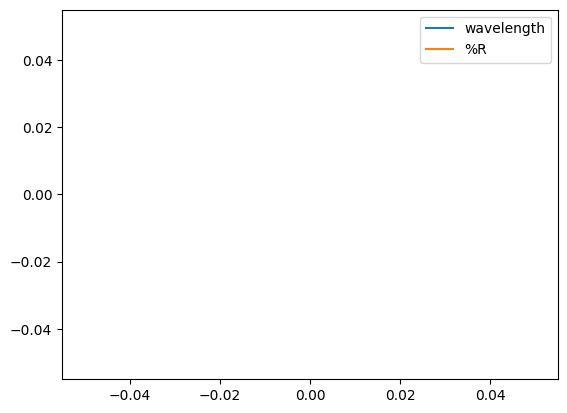

spectrum=<spectraltools.Spectrum object at 0x0000024F72B78740>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=50    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736458L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

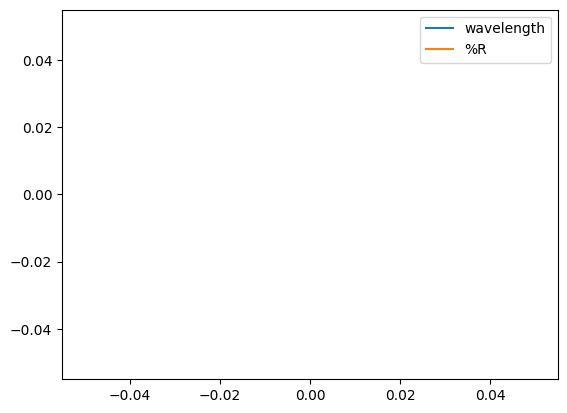

spectrum=<spectraltools.Spectrum object at 0x0000024F72EC3530>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=51    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736459L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

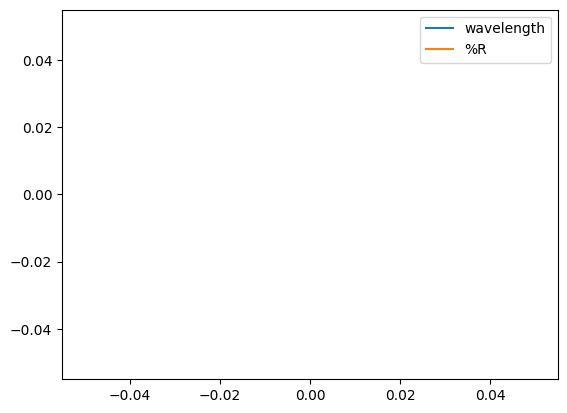

spectrum=<spectraltools.Spectrum object at 0x0000024F7459F530>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=72    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

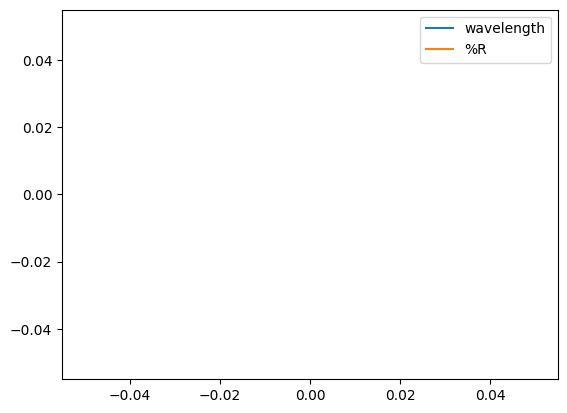

spectrum=<spectraltools.Spectrum object at 0x0000024F745F65A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=52    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195354L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

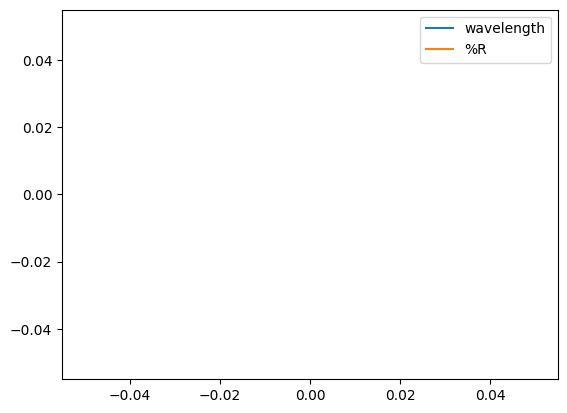

spectrum=<spectraltools.Spectrum object at 0x0000024F745002F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=53    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

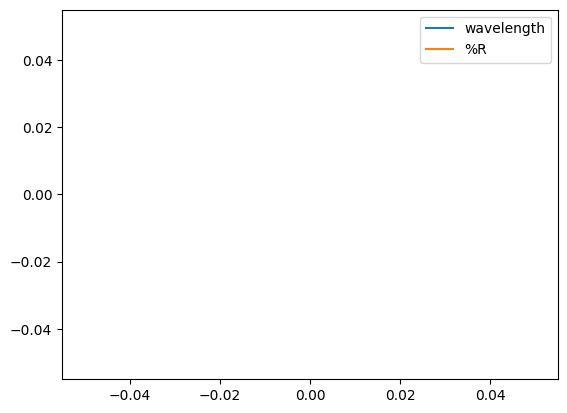

spectrum=<spectraltools.Spectrum object at 0x0000024F72F3FF80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=54    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195357L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

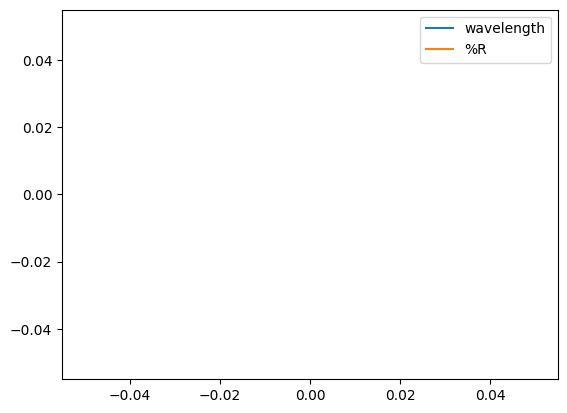

spectrum=<spectraltools.Spectrum object at 0x0000024F73007230>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=55    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195358L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

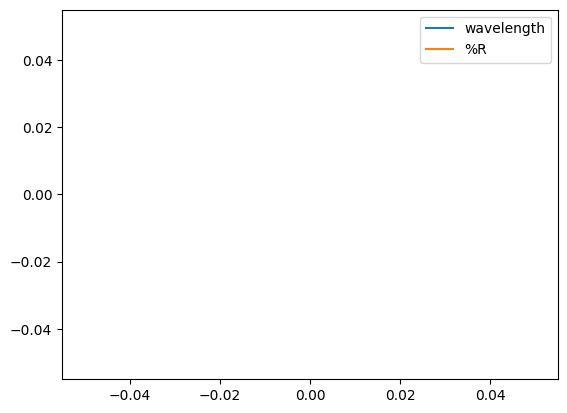

spectrum=<spectraltools.Spectrum object at 0x0000024F74477D70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=56    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

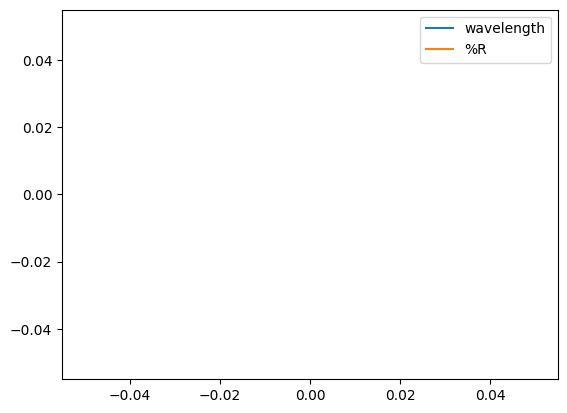

spectrum=<spectraltools.Spectrum object at 0x0000024F72AC0E00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=26    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2248544L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

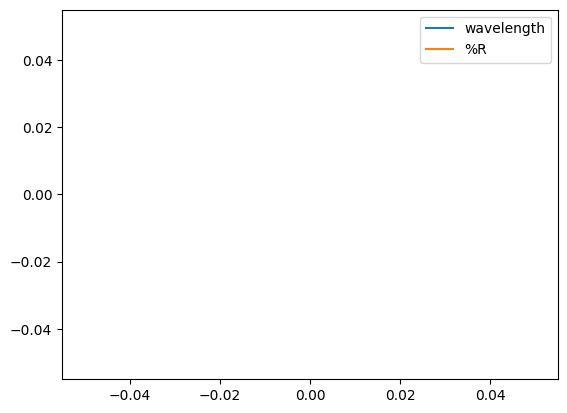

spectrum=<spectraltools.Spectrum object at 0x0000024F730048C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=27    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249504L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

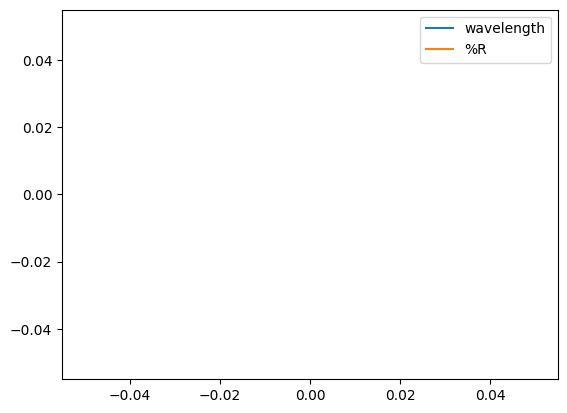

spectrum=<spectraltools.Spectrum object at 0x0000024F7311B020>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=28    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

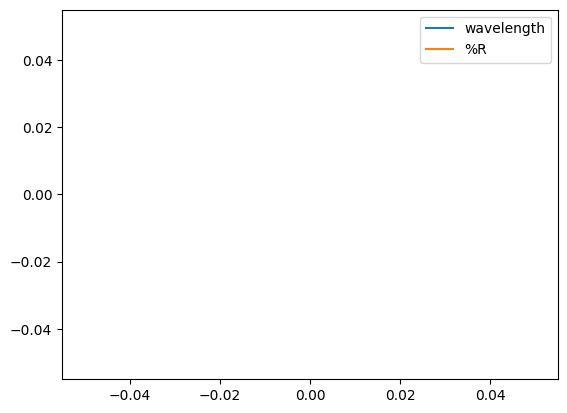

spectrum=<spectraltools.Spectrum object at 0x0000024F7440E120>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=29    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

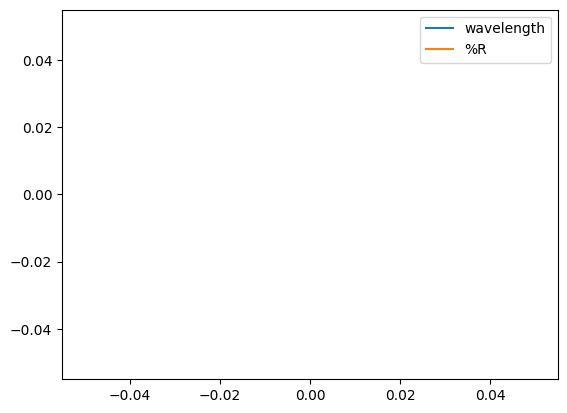

spectrum=<spectraltools.Spectrum object at 0x0000024F731B3620>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=30    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2361339L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

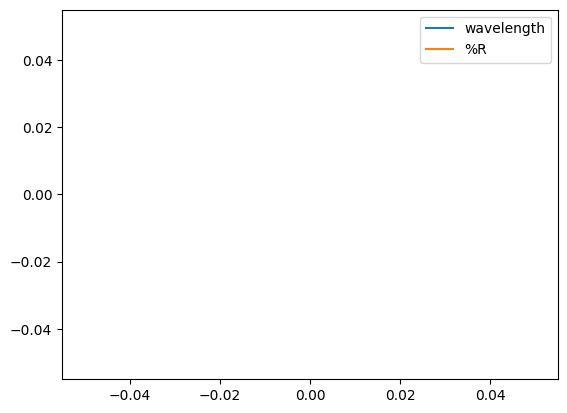

spectrum=<spectraltools.Spectrum object at 0x0000024F72B2BBF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=31    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

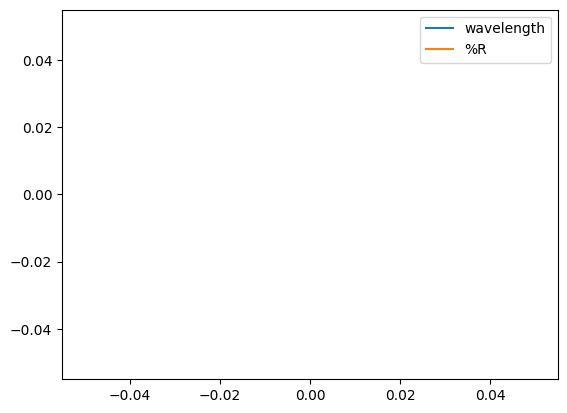

spectrum=<spectraltools.Spectrum object at 0x0000024F72CE4290>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

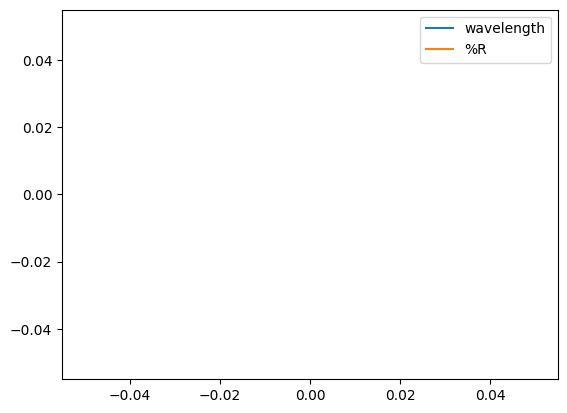

spectrum=<spectraltools.Spectrum object at 0x0000024F7440F9B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

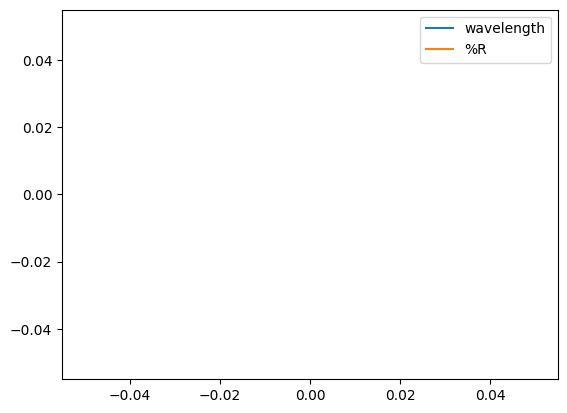

spectrum=<spectraltools.Spectrum object at 0x0000024F730505F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=34    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388550L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

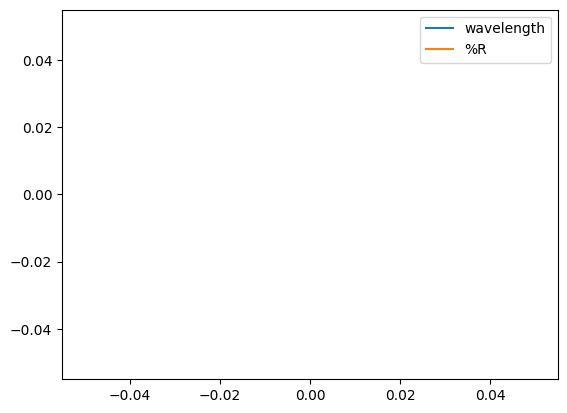

spectrum=<spectraltools.Spectrum object at 0x0000024F72C4FF80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=35    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388554L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

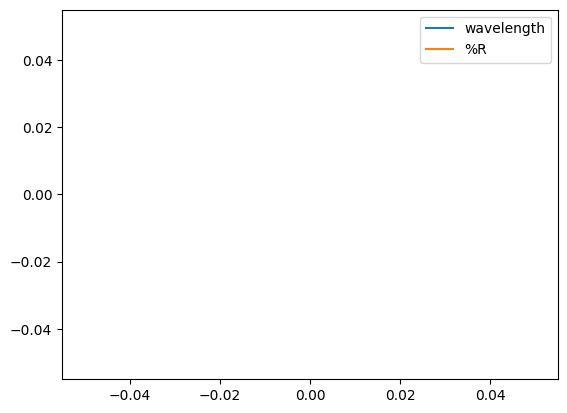

spectrum=<spectraltools.Spectrum object at 0x0000024F72EC3D40>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=36    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

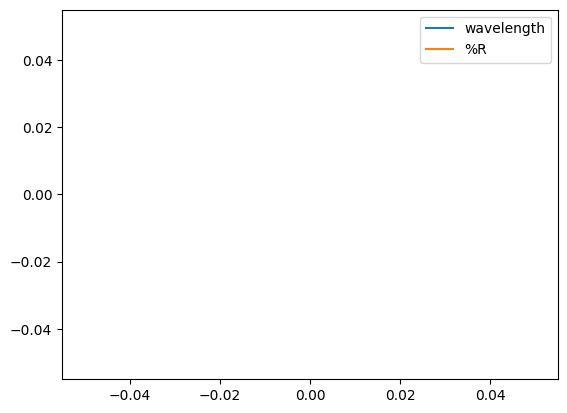

spectrum=<spectraltools.Spectrum object at 0x0000024F730FDDF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=37    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

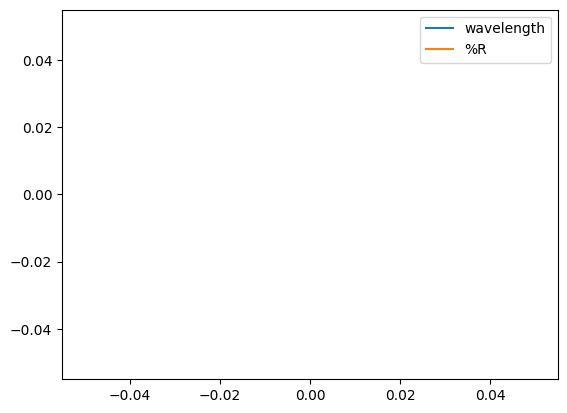

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2452030L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F73026F00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=38    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

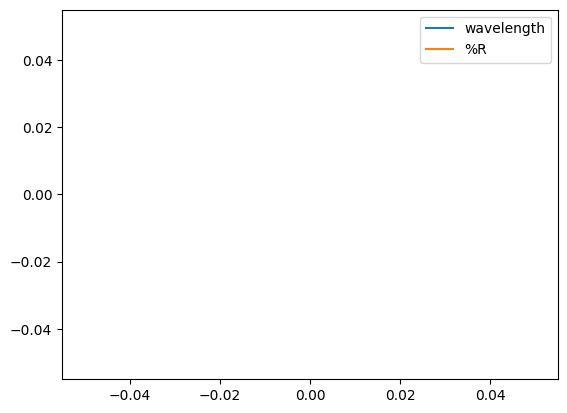

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2453057L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F730272F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=39    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

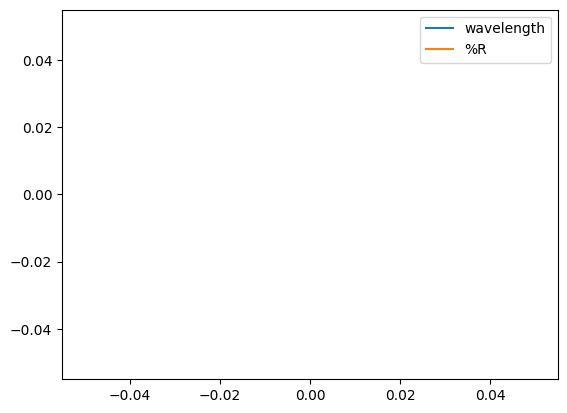

spectrum=<spectraltools.Spectrum object at 0x0000024F72C7D460>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=57    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2456006L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

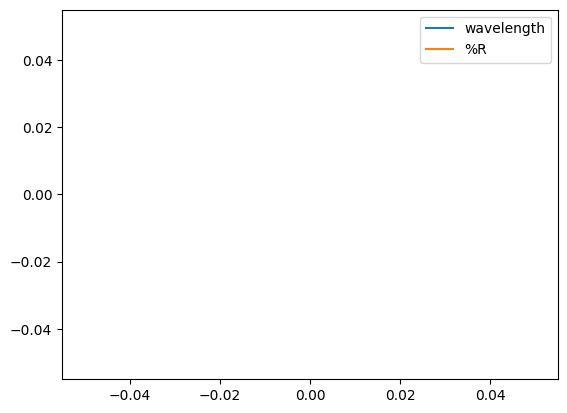

spectrum=<spectraltools.Spectrum object at 0x0000024F74480290>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=40    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2467329L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

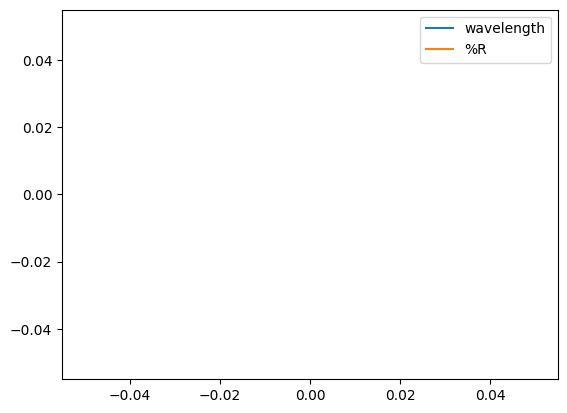

spectrum=<spectraltools.Spectrum object at 0x0000024F7427E810>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=58    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2548659L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

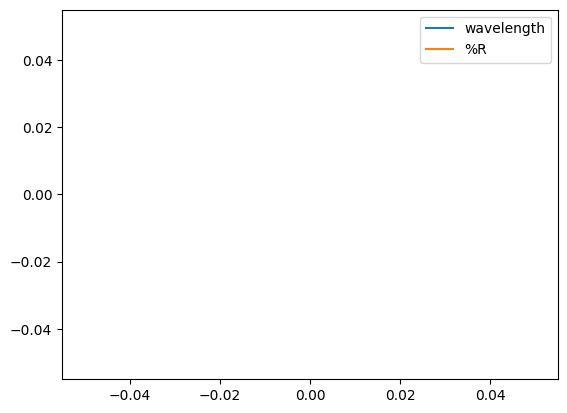

spectrum=<spectraltools.Spectrum object at 0x0000024F74520680>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=59    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\3036568L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

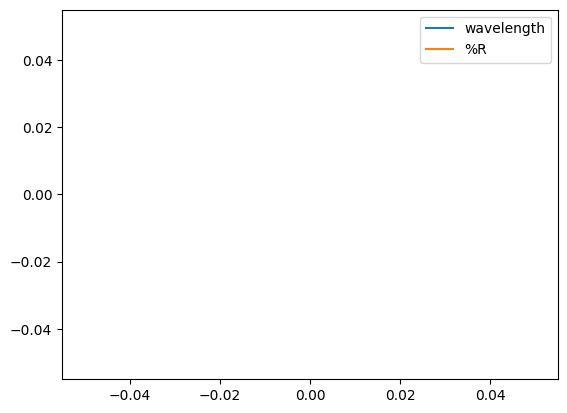

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72C2EC60>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

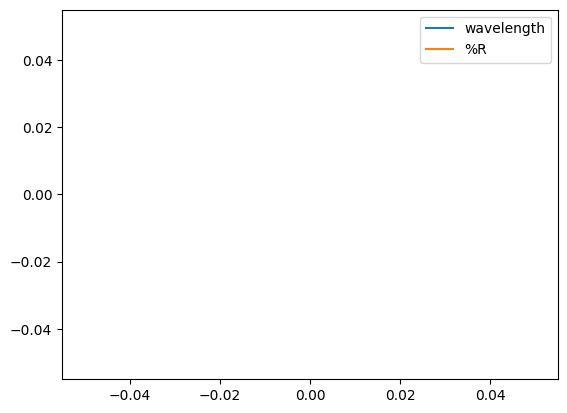

spectrum=<spectraltools.Spectrum object at 0x0000024F731B3110>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

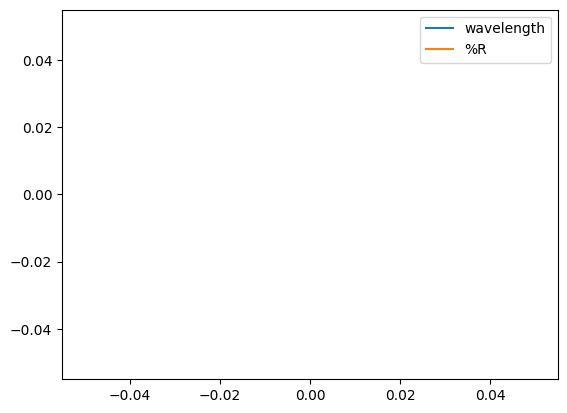

spectrum=<spectraltools.Spectrum object at 0x0000024F7561AA80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

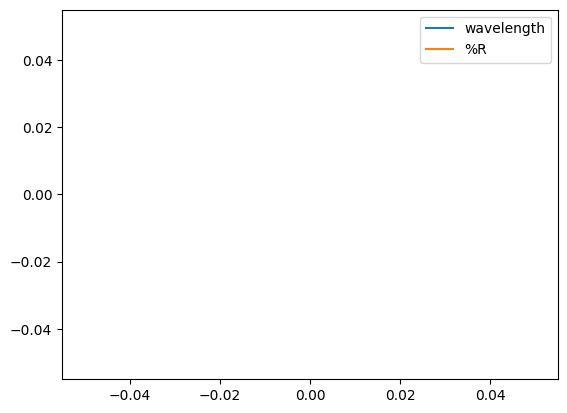

spectrum=<spectraltools.Spectrum object at 0x0000024F7440E870>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

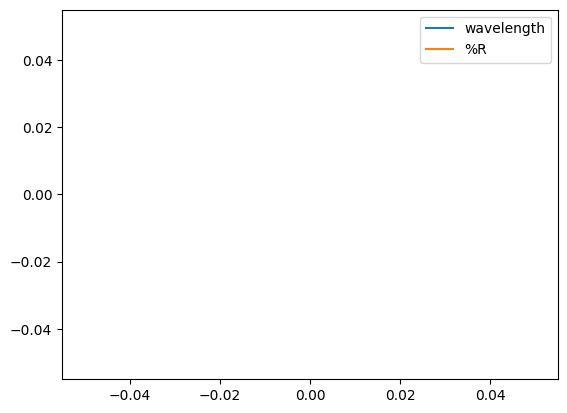

spectrum=<spectraltools.Spectrum object at 0x0000024F74586D80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

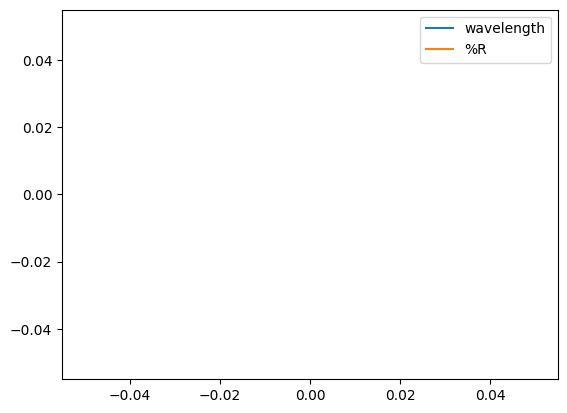

spectrum=<spectraltools.Spectrum object at 0x0000024F74374DD0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

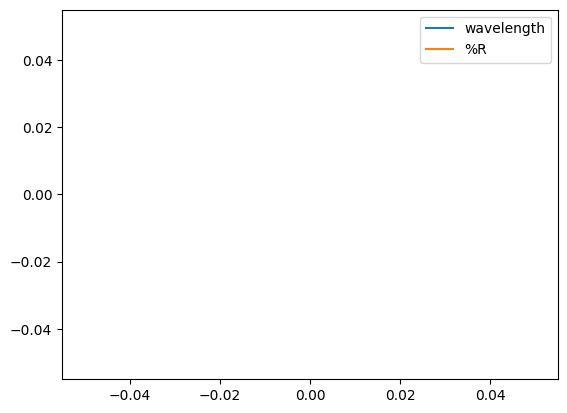

spectrum=<spectraltools.Spectrum object at 0x0000024F72D70A40>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

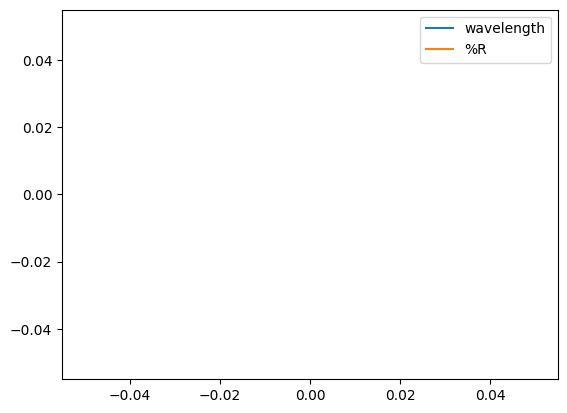

spectrum=<spectraltools.Spectrum object at 0x0000024F72F109E0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

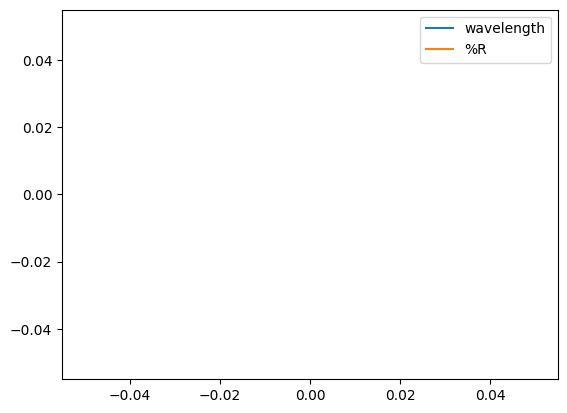

spectrum=<spectraltools.Spectrum object at 0x0000024F72F10AA0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

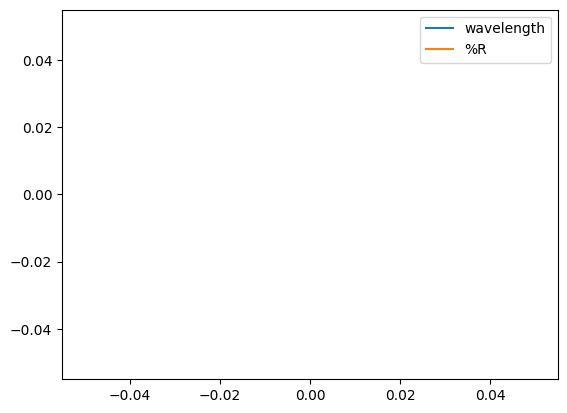

spectrum=<spectraltools.Spectrum object at 0x0000024F72C4F2F0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

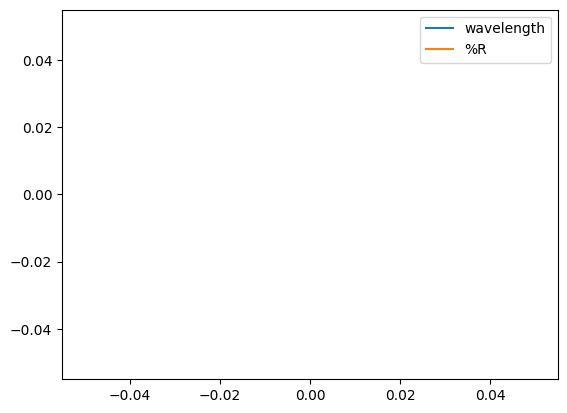

spectrum=<spectraltools.Spectrum object at 0x0000024F730E5310>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

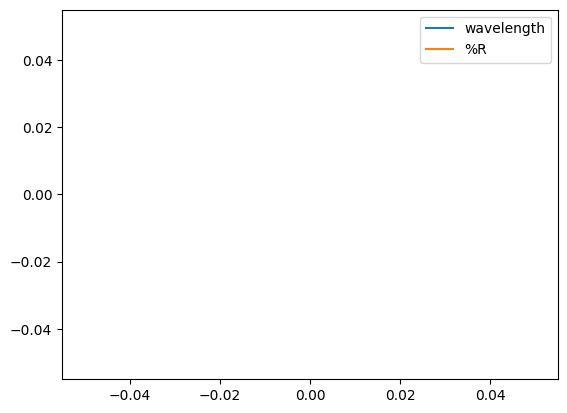

spectrum=<spectraltools.Spectrum object at 0x0000024F74384EC0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

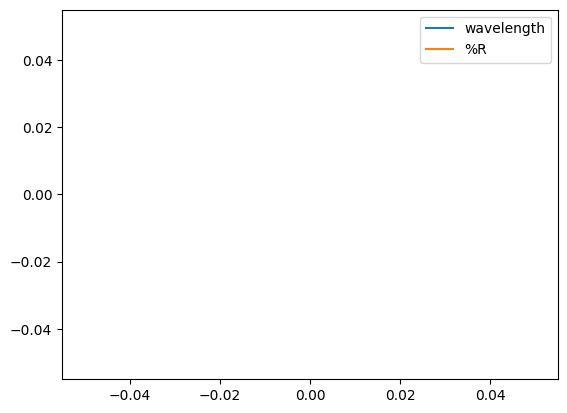

spectrum=<spectraltools.Spectrum object at 0x0000024F745F5BE0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

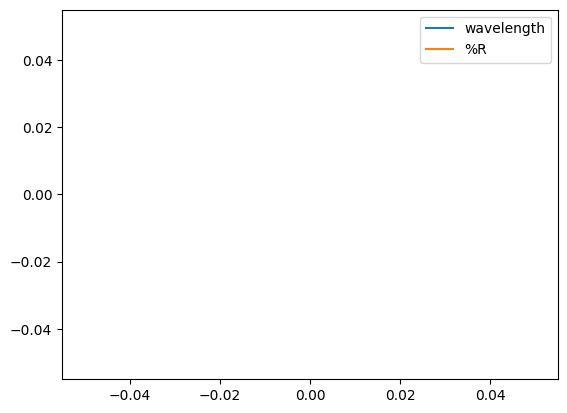

spectrum=<spectraltools.Spectrum object at 0x0000024F72AA2240>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

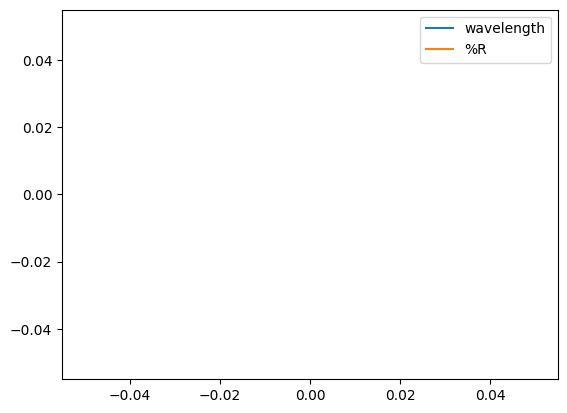

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F74541D30>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

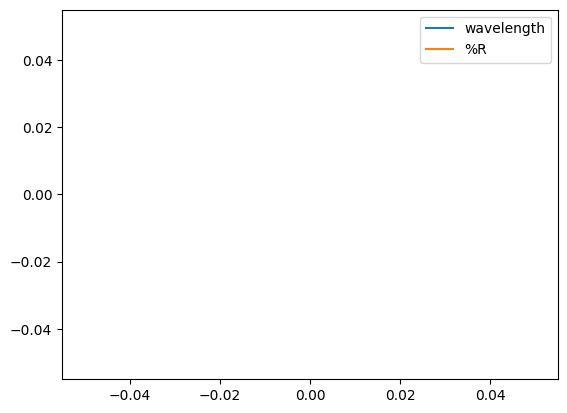

spectrum=<spectraltools.Spectrum object at 0x0000024F74310A70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

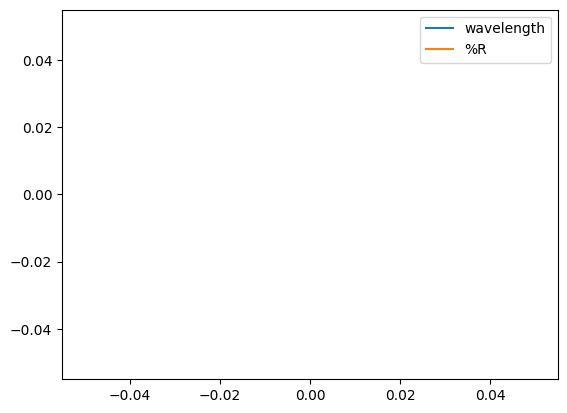

spectrum=<spectraltools.Spectrum object at 0x0000024F72F3E270>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

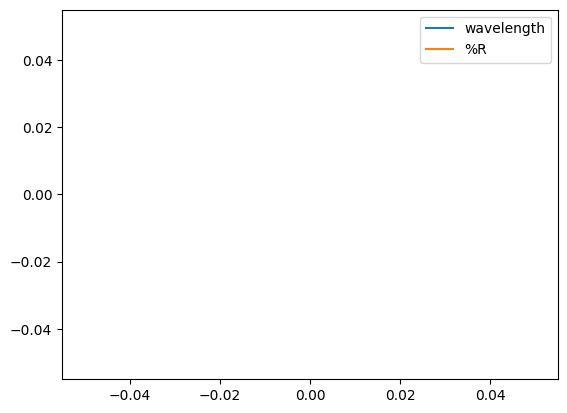

spectrum=<spectraltools.Spectrum object at 0x0000024F745F4E00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

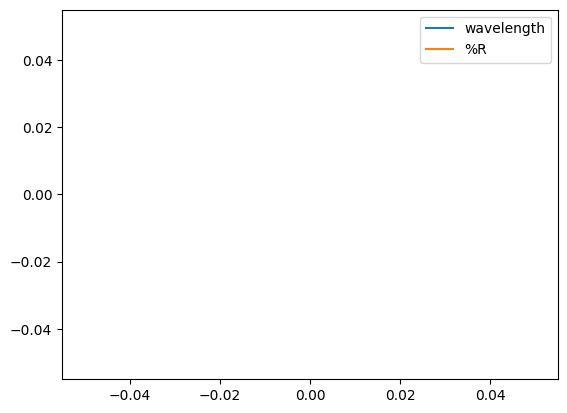

spectrum=<spectraltools.Spectrum object at 0x0000024F743EBA10>
right_average_df=Empty DataFrame
Columns: [wavelength, %R]
Index: []
left_average_df=Empty DataFrame
Columns: [wavelength, %R]
Index: []
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

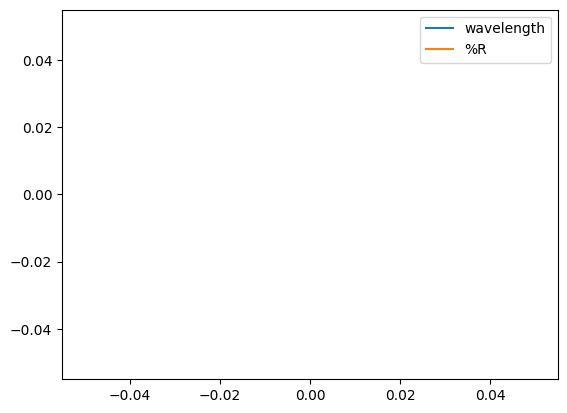

spectrum=<spectraltools.Spectrum object at 0x0000024F743EBA10>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

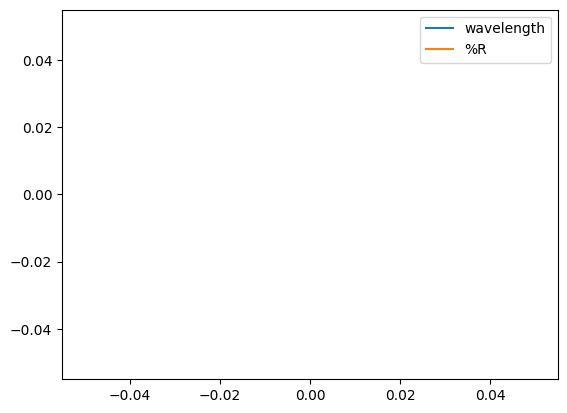

spectrum=<spectraltools.Spectrum object at 0x0000024F745C37A0>
right_pol=['..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R1.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R2.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R3.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R4.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856R5.csv']
left_pol=['..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L1.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L2.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L3.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L4.csv', '..\\test\\data\\test_step_jump_correction\\files\\Espectros 2018\\2376856L5.csv']
no_polarization=[]
Average Craic
Create spectrum from file
Collection lookup
INBIO
Gen

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

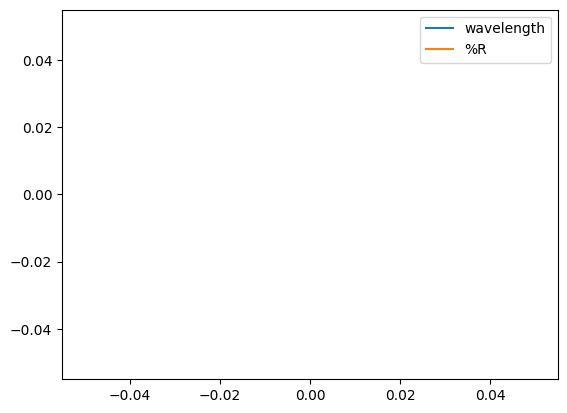

spectrum=<spectraltools.Spectrum object at 0x0000024F72BC9A00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=49    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

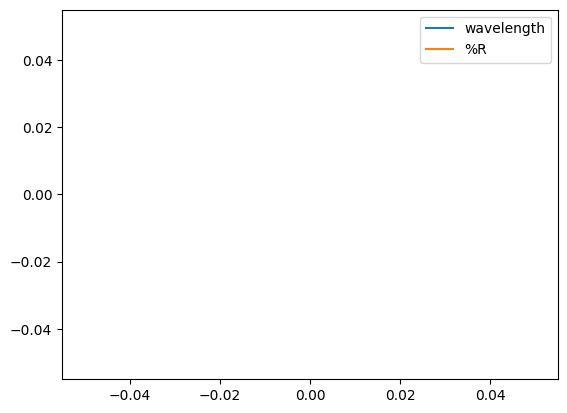

spectrum=<spectraltools.Spectrum object at 0x0000024F730042C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=50    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736458L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

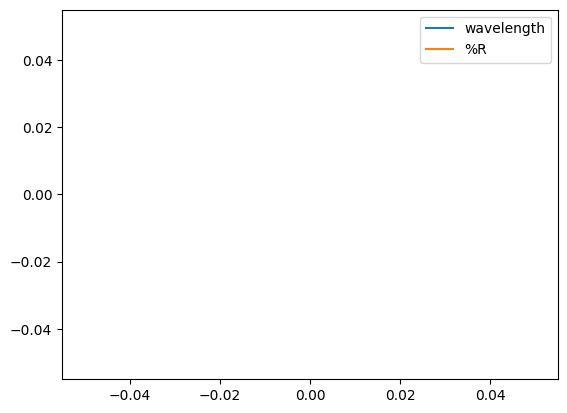

spectrum=<spectraltools.Spectrum object at 0x0000024F74206A50>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=51    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736459L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

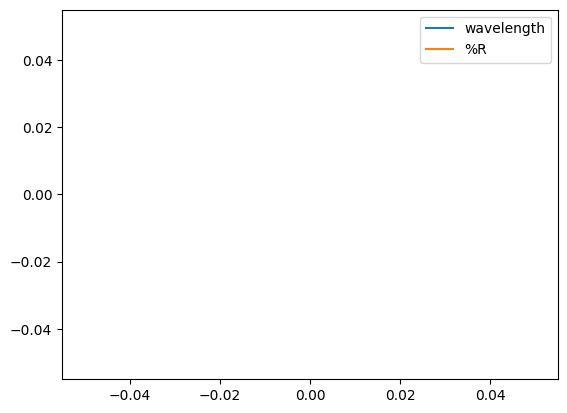

spectrum=<spectraltools.Spectrum object at 0x0000024F72E88950>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=72    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

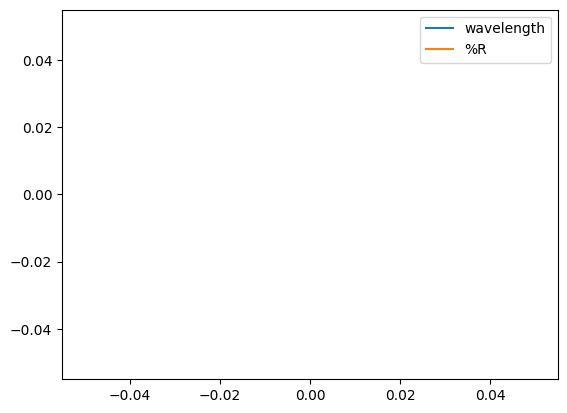

spectrum=<spectraltools.Spectrum object at 0x0000024F745F4A40>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=52    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195354L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

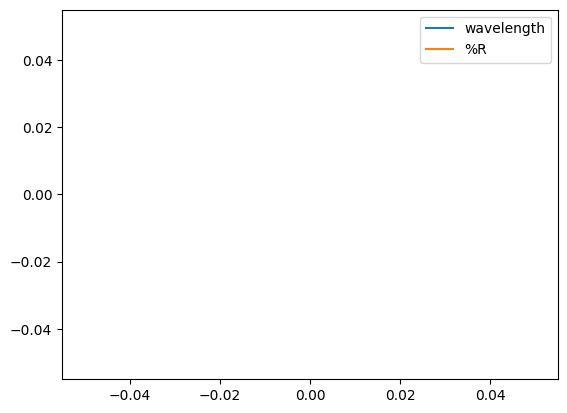

spectrum=<spectraltools.Spectrum object at 0x0000024F72EC2FF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=53    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

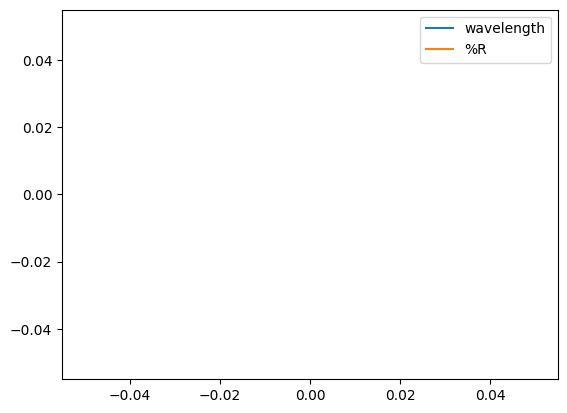

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195357L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F74263110>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=54    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

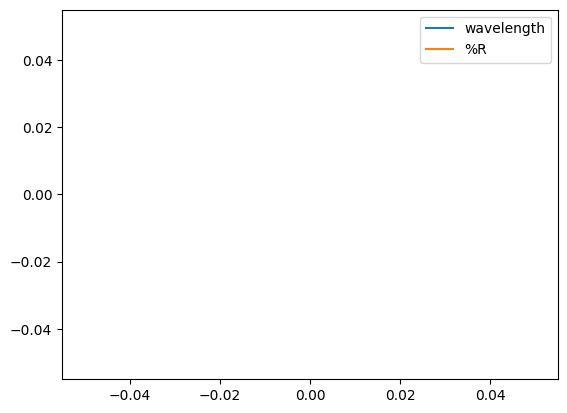

spectrum=<spectraltools.Spectrum object at 0x0000024F72AA2030>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=55    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195358L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

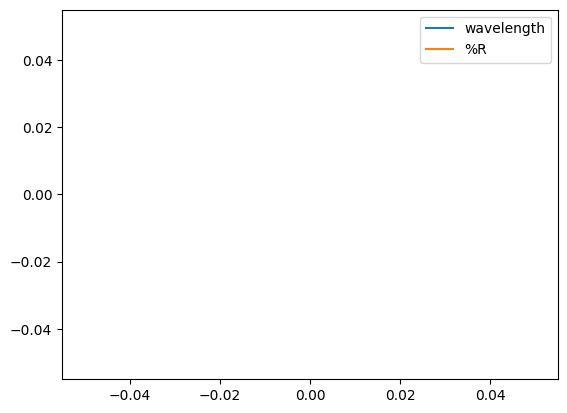

spectrum=<spectraltools.Spectrum object at 0x0000024F72E59310>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=56    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

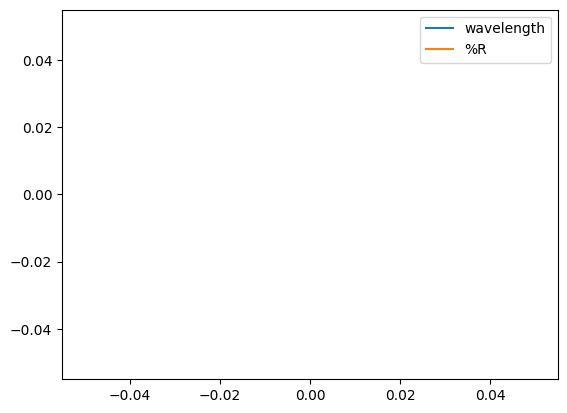

spectrum=<spectraltools.Spectrum object at 0x0000024F7432C230>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=26    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2248544L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

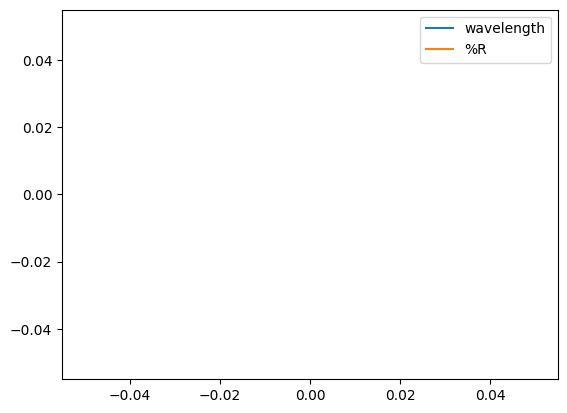

spectrum=<spectraltools.Spectrum object at 0x0000024F743858B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=27    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249504L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

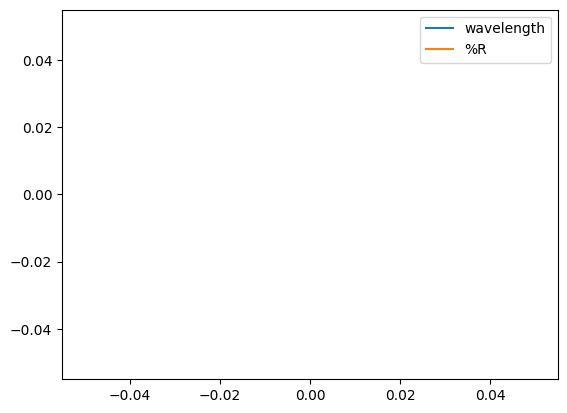

spectrum=<spectraltools.Spectrum object at 0x0000024F72D70A70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=28    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

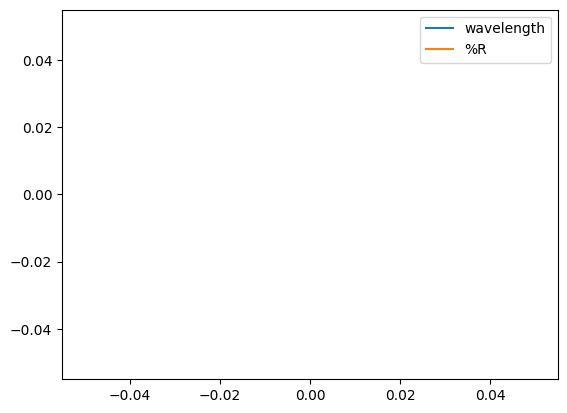

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F741EEED0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=29    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

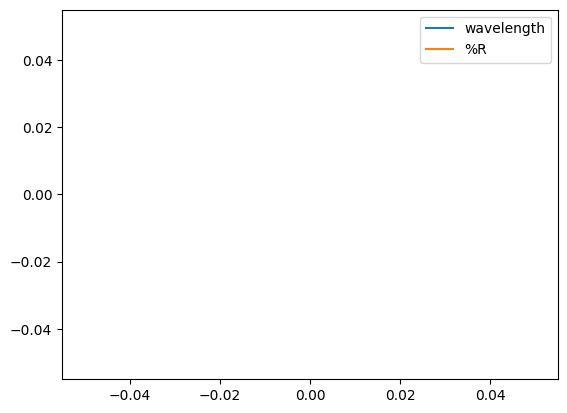

spectrum=<spectraltools.Spectrum object at 0x0000024F72BC9D00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=30    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2361339L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

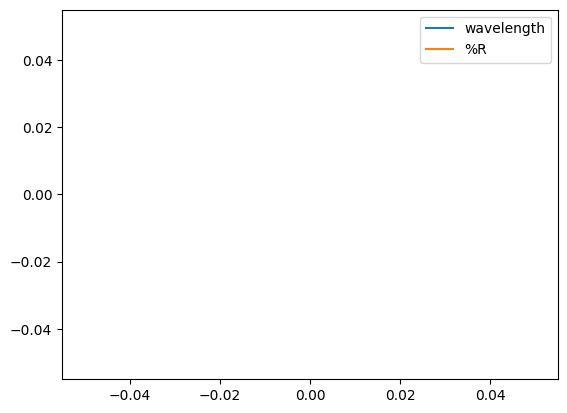

spectrum=<spectraltools.Spectrum object at 0x0000024F745F5E80>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=31    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2375565L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

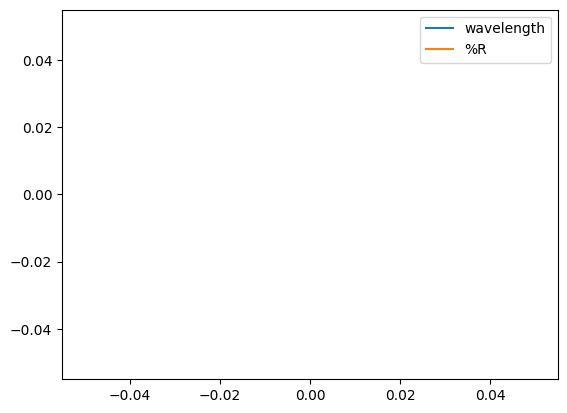

spectrum=<spectraltools.Spectrum object at 0x0000024F72F29AC0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

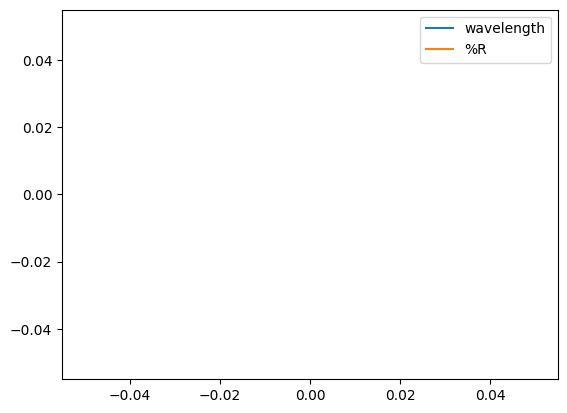

spectrum=<spectraltools.Spectrum object at 0x0000024F7459D6A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

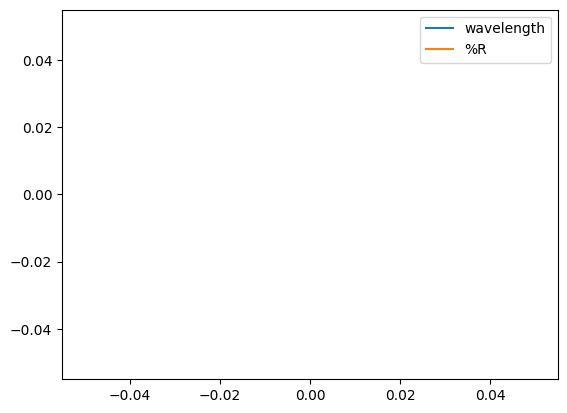

spectrum=<spectraltools.Spectrum object at 0x0000024F7440F320>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=34    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388550L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

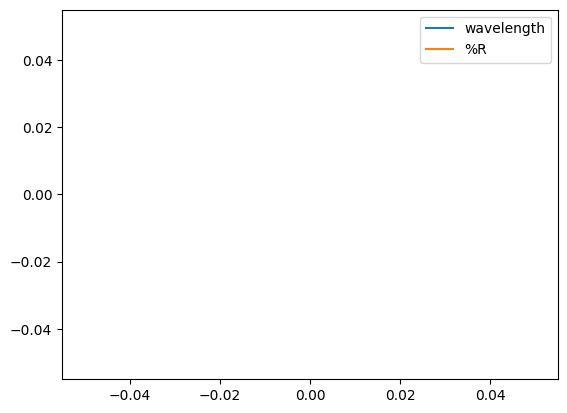

spectrum=<spectraltools.Spectrum object at 0x0000024F74502390>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=35    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2388554L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

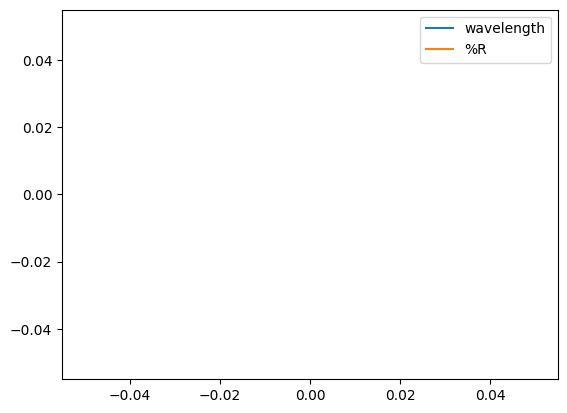

spectrum=<spectraltools.Spectrum object at 0x0000024F75618830>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=36    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422833L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

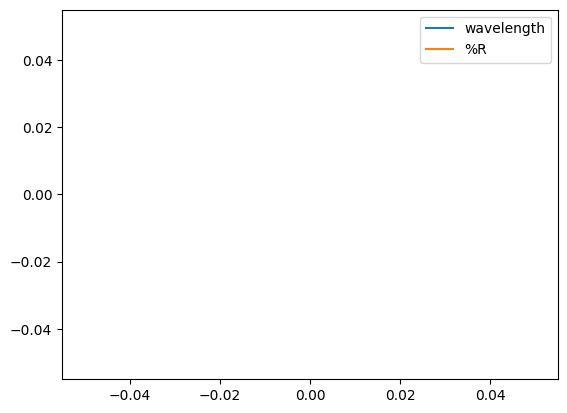

spectrum=<spectraltools.Spectrum object at 0x0000024F74543AA0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=37    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2422834L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

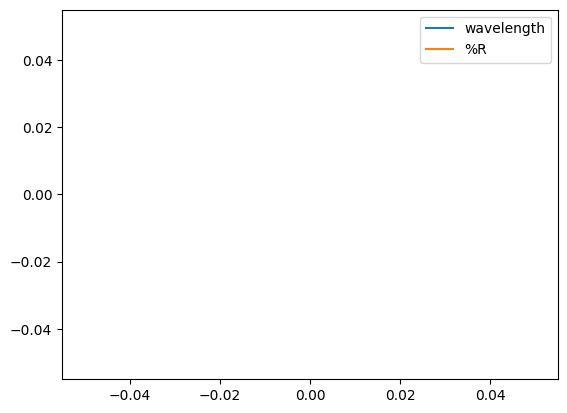

spectrum=<spectraltools.Spectrum object at 0x0000024F72B0F3B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=38    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2452030L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

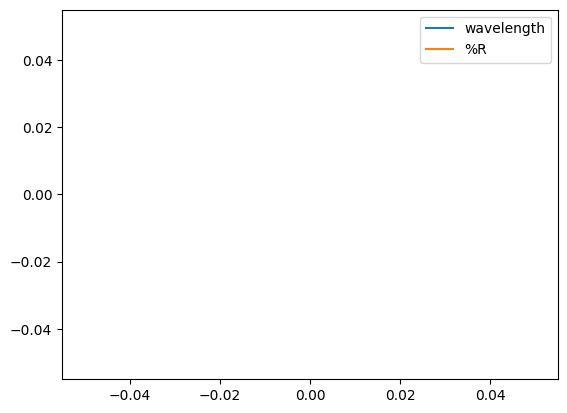

spectrum=<spectraltools.Spectrum object at 0x0000024F7459CD70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=39    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2453057L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

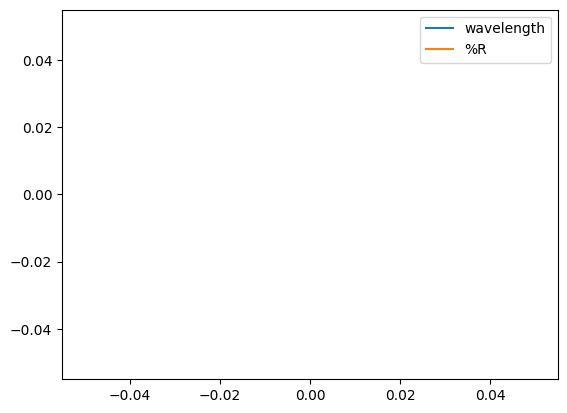

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2456006L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72BA2240>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=57    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

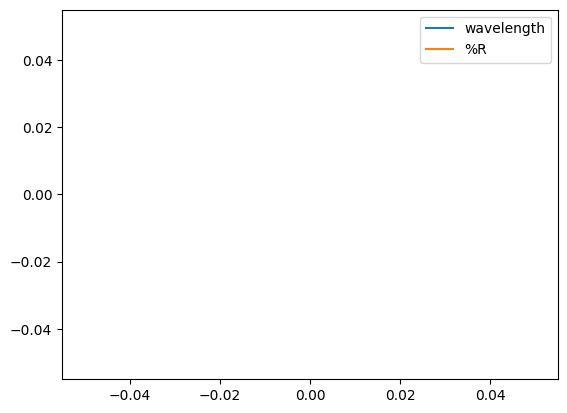

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2467329L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72EA17C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=40    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

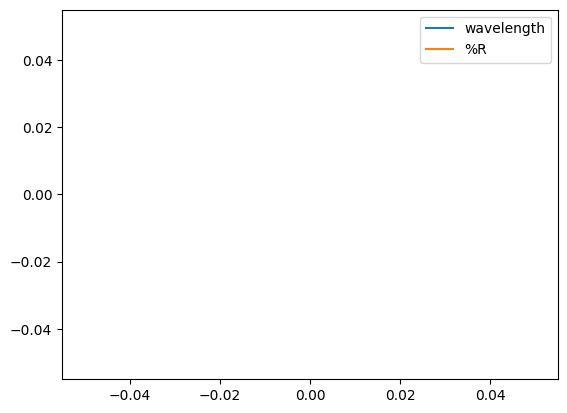

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2548659L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72BA0E60>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=58    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

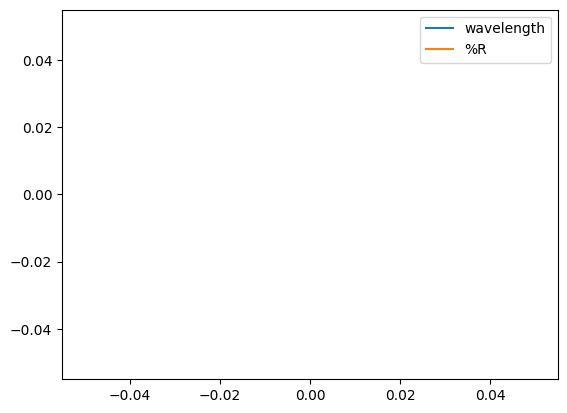

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\3036568L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F73027AD0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=59    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

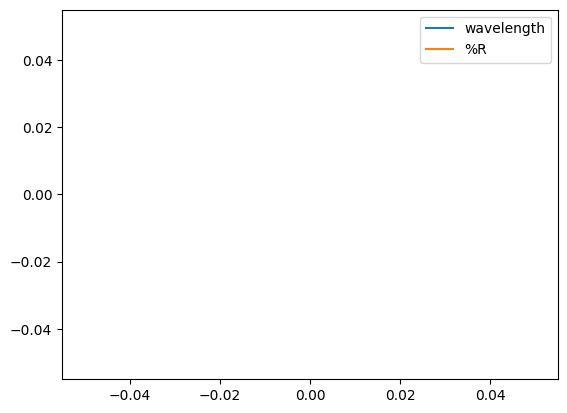

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F73025A00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

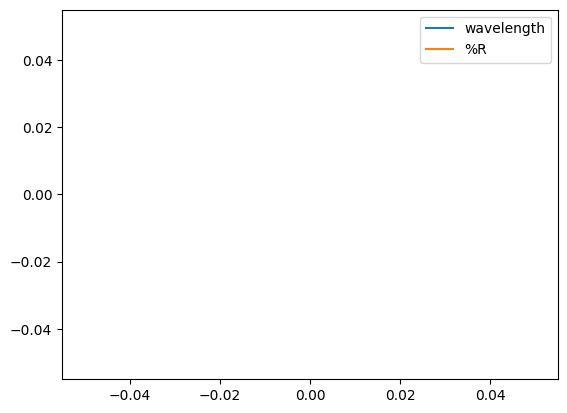

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72C2C590>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

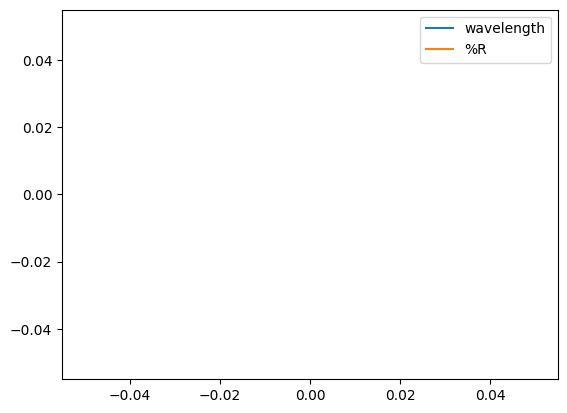

spectrum=<spectraltools.Spectrum object at 0x0000024F72EC29C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

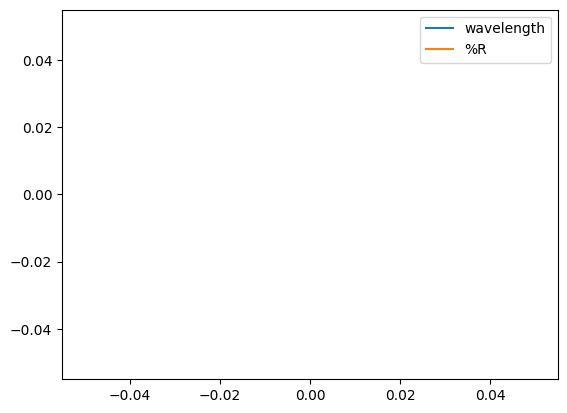

spectrum=<spectraltools.Spectrum object at 0x0000024F745C1F10>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

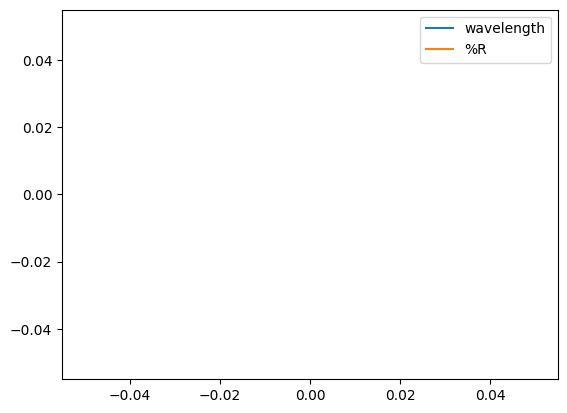

spectrum=<spectraltools.Spectrum object at 0x0000024F745F5970>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856L5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

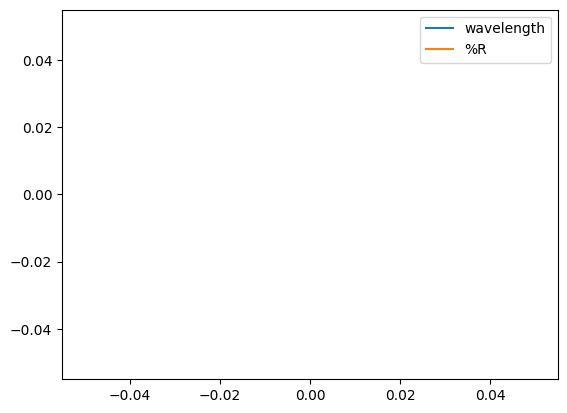

spectrum=<spectraltools.Spectrum object at 0x0000024F72BA0830>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

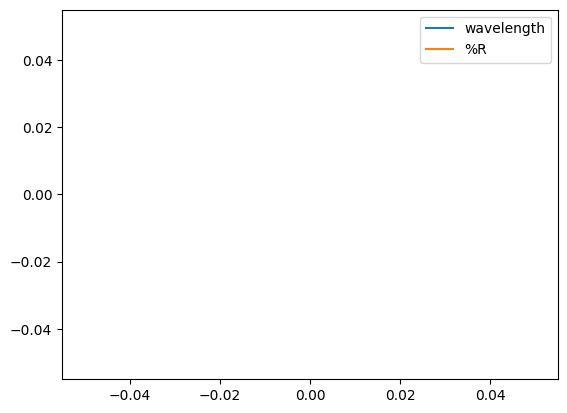

spectrum=<spectraltools.Spectrum object at 0x0000024F72D731D0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

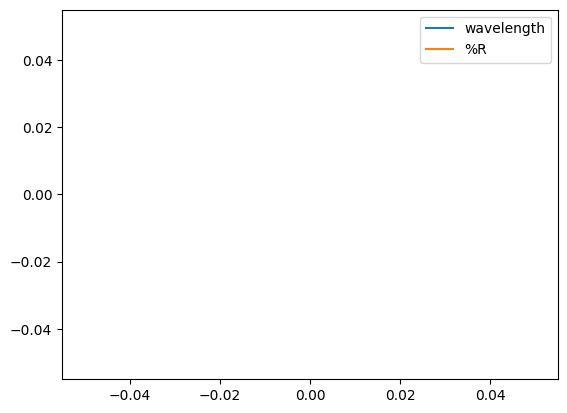

spectrum=<spectraltools.Spectrum object at 0x0000024F7314C5C0>
Create spectrum from file
Collection lookup
INBIO


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


Genus specimen=32    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

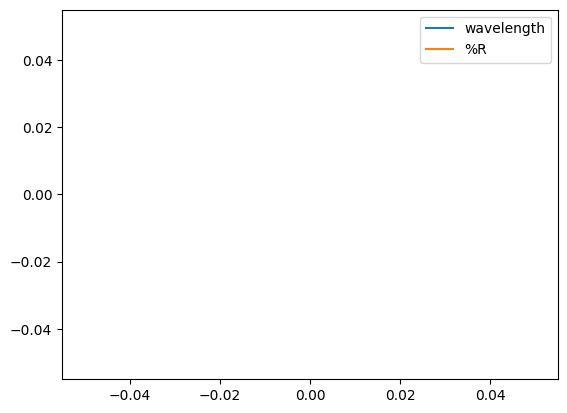

spectrum=<spectraltools.Spectrum object at 0x0000024F72CE6D20>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

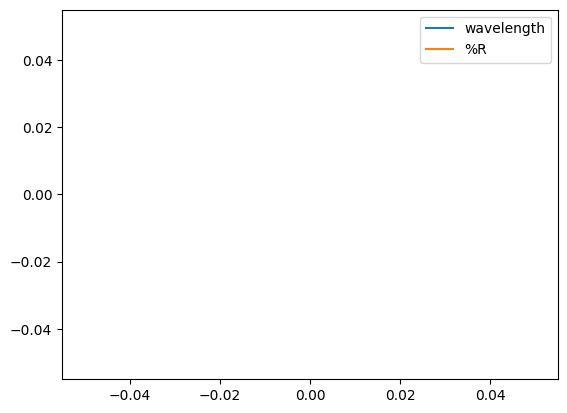

spectrum=<spectraltools.Spectrum object at 0x0000024F72BE1220>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=32    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376856R5.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

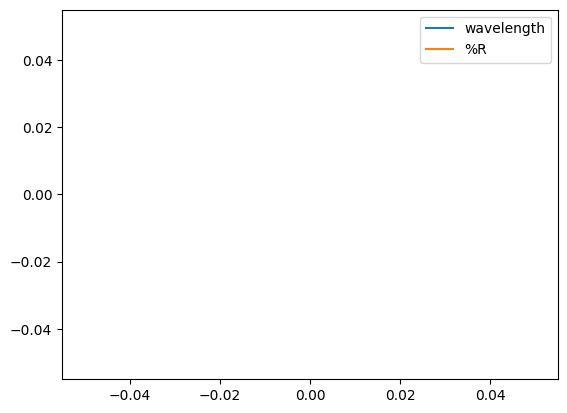

spectrum=<spectraltools.Spectrum object at 0x0000024F730072C0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

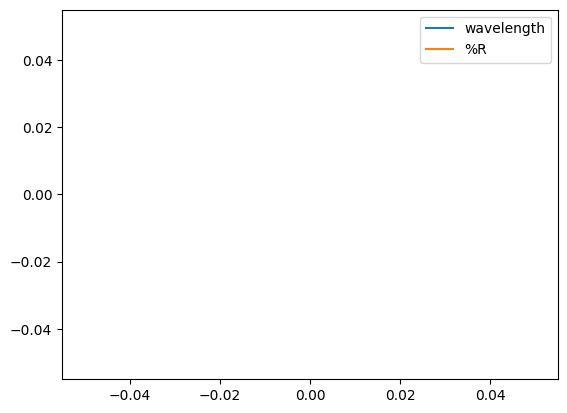

spectrum=<spectraltools.Spectrum object at 0x0000024F72C4D2B0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

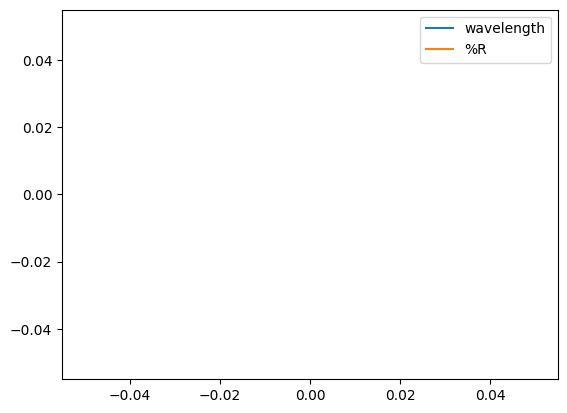

spectrum=<spectraltools.Spectrum object at 0x0000024F74374830>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

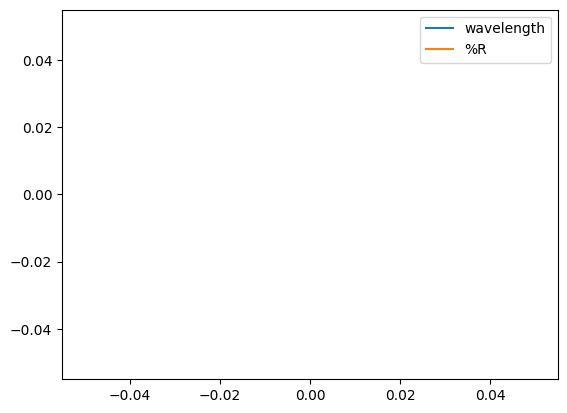

spectrum=<spectraltools.Spectrum object at 0x0000024F743D0860>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857L4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

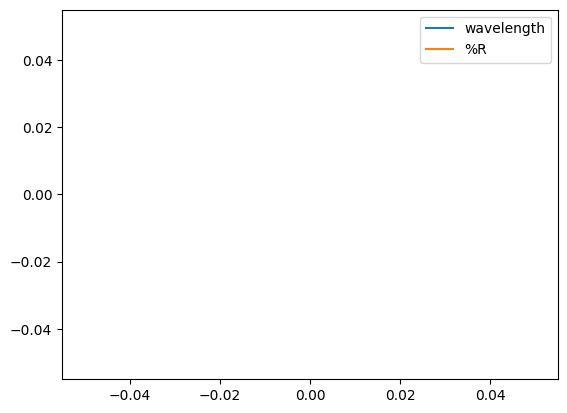

spectrum=<spectraltools.Spectrum object at 0x0000024F744E5220>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

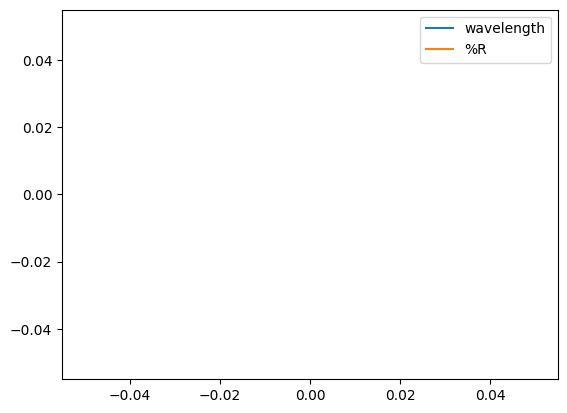

spectrum=<spectraltools.Spectrum object at 0x0000024F72F72CF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R2.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

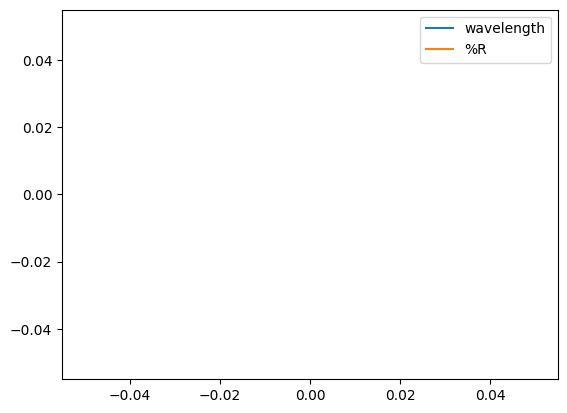

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72AA2EA0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

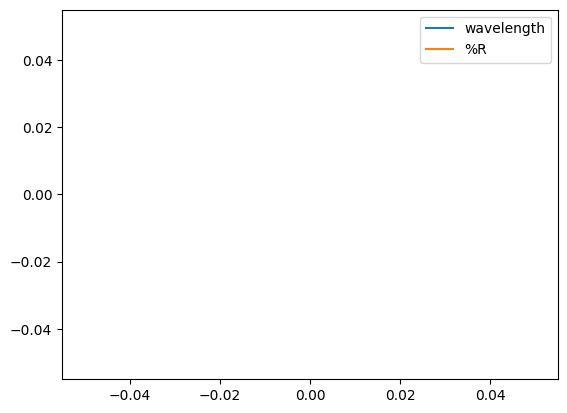

spectrum=<spectraltools.Spectrum object at 0x0000024F73004CE0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=33    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\Espectros 2018\2376857R4.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

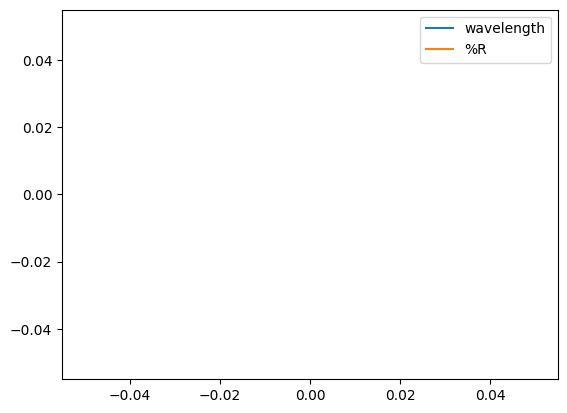

spectrum=<spectraltools.Spectrum object at 0x0000024F74263620>
Average Craic
Create spectrum from file
Collection lookup
INBIO
Genus specimen=71    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1309367L3.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

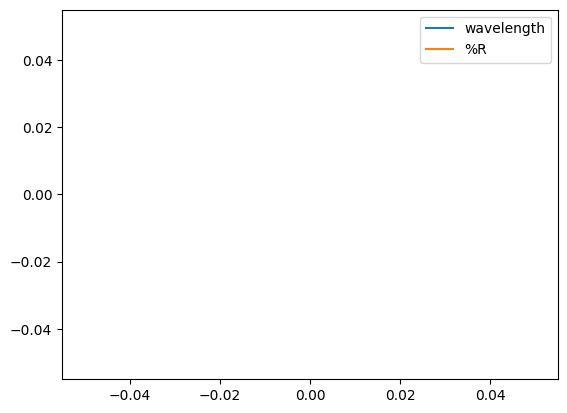

spectrum=<spectraltools.Spectrum object at 0x0000024F72E1BCE0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=49    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1717606L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

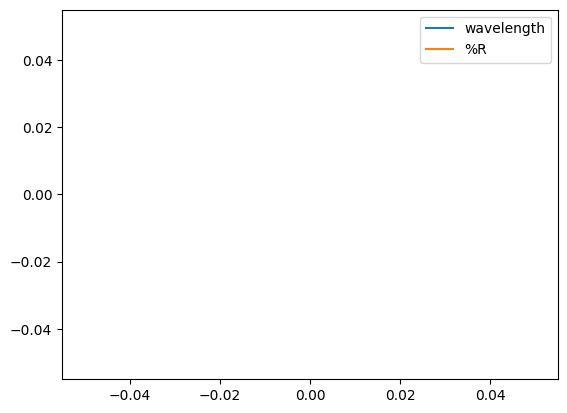

C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736458L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


spectrum=<spectraltools.Spectrum object at 0x0000024F72EC2FF0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=50    Chrysina
Name: genus, dtype: object


<Figure size 640x480 with 0 Axes>

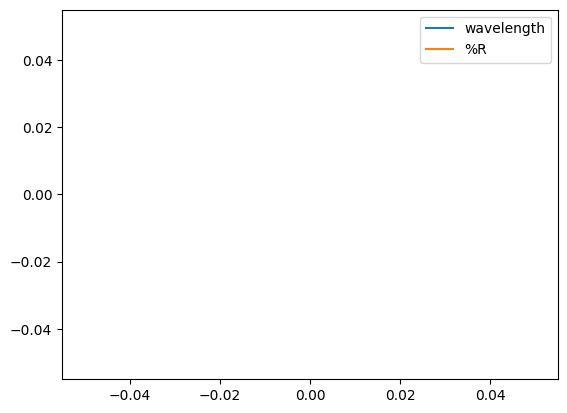

spectrum=<spectraltools.Spectrum object at 0x0000024F72BC9D60>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=51    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\1736459L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

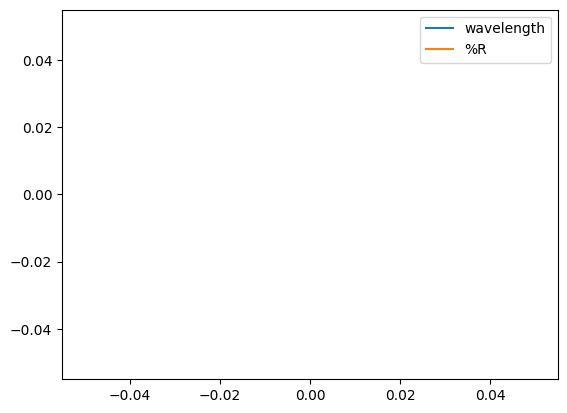

spectrum=<spectraltools.Spectrum object at 0x0000024F72B0C6E0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=72    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2181994L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

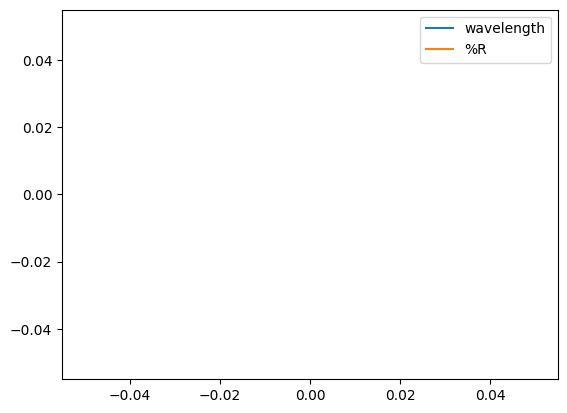

spectrum=<spectraltools.Spectrum object at 0x0000024F73052690>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=52    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195354L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

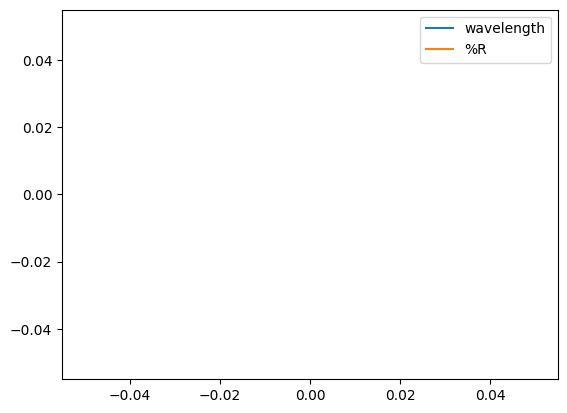

spectrum=<spectraltools.Spectrum object at 0x0000024F72A85C70>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=53    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195355L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

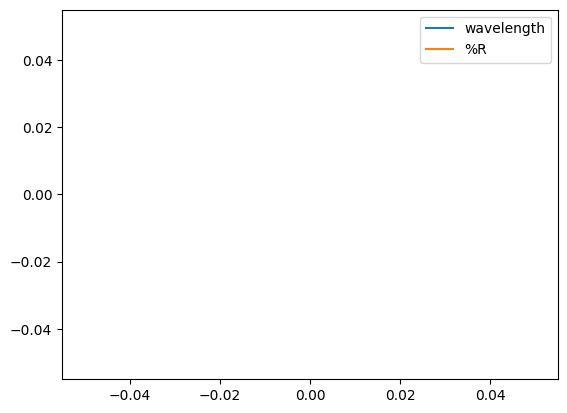

spectrum=<spectraltools.Spectrum object at 0x0000024F72D9E5A0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=54    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195357L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

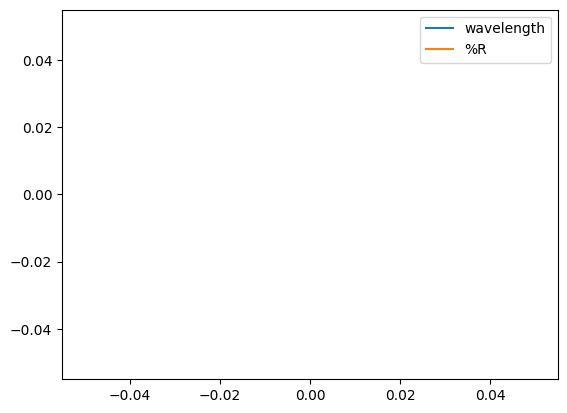

spectrum=<spectraltools.Spectrum object at 0x0000024F73118620>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=55    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2195358L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

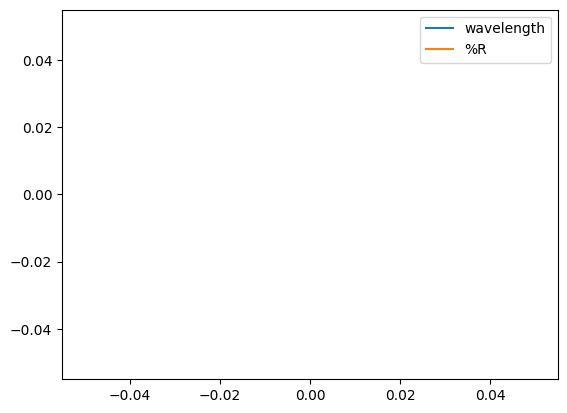

spectrum=<spectraltools.Spectrum object at 0x0000024F72A10E00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=56    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2234738L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

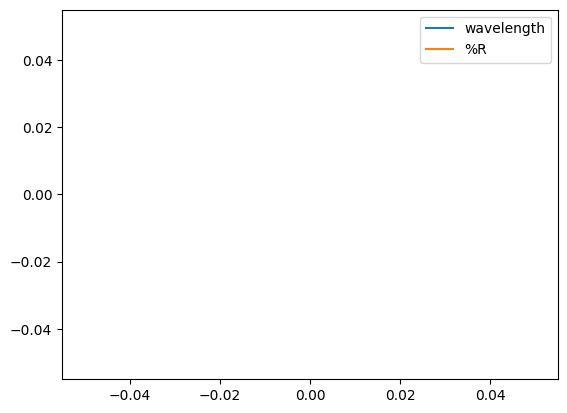

spectrum=<spectraltools.Spectrum object at 0x0000024F743EBE00>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=26    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2248544L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

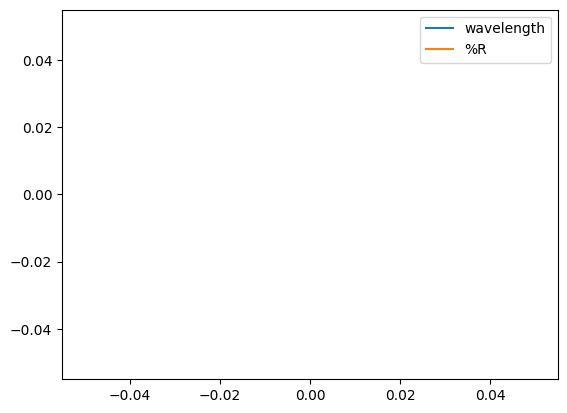

spectrum=<spectraltools.Spectrum object at 0x0000024F72B0E270>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=27    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249504L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

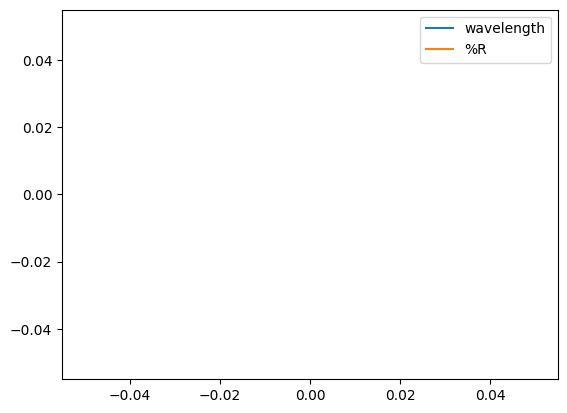

spectrum=<spectraltools.Spectrum object at 0x0000024F72BC8FB0>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=28    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2249505L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

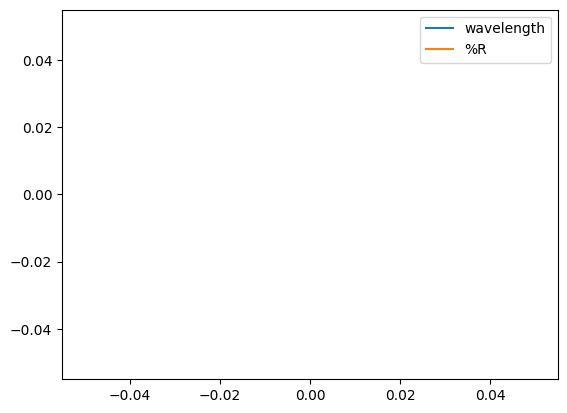

spectrum=<spectraltools.Spectrum object at 0x0000024F743EB620>
Create spectrum from file
Collection lookup
INBIO
Genus specimen=29    Chrysina
Name: genus, dtype: object


C:\Users\esteb\cicima\escarabajos\libraries\spectraltools.py:418: UserWarning: Dataframe is empty. File: ..\test\data\test_step_jump_correction\files\2253302L1.csv
  warnings.warn(f"Dataframe is empty. File: {file_location}", UserWarning)


<Figure size 640x480 with 0 Axes>

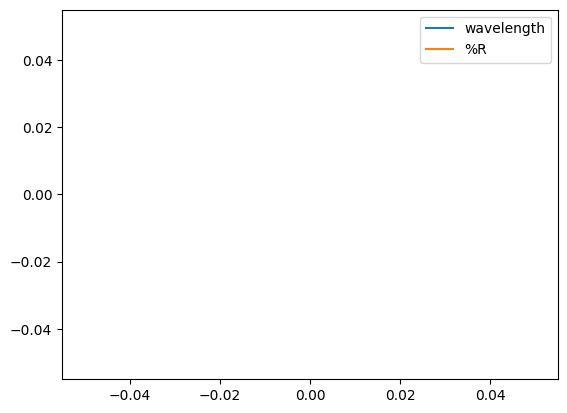

In [ ]:
#Create report
def create_correction_report(filtered_list):
    """This function creates a report with the corrected dataframes"""
    jump_corrected_dict = []
    file_counter = 0
    
    #create a subfolder called report with the correction process info  
    report_path.mkdir(parents=True, exist_ok=True)

    #create report name
    new_file = os.path.join( report_path , f'original_data_{date}.pdf')

    #make a list of all files with code
    files_with_code = []
    for code in codes:
        files_with_code += [file for file in filtered_list if code in file]

    #print(f"{files_with_code=}")
    
    #create a report in pdf
    with matplotlib.backends.backend_pdf.PdfPages(new_file) as pdf:
        
        for code in codes: 
            #Code by code we will plot all the spectra with the wsame name
            code_file_counter = 1

            #filters each file if the code is in its basename
            files_with_code = [file for file in filtered_list if code in file]

            #separates the files between l1050 files and CRAIC files
            CRAIC_files = [file for file in files_with_code if check_CRAIC_file(file)]
            l1050_files = [file for file in files_with_code if check_l1050_file(file)]
            
            #creates a figure to plot 
            plt.figure(figsize=(10, 4))

            #plots each file before changes
            for file in files_with_code:
                code_file_counter += 1
                file_counter += 1
                plot_dataframe_before_changes(file, code, collection_list, code_file_counter)

            #for each l1050 file 
            for file in l1050_files:
                
                #Initialize corrected_dict
                corrected_dict = {}
                
                corrected_dict = l1050_get_corrected_dataframe_and_info(file, code, collection_list, code_file_counter)

                #append files to the jump_corrected_dict to be used later
                jump_corrected_dict.append(corrected_dict) #declared at the beginning of this method
                
                #saves the corrected file
                save_corrected_df(corrected_dict["df_corrected"], corrected_dict["file"], corrected_dict["metadata"])
                
                ### end for

            #Now for CRAIC files, these are separated between R, L and O polarization
            #and these are not corrected for jumps, only printed

            #for each l1050 file 
            for file in CRAIC_files:
                
                #Get info for each file
                corrected_dict = CRAIC_get_dataframe_and_info(file, code, collection_list)
                    
                #append files to the jump_corrected_dict to be used later
                jump_corrected_dict.append(corrected_dict)

            #plot the dataframe
                if CRAIC_files:
                    #get average polarizations
                    right_average_df, left_average_df = CRAIC_get_average_polarizations(CRAIC_files, code)
        
                    #get total average_df
                    total_average_df = CRAIC_get_total_average_dataframe(right_average_df, left_average_df)
        
                    #get corrected total average
                    corrected_total_average_df = CRAIC_correct_total_average(total_average_df)
        
                    #get the first file 
                    first_file = CRAIC_files[0]
                    first_spectrum = create_spectrum_from_file(first_file, code, collection_list)
                    
                    #no correction needed
                    metadata = first_spectrum.get_metadata()
                    
                    #saves the corrected file
                    save_corrected_df(corrected_total_average_df, first_file, metadata)

                
                ### end for
                
            plt.title(f'1. Raw data. {code}')
            plt.ylim(0,120)
            plt.legend()
            plt.grid(True)
            #plt.show()
            pdf.savefig()
            plt.close()

create_correction_report(non_empty_files)

In [ ]:
var_dataframes = None
def average_1050_files(file_list, code_set, directory, pdf):

    #parent directory and save_directory
    jump_corrected_path = os.path.join( directory , "jump_corrected_files")
    save_directory = os.path.dirname(jump_corrected_path)
    
    #print(f"{save_directory=}")
    file_counter = 0

    #Look for every available code in the folder
    for code in code_set:
        print(f"{code=}") 
        
        dataframes = []
        files_with_code =[file for file in file_list if code in Path(file).name] #gets each file that starts with the code provided
        print(files_with_code)
        
        # Read each file, create dataframes, and plot them
        for file_path in file_list:
            #print(f"{file_path=}")
            #create spectrum object
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            spectrum = Spectrum(file_path, collection_list)
            
            #get metadata and dataframe
            #print("Reading file...")
            #print("Getting metadata and dataframe...")
            metadata, df = spectrum.get_metadata(), spectrum.get_dataframe()

            #metadata info
            measuring_mode = metadata["measuring_mode"]
            sample_name = metadata["code"] 

            # Read the file into a pandas DataFrame
            #convert columns to float
            #print("Converting columns to float...")
            df['wavelength'] = df['wavelength'].astype(float)
            df[measuring_mode] = df[measuring_mode].astype(float)
            
            #print("Dropping index...")
            try:
                df = df.drop("index", axis = 1)
            except Exception as e:
                #print (e)
                pass
            #print("Printing head...")
            
            #print(df.head())
            # Append the dataframe to the list if not empty
            if not df.empty and not None and len(df) != 0:
                dataframes.append(df) 
            
        # Calculate the average of all dataframes ignore empty ones
        # average l1050 files and polarization_sum CRAIC files
        print("elements")
        
        #print(dataframes)
        print(len(dataframes))

        #If there are no dataframes, continue
        if len(dataframes) == 0:
            continue
        #If there is only one 
        elif len(dataframes) == 1:
            average_df = dataframes[0]
            std_dev_df = pd.DataFrame([])
        #If there are many
        else:
            average_df = pd.concat(dataframes).groupby('wavelength').mean().reset_index()
            std_dev_df = pd.concat(dataframes).groupby('wavelength').std().reset_index()

        try: 
            #print(f"{average_df=}")
            
            #average plot
            avg_plot = average_df.plot(x='wavelength', y=measuring_mode, kind='scatter', s=markersize, title = sample_name + " avg", figsize = (10, 4), grid=True)
            #save figures
            plt.ylim(0,y.max()*1.1)
            pdf.savefig()
            #close plot
            plt.close()
            
            #standard deviation plot
            std_plot = std_dev_df.plot(x='wavelength', y=measuring_mode, color = "r", kind='scatter', s=markersize, title = sample_name + " std dev", figsize = (10,4), grid=True)
            #save figures
            pdf.savefig()
            #close plot
            plt.close()
        except Exception as e:
            pass
            print(e)
            
        #SAVE FILE
        #Convert to numpy
        average_np = average_df.to_numpy()
        std_dev_np = std_dev_df.to_numpy()
        
        #Create new folder
      
        avg_new_path = os.path.join(save_directory , "average")
        std_dev_new_path = os.path.join(save_directory , "std_dev") 

        
        if not os.path.exists(avg_new_path):
            os.mkdir(avg_new_path)
        if not os.path.exists(std_dev_new_path):
            os.mkdir(std_dev_new_path)

        #creates new filename
        #print(f"sample name: {sample_name}")

        new_avg_archive_name = os.path.join(avg_new_path, sample_name+'.txt')
        new_std_dev_archive_name = os.path.join( std_dev_new_path , sample_name+'.txt')

        #print(new_avg_archive_name)
        #saves files
        np.savetxt(new_avg_archive_name, average_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        np.savetxt(new_std_dev_archive_name, std_dev_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        #print("fin de la iteracion")

        def delete_blank_row(archive_name):
            with open(archive_name, "r") as f:
                data = f.read()
            with open(archive_name, "w") as f:
                f.write(data.replace("#DATA\n","#DATA"))

        delete_blank_row(new_avg_archive_name)
        delete_blank_row(new_std_dev_archive_name)
                         
        file_counter = file_counter +1
        
    print(f"{file_counter} averages were calculated")
    print(f"Report file is located in {save_directory}")
        
        

In [ ]:
def get_files_with_same_name(filtered_list):
    #get files in directory
    files = []
    for file in filtered_list:
        files.append( os.path.basename(file))
    
    #print(files)
    
    sample_names = []
    lambda1050_regex = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
    craic_regex_1 = r"(\d*)([RLO])(\d*)"
    craic_regex_2 = r"([a-zA-Z\d]*)_([RLO])_(\d*)"
    regexs =[lambda1050_regex, craic_regex_1, craic_regex_2]  
    #Names are in the form CODE-MEASUREMENTNUMBER.TXT
    for file in files:
        #print(file)
        for regex in regexs:
            p = re.compile(regex)
            m = p.match(file)
            if m:
                sample_names.append(m.group(1))

    return set(sample_names)

In [ ]:
def average_CRAIC_files(file_list, code, directory, pdf):

    for file in file_list:
        
        right_average_df, left_average_df = CRAIC_get_average_polarizations(files_with_code= file_list, code = code)
        print(f"{right_average_df=}")
        print(f"{left_average_df=}")
      
        #return average dataframe
        total_average_df = CRAIC_get_total_average_dataframe(right_average_df, left_average_df)
        print(f"{total_average_df=}")
        #correct it 
        corrected_df = CRAIC_correct_total_average(total_average_df)
        print(f"{corrected_df=}")
        #create spectrum with that df

        return corrected_df

In [ ]:
### Calculate the average for each spectrum if it has the same name
avg_std_report_file = report_path.parent/ Path(parent_folder_data_path).name / "average_and_std_report.pdf"
#print(avg_std_report_file)

with matplotlib.backends.backend_pdf.PdfPages(avg_std_report_file) as pdf:
    code_set = get_files_with_same_name(non_empty_files)
    #print(code_set)
    for code in code_set:

        files_with_code = [file for file in non_empty_files if code in file]
        
        #separates the files between l1050 files and CRAIC files
        
        CRAIC_files = [file for file in files_with_code if check_CRAIC_file(file)]
        l1050_files = [file for file in files_with_code if check_l1050_file(file)]

        if len(CRAIC_files) > 1:
            file_path = CRAIC_files[0]
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            spectrum = Spectrum(file_path, collection_list)
            df = average_CRAIC_files(file_list=CRAIC_files, code= code, directory= avg_std_report_file, pdf=pdf)
            
            spectrum.set_dataframe(df) 
            save_corrected_spectrum(spectrum)
        if len(l1050_files) > 1:
            file_path = l1050_files[0]
            collection = Specimen_Collection.collection_lookup(code, collection_list)
            spectrum = Spectrum(file_path, collection_list)
            df = average_1050_files(file_list=l1050_files, code_set= code_set, directory= avg_std_report_file, pdf=pdf)
            #print(df)
            spectrum.set_dataframe(df)
            save_corrected_spectrum(spectrum)
    

#Create jump_corrected_files report

avg_std_report_file = os.path.join(report_path, "detector_jump_correction_report.pdf")
print(avg_std_report_file)

with matplotlib.backends.backend_pdf.PdfPages(avg_std_report_file) as pdf:
    
    jump_corrected_path = os.path.join(parent_folder_data_path , "jump_corrected_files")

    code_set = get_files_with_same_name(jump_corrected_path)

    average_files(successful_list_without_excluded_files, code_set, jump_corrected_path, pdf)

        
        